# 1 Introduction
## 1-1 Quantum State Preparation
Quantum state preparation is fundamental to quantum computing. It lies at the heart of quantum algorithms, quantum machine learning, quantum error correction, and quantum physics research, but it can be very difficult to start from an initial state $|0\dots 0 \rangle$ and efficiently prepare an arbitrary state $|\psi \rangle$ with high fidelity. Your objective for this year's Open Science Prize is to significantly improve state-of-the-art state preparation in the context of the Variational Quantum Eigensolver (VQE) algorithm.

The state you will prepare is the highly entangled ground state of a Heisenberg spin-1/2 model on a kagome lattice. That sentence is jam packed with physics jargon, but do not despair. Though the problem statement originates deep within quantum physics research, we will avoid jargon as much as possible. A deep dive into the physics literature (which is very fascinating) is left as an exercise for the reader.

Why the ground state of a Heisenberg model? Well, the ground state of a system is it's lowest energy configuration, and the ground state tends to be where exciting and unexpected quantum affects flourish. For example, when the element Mercury is cooled down near its ground state (below 4 Kelvin), it has no electrical resistance. None. Zero! Near its thermal ground state, a chunk of Mercury is [a superconductor](https://en.wikipedia.org/wiki/History_of_superconductivity). Researchers have been trying to understand what materials exhibit superconductivity and how it's even possible ever since it was first discovered. If that isn't cool enough for you, consider the [Bose-Einstein condensate](https://en.wikipedia.org/wiki/Bose–Einstein_condensate). This is quantum phase of matter where a dilute gas of individual atoms (bosonic atoms such as [Rubidium](https://en.wikipedia.org/wiki/Rubidium))--when cooled to their ground state--effectively become one giant particle!

A system's ground state determines important and fascinating physical properties (see the two examples highlighted above), yet some quantum systems have ground states (and their associated energies) which are difficult to make and measure in the lab as well as being intractable for classical computers to calculate. The Variational Quantum Eigensolver (VQE) is a promising quantum algorithm that could find these ground states and their energies.

You will implement the VQE algorithm on [ibmq_guadalupe](https://quantum-computing.ibm.com/services/resources?system=ibmq_guadalupe) a 16 qubit [heavy-hex](https://research.ibm.com/blog/heavy-hex-lattice) device. This is the largest device used in an Open Science Prize to date. Working with more qubits presents its own challenges. Be mindful of how your solution scales as this will be part of the judging criteria this year.

We'll get more into the principles of VQE later, but for now, remember that VQE relies on iterative cycles of quantum and classical computation. Fast iterations and fast communication between the classical and quantum computer are essential for a fast VQE, and [Qiskit runtime](https://github.com/Qiskit/qiskit-ibm-runtime) does just that. [Qiskit runtime](https://medium.com/qiskit/so-what-is-qiskit-runtime-anyway-c78aecf3742) is a programming model and containerized environment designed to reduce the computational cycle time between quantum and classical computers. Later in this notebook, we will demonstrate how to leverage the latest release of runtime for fast VQE.

The notebook is organized as follows: Section 1 gives a brief introduction to the Heisenberg model, the kagome lattice, and VQE algorithm. It also provides a classical calculation of the ground state(s) energy. Section 2 introduces how to construct a VQE experiment and simulate it on your local computer. Section 3 introduces Qiskit runtime and how to run VQE on a cloud simulator or real backend. Finally, if you are feeling stuck, we've provided some questions to consider as you design and implement your solution.

#### Objective
**Your task is to use the VQE algorithm to compute the ground state of a Heisenberg spin-1/2 system on a kagome lattice unit cell with the lowest possible relative error of the measured state's energy expectation value wrt to the exact value.** There are actually two ground states in this specific case, and you may prepare any combination of the two including only one or the other.


## 1-2 Heisenberg spin-1/2 model on the kagome lattice
For the Open Science Prize, (get ready for some jargon) you will work with the antiferromagnetic $XXX$ Heisenberg model arranged on a kagome lattice. The $XXX$ Heisenberg model Hamiltonian for this Prize will be defined as
$$
\begin{equation}
H = \sum_{\langle i j \rangle}^N X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1}
\end{equation}
$$
where $\langle i j \rangle$ is sum over neighboring spins and $X$, $Y$, and $Z$ are the usual Pauli matrices. The Heisenberg model hosts a wide variety of exotic quantum physics all of which heavily depend on the arrangement of the spins. The arrangement we are interested in is a kagome lattice.

![title](kagome_unit_cell.png)

The kagome lattice is a unique lattice structure made up of corner-sharing triangles (see the unit cell above). In general, the kagome lattice (i.e. many unit cells tiled together) is theorized to host a fascinating quantum phase of matter called a quantum spin liquid--a research topic at the forefront of quantum physics [1-3]. Additionally, excitations from that ground state are theorized to show exotic quantum behavior such a fractionalized particle excitations [1-3]. For those interested in a deeper dive into the physics check out Refs. [1-3] and other papers.

This year's Prize will focus on a single unit cell (the base pattern shown above) which has 12 spin-1/2 particles represented in as blue dots in the image below. Each spin will be represented by a single qubit. The lines connecting the spin-1/2 particles called edges--borrowing a term from [graph theory](https://en.wikipedia.org/wiki/Graph_theory)--and they specify which spins are neighbors.

\[1\] "Modern condensed matter physics." Girvin, Steven M., and Kun Yang. Cambridge University Press, (2019).

\[2\] "Spin liquids in frustrated magnets." Balents, Leon. [Nature 464, 199–208](https://doi.org/10.1038/nature08917) (2010). 

\[3\] "Probing topological spin liquids on a programmable quantum simulator." Semeghini, Giulia, et al. [Science 374.6572: 1242-1247.](https://www.science.org/doi/10.1126/science.abi8794) (2021). [arXiv link](https://arxiv.org/abs/2104.04119)

\[4\] "Kagome: The Story of the Basketweave Lattice." Mekata, Mamoru. [Physics Today 56, 2, 12](https://physicstoday.scitation.org/doi/10.1063/1.1564329) (2003).

## 1-3 VQE
The Variational Quantum Eigensolver (VQE) is a quantum algorithm that can find the ground state(s) of a given Hamiltonian [5-7]. The VQE algorithm is based on the [variational principle](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) of quantum mechanics and relies on both quantum and classical computations. Below, we briefly sketch out the main principles of VQE, and encourage you to review educational material and the research literature for details.

Given a Hamiltonian $H$ and ground state $|\psi_g \rangle$, the variational principle says that even if we don't know the exact ground state an approximate ground state $|\tilde{ \psi}_g\rangle \approx |\psi_g \rangle$ can be found. To find the approximate ground state $|\tilde{ \psi}_g\rangle$, we start with a parameterized state called an ansatz $|\psi(\boldsymbol{\theta})\rangle$ where $\boldsymbol{\theta} \equiv (\theta_1, \theta_2,\dots)$ are the parameters. In theory, there is a combination of parameter values where the anstaz approximates the ground state $|\psi(\boldsymbol{\theta})\rangle \approx |\psi_g\rangle$, but we need a way to find those parameter values. This is done with a combination of quantum and classical computing.

To optimize the parameters, many cycles of quantum and classical computing drive the ansatz toward the approximate ground state. The quantum computer computes the energy expectation value of Hamiltonian $H$ acting on the the parameterized anstaz for a given set of parameter values
$$
E(\boldsymbol{\theta}) = \langle \psi(\boldsymbol{\theta}) | H | \psi(\boldsymbol{\theta}) \rangle \;.
$$
For those familiar with optimization terminology this is the cost function. A classical computer uses the measurement data from the quantum computer to determine how the parameters values should be adjusted to further minimize the energy $E(\boldsymbol{\theta})$. As the classical and quantum computer loop through many iterations, they search the parameter space and converge to the approximate ground state.

How can we know the state that gives the minimum energy expectation value is the ground state? The variation principle guarantees that the minimal energy expectation value can only be achieved if the quantum state is the ground state. No other state can give a lower energy--hence the name ground state. In this way, we can be confident that minimizing $E(\boldsymbol{\theta})$ with respect to the parameters $\boldsymbol{\theta}$ will drive the ansatz toward an accurate approximation of the true ground state and not some other state.

Of course, the actual implementation of the algorithm comes with challenges. The ansatz $|\psi(\boldsymbol{\theta})\rangle$ may never reach the ground state for any combination of parameters. The ansatz could have too many parameters and encounter a barren plateau during optimization. When implementing the VQE, it may take an unreasonable amount of time to execute the ansatz or measure the expectation value on quantum hardware. The quantum hardware may be too noisy. The classical optimizer may not pair well with the optimization landscape or the level of noise from the quantum measurements. Etc.

To jump into more details about VQE, we included three review articles on the topic below. We encourage you to review additional educational material and research literature as you work out your solution.

\[5\] "A variational eigenvalue solver on a quantum processor." A. Peruzzo, et al. [arXiv:1304.3061](https://arxiv.org/abs/1304.3061) [quant-ph] (2013).

\[6\] "Variational quantum algorithms." M. Cerezo, et al. [arXiv:2012.09265v2](https://arxiv.org/abs/2012.09265v2) [quant-ph] (2021).

\[7\] "The Variational Quantum Eigensolver: a review of methods and best practices." J. Tilly, et al. [arXiv:2111.05176v3](https://arxiv.org/abs/2111.05176v3) [quant-ph] (2022).


In [1]:
import numpy as np

from time import time

from qiskit.visualization import plot_histogram, plot_bloch_vector

from qiskit.quantum_info import Statevector

from math import pi

import mitiq as mq

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

## Load noisy simulator data

In [92]:
import json
with open("noisy_sim_data.json", "r") as openfile:
    mydata_noisy_sim = json.load(openfile)

In [95]:
intermediate_info_sim = mydata_noisy_sim['intermediate_info_sim_backend_04062023']
parm0 = mydata_noisy_sim['parm0']
parm1 = mydata_noisy_sim['parm1']
parm2 = mydata_noisy_sim['parm2']
parm3 = mydata_noisy_sim['parm3']
parm4 = mydata_noisy_sim['parm4']
parm5 = mydata_noisy_sim['parm5']
parm6 = mydata_noisy_sim['parm6']
parm7 = mydata_noisy_sim['parm7']
parm8 = mydata_noisy_sim['parm8']
parm9 = mydata_noisy_sim['parm9']
parm10 = mydata_noisy_sim['parm10']
parm11 = mydata_noisy_sim['parm11']
parm12 = mydata_noisy_sim['parm12']
parm13 = mydata_noisy_sim['parm13']
parm14 = mydata_noisy_sim['parm14']
parm15 = mydata_noisy_sim['parm15']
parm16 = mydata_noisy_sim['parm16']
parm17 = mydata_noisy_sim['parm17']
parm18 = mydata_noisy_sim['parm18']
parm19 = mydata_noisy_sim['parm19']
parm20 = mydata_noisy_sim['parm20']
parm21 = mydata_noisy_sim['parm21']
parm22 = mydata_noisy_sim['parm22']
parm23 = mydata_noisy_sim['parm23']

# Create a list with all the parm list in it
parm_list = [parm0, parm1, parm2, parm3, parm4, parm5, parm6, parm7, \
             parm8, parm9, parm10, parm11, parm12, parm13, parm14, parm15, \
             parm16, parm17, parm18, parm19, parm20, parm21, parm22, parm23]

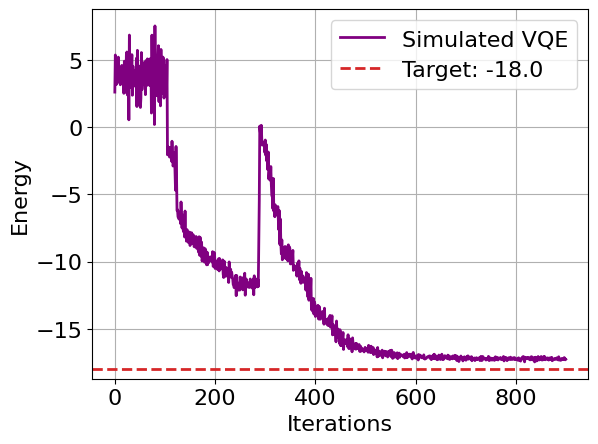

In [6]:
#RToptimized_parms.append((RTresult.optimal_parameters))
plt.plot(intermediate_info_sim, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=-18.0, color="tab:red", ls="--", lw=2, label="Target: " + str(-18.0))
plt.legend()
plt.grid()
plt.show()

In [290]:
minval = min(intermediate_info_sim)

In [291]:
intermediate_info_sim.index(minval)

837

## Test the mitigation of the noisy simulator

In [284]:
# We have dictionaries for X, Y, Z with 80,960 counts total. Should help with shot noise.
# Process these dictionaries through the M3 marginal lens

# Create a function that takes a hamiltonian. Preferably the [type of whatever Z_16 is GARRETT:!!!]
# and a mthree quasi dictionary and returns the expectation value.
def marginal_expval_from_pauli_sum(hamiltonian, rawcounts, mapping, marg_backend, marg_dict):
    if type(hamiltonian) != list:
        print('HEY!!! Hamiltonian parameter is list of pauli strings now!')
        return 0
    ham = hamiltonian
    myval = 0
    mystdev = 0
    marg_mit_dict = marg_dict

    # Loop through the labels calculating expectation of each one
    for pauli_str in ham:
        # Create the marginal distribution object
        marginal_counts, reduced_map = mthree.utils.marginal_distribution(rawcounts, pauli_str, mapping=mapping)

        # Check if we have already created this marginal distribution
        if pauli_str in marg_mit_dict:
            mit = marg_mit_dict[pauli_str]
        else:
            # Let us know we need to make a new one
            print('Warning! Need to create mitigation object '+str(pauli_str))
            mit = mthree.M3Mitigation(marg_backend)
            mit.cals_from_system(reduced_map)
            marg_mit_dict[pauli_str] = mit

        quasi_marg = mit.apply_correction(marginal_counts, reduced_map)

        mytempval = quasi_marg.expval()
        
        myval += mytempval

    return myval, marg_mit_dict

In [42]:
mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}

### Create circuit with the optimized parameters

In [292]:
# Create a list of the optimal parameters. Use the last parameter that was run.
myparms = []
# Get the last parameter from list 0, 1, ... 23
for parms in parm_list:
    myparms.append(parms[837])
    
# Set parameters for circuit
myoptimal = myparms

In [293]:
# Garrett: Make sure Z_16 is built by this point!
# Garrett: Make sure ansatz_opt is created by this point!

In [294]:
# Bind the parameters to the ansatz compiled circuit
myansatz = ansatz_opt.bind_parameters(myoptimal)

# View the compiled circuit
print('number and type of gates in the cirucit:', myansatz.count_ops())
print('number of parameters in the circuit:', myansatz.num_parameters)
#myansatz.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 60), ('sx', 36), ('cx', 6)])
number of parameters in the circuit: 0


### M3 Expectation Value of Noisy Sampler

In [295]:
myansatz_X = myansatz.copy()

# Iterate through the q_layout, adding H gates to circuit
for q in q_layout:
    myansatz_X.h(q)
    
ansatz_measure_X = myansatz_X.measure_all(inplace=False)

In [296]:
myansatz_Y = myansatz.copy()

# Iterate through the q_layout, adding S_dagger and H gates to circuit
for q in q_layout:
    myansatz_Y.sdg(q)
    myansatz_Y.h(q)
    
ansatz_measure_Y = myansatz_Y.measure_all(inplace=False)

In [297]:
ansatz_measure_Z = myansatz.measure_all(inplace=False)

In [298]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'ibmq_qasm_simulator'

#noise model based on real machine
guadalupe_noise_model = NoiseModel.from_backend(guadalupe)

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


#### Get Expectation Values

In [299]:
# Start Simulating Expectation Values

In [300]:
noisy_backend = FakeGuadalupe()

In [301]:
# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
mit_options = Options()
mit_options.simulator.noise_model = guadalupe_noise_model

# Run the circuit through sampler with noisy conditions
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    sampler = RuntimeSampler(session=session, options=mit_options)
    # Run sampler
    job_viewcounts = sampler.run(circuits=[ansatz_measure_X, ansatz_measure_Y, ansatz_measure_Z])
    job_result = job_viewcounts.result()
    binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]

In [302]:
mit_q_layout = [0, 1, 2, 3, 5, 8, 6, 11, 14, 9, 13, 12, 10, 7, 4, 15]
mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}

In [303]:
sim_marg_dictionary = {}
myham = Z_16.primitive.paulis.to_labels()
print(myham)

['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI']


In [304]:
# Parse multiple counts from one sampler run
# Use the M3 package to calculate the expectation value of from the above counts
mit_guadalupe = mthree.M3Mitigation(noisy_backend)
mit_guadalupe.cals_from_system(mit_q_layout)

# Loop through scaled circuits results calculating expectation values
noisy_sim_marg_expval = [0]*3
for index in range(len(binary_probs)):
    # each element of binary probs is a quasi-dist from sampler
    myraw = binary_probs[index]

    # Calculate expected values
    marg_guadalupe_val, sim_marg_dictionary = marginal_expval_from_pauli_sum(hamiltonian=myham, rawcounts=myraw, \
                                                                             mapping=mapping, marg_backend=noisy_backend,\
                                                                             marg_dict=sim_marg_dictionary)
    
    # Place expected values in array
    noisy_sim_marg_expval[index] = marg_guadalupe_val


Warning! Need to create mitigation object IZZIIIIIIIIIIIII
Warning! Need to create mitigation object IIZZIIIIIIIIIIII
Warning! Need to create mitigation object IZIIZIIIIIIIIIII
Warning! Need to create mitigation object IIZIZIIIIIIIIIII
Warning! Need to create mitigation object IIZIIZIIIIIIIIII
Warning! Need to create mitigation object IIIZIZIIIIIIIIII
Warning! Need to create mitigation object IIIIZIIZIIIIIIII
Warning! Need to create mitigation object IIIIIZIIZIIIIIII
Warning! Need to create mitigation object IIIIZIIIIIZIIIII
Warning! Need to create mitigation object IIIIIIIZIIZIIIII
Warning! Need to create mitigation object IIIIIZIIIIIZIIII
Warning! Need to create mitigation object IIIIIIIIZIIZIIII
Warning! Need to create mitigation object IIIIIIIIIIZIZIII
Warning! Need to create mitigation object IIIIIIIIIIZIIZII
Warning! Need to create mitigation object IIIIIIIIIIIZIZII
Warning! Need to create mitigation object IIIIIIIIIIIIZZII
Warning! Need to create mitigation object IIIIIIIIIIIZII

In [305]:
# Return the value of the simulation
print(sum(noisy_sim_marg_expval))

-18.068608290704113


In [306]:
print(rel_err(gs_energy, sum(noisy_sim_marg_expval)))

0.003811571705784031


In [268]:
save_real_guad_marg_dict = marg_dictionary

## Analyzing the Noisy Parameters

In [71]:
ansatz_opt.parameters

ParameterView([Parameter(θ_0), Parameter(θ_1), Parameter(θ_10), Parameter(θ_11), Parameter(θ_12), Parameter(θ_13), Parameter(θ_14), Parameter(θ_15), Parameter(θ_16), Parameter(θ_17), Parameter(θ_18), Parameter(θ_19), Parameter(θ_2), Parameter(θ_20), Parameter(θ_21), Parameter(θ_22), Parameter(θ_23), Parameter(θ_3), Parameter(θ_4), Parameter(θ_5), Parameter(θ_6), Parameter(θ_7), Parameter(θ_8), Parameter(θ_9)])

In [96]:
# The dictionary is setup as follows - Theta_i : Parameter_List_Idx
parm_map = {}

# Iterate through the parameter view used by qiskit
idx = 0
for p in ansatz_opt.parameters:
    # Split the parameter name to get just the parameter number
    split_p = str(p).split('_')
    theta_i = int(split_p[1])
    # With the parameter number in hand. Set it equal to the parameter index
    parm_map[theta_i] = idx
    idx += 1 # Increase the parameter index to the next one
print(parm_map)

{0: 0, 1: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7, 16: 8, 17: 9, 18: 10, 19: 11, 2: 12, 20: 13, 21: 14, 22: 15, 23: 16, 3: 17, 4: 18, 5: 19, 6: 20, 7: 21, 8: 22, 9: 23}


In [106]:
def plot_parms(theta_to_plot):
    # Plot all the parms asked for in the list
    for theta_i in theta_to_plot:
        parm_list_idx = parm_map[theta_i]
        plt.plot(parm_list[parm_list_idx], lw=1.7, label='Parm'+str(theta_i))
    for i in range(-3,4):
        plt.axhline(y=0.5*pi*i, color="tab:red", ls="--", lw=2)
    plt.ylabel('Parameter Value')
    plt.xlabel('Iterations')
    plt.legend()
    plt.grid()
    plt.show()

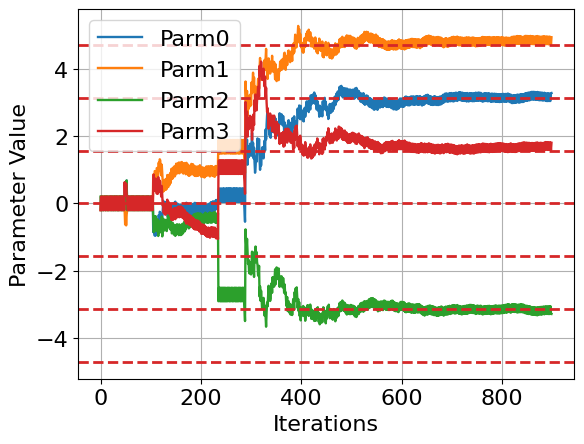

In [107]:
plot_parms([0, 1, 2, 3]) # Checking with my math. Looks good.

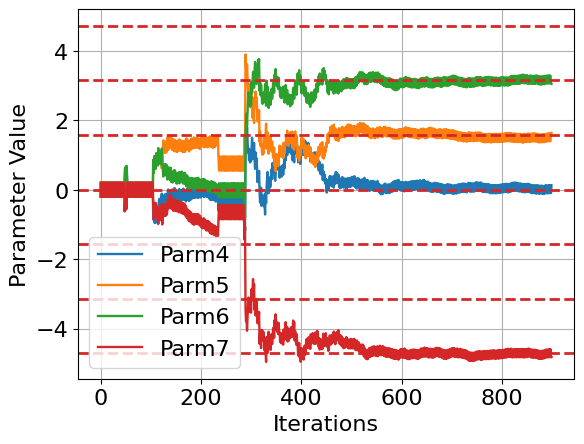

In [108]:
plot_parms([4, 5, 6, 7]) # Checking with my math. Looks good.

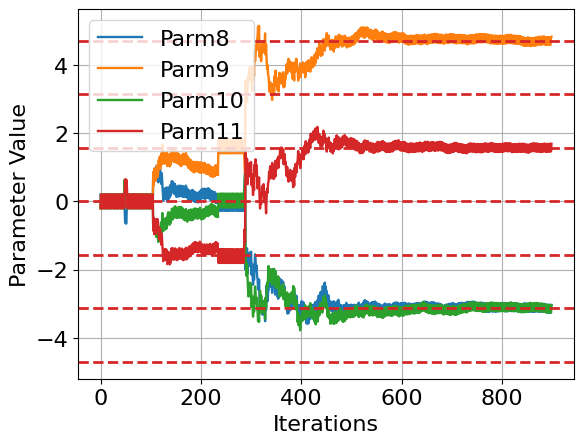

In [109]:
plot_parms([8, 9, 10, 11]) # Checking with my math. Looks good.

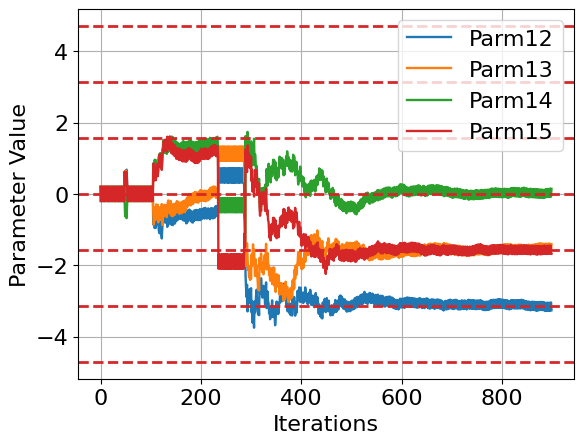

In [110]:
plot_parms([12, 13, 14, 15]) # Checking with my math. Looks good.

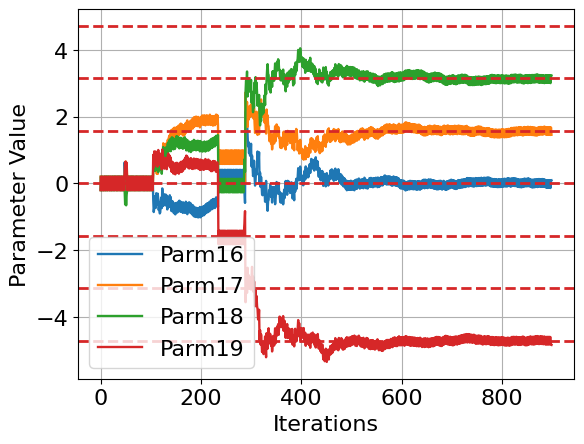

In [111]:
plot_parms([16, 17, 18, 19]) # Checking with my math. Looks good.

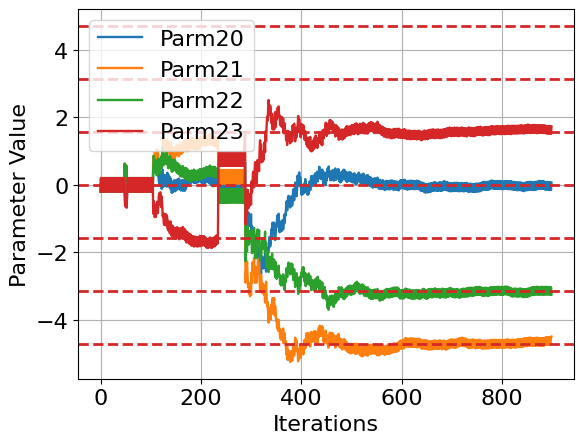

In [112]:
plot_parms([20, 21, 22, 23]) # Checking with my math. Looks good.

## Load Guadalupe Run Data

In [9]:
import mthree

In [8]:
import json
with open("real_guadalupe_data.json", "r") as openfile:
    mydata_real = json.load(openfile)

guadalupe_data_X_list = mydata_real['guadalupe_data_X_list']
guadalupe_data_Y_list = mydata_real['guadalupe_data_Y_list']
guadalupe_data_Z_list = mydata_real['guadalupe_data_Z_list']
guadalupe_data_X_dict = mydata_real['guadalupe_data_X_dict']
guadalupe_data_Y_dict = mydata_real['guadalupe_data_Y_dict']
guadalupe_data_Z_dict = mydata_real['guadalupe_data_Z_dict']

In [38]:
myham = Z_16.primitive.paulis.to_labels()
print(myham)

['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI']


In [39]:
marg_dictionary = {}
# Loop through the hamiltonian strings to create mitgation objects and pull info from json files
for obs in myham:
    # Here are the file names
    file_name = 'marg_cal_'+str(obs)+'.json'
    # Retrieve the m3 calibration from the file
    mit = mthree.M3Mitigation(guadalupe)
    mit.cals_from_file(file_name)
    # Add mitigation object to dictionary
    marg_dictionary[obs] = mit

## Test if we can mitigate Guadalupe counts from file information

In [41]:
def clean_dict(mydict):
    # Start with a clean dictionary
    clean_counts = {}
    # Loop through every key
    for key in mydict:
        if key.count('1') == 6:
            clean_counts[key] = mydict[key]
    return clean_counts

In [42]:
mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}

In [43]:
# Clean up the X, Y, and Z dictionaries
clean_X = clean_dict(guadalupe_data_X_dict)
clean_Y = clean_dict(guadalupe_data_Y_dict)
clean_Z = clean_dict(guadalupe_data_Z_dict)

In [44]:
marg_X = marginal_expval_from_pauli_sum(hamiltonian=myham, rawcounts=clean_X, \
                                        mapping=mapping, marg_backend=guadalupe, \
                                        marg_dict=marg_dictionary)
print(marg_X)

-6.516379847377819


In [45]:
marg_Y = marginal_expval_from_pauli_sum(hamiltonian=myham, rawcounts=clean_Y, \
                                        mapping=mapping, marg_backend=guadalupe, \
                                        marg_dict=marg_dictionary)
print(marg_Y)

-5.67565217306405


In [46]:
marg_Z = marginal_expval_from_pauli_sum(hamiltonian=myham, rawcounts=clean_Z, \
                                        mapping=mapping, marg_backend=guadalupe, \
                                        marg_dict=marg_dictionary)
print(marg_Z)

-5.86249144625486


In [47]:
marg_expval = marg_X+marg_Y+marg_Z
print(marg_expval)

-18.05452346669673


In [48]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, marg_expval)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {marg_expval:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -18.0545234667
Relative error: 0.00302908


## 1-4 Classical computation of ground state energy
The twelve qubit state space isn't terribly large $2^{12} = 4096$, but it also isn't small. A classical computer can still diagonalize the Hamiltonian and thus compute the ground state and its associated energy. For the Open Science Prize, we don't need a full energy spectrum, just a calculation of the ground state energy. When working on your solution, remember that brute force approaches that work on 5 or 7-qubit devices may not work as well with ibmq_guadalupe's 16 qubits.

Below is an example classical calculation of the ground state energy. It will be used as a reference to your VQE results. First, the kagome lattice is defined on a graph. Second, we built the Hamiltonian from the graph edges. Finally, the expected ground state energy is calculated.

### Qiskit nature kagome unit cell
Using Qiskit nature's [`Lattice` object](https://qiskit.org/documentation/nature/tutorials/10_lattice_models.html), we can represent any spin lattice as a graph. Here we construct the unit cell of a kagome lattice by defining a list of edges between the twelve sites. This `Lattice` representation will be convenient to use when defining the $XXX$ Hamiltonian terms.

In [49]:
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from heisenberg_model import HeisenbergModel

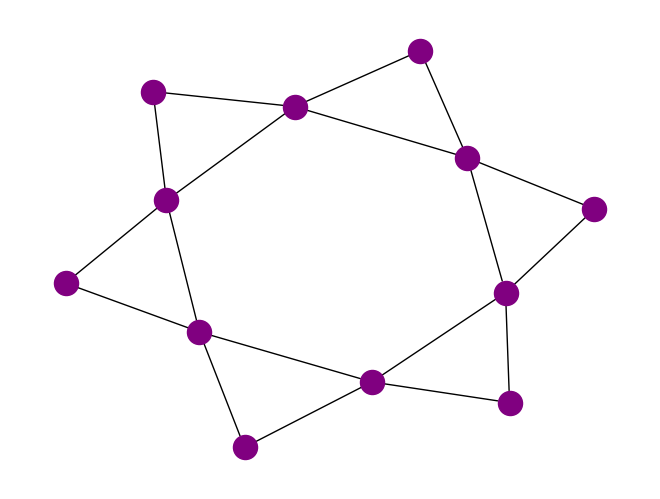

In [50]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

Now that we have the lattice geometry, we can place each term in the Hamiltonian on its corresponding edge. This is done by using the custom `HeisenbergModel` found in the heisenberg_model.py file. This model is based on Qiskit Nature's [`IsingModel` class](https://qiskit.org/documentation/nature/stubs/qiskit_nature.problems.second_quantization.lattice.IsingModel.html) . It places $XX + YY + ZZ$ on each edge of the lattice (per the Hamiltonian's definition).

We will also need to specify how the spin-1/2 particles map to qubits. Using Qiskit nature's `LogarithmicMapper`, we can map each spin-1/2 site to a single qubit. For more information on Qiskit nature's spin mappings see [here]( https://qiskit.org/documentation/nature/stubs/qiskit_nature.mappers.second_quantization.SpinMapper.html#qiskit_nature.mappers.second_quantization.SpinMapper).

In [51]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [52]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

### Compute ground state energy
With the Hamiltonian in hand, we can now calculate the expected ground state and its energy. Qiskit offers different methods to do this. The method [here](https://qiskit.org/documentation/apidoc/algorithms.html#minimum-eigensolvers) computes the ground state energy. This [method](https://qiskit.org/documentation/apidoc/algorithms.html#eigensolvers) computes the ground state ($k=0$) and potentially higher energy states if the users wishes ($k>0$).

Below is an example calculation of finding the lowest 3 energies ($k=3$) of the system using the second method. Remember that for this year's Prize, you will only need to use VQE to find the ground state energy and not any excited state energies.

In [53]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=7)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284 -16.96132284 -16.94488902
 -16.94488902 -16.92960648]


C:\Users\gboha\Anaconda3\envs\mitiqEnv\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


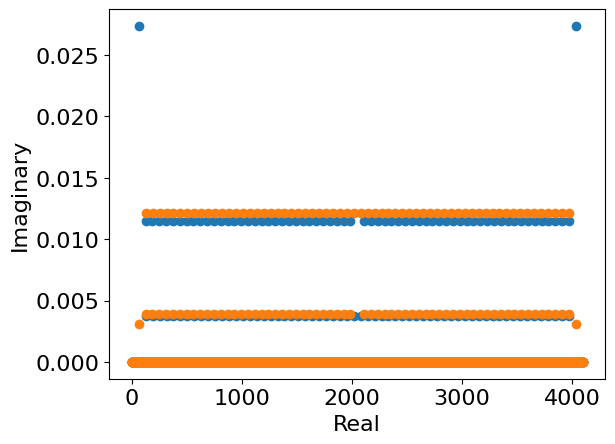

In [54]:
# First eigenstate
e0_matrix = exact_result.eigenstates[0].to_matrix()
e0Ad_matrix = exact_result.eigenstates[0].adjoint().to_matrix()
e0_mag = e0_matrix * e0Ad_matrix
e0_mag = e0_mag[0]

x0 = [i for i in range(len(e0_mag))]
y0 = e0_mag

# Second eigenstate
e1_matrix = exact_result.eigenstates[1].to_matrix()
e1Ad_matrix = exact_result.eigenstates[1].adjoint().to_matrix()
e1_mag = e1_matrix * e1Ad_matrix
e1_mag = e1_mag[0]

x1 = [i for i in range(len(e1_mag))]
y1 = e1_mag

# Third eigenstate -- no longer optimal!
e2_matrix = exact_result.eigenstates[2].to_matrix()
e2Ad_matrix = exact_result.eigenstates[2].adjoint().to_matrix()
e2_mag = e2_matrix * e2Ad_matrix
e2_mag = e2_mag[0]

x2 = [i for i in range(len(e2_mag))]
y2 = e2_mag

plt.scatter(x0, y0)
plt.scatter(x1, y1)
#plt.scatter(x2, y2)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

In [55]:
def findexcitedstate(state, qubit_val):
    return [i for i, digit in enumerate(state) if digit == qubit_val]

print(findexcitedstate('101010', '1'))

[0, 2, 4]


Values Greater than 0.01: [63, 125, 187, 249, 311, 373, 435, 497, 559, 621, 683, 745, 807, 869, 931, 993, 1055, 1117, 1179, 1241, 1303, 1365, 1427, 1489, 1551, 1613, 1675, 1737, 1799, 1861, 1923, 1985, 2110, 2172, 2234, 2296, 2358, 2420, 2482, 2544, 2606, 2668, 2730, 2792, 2854, 2916, 2978, 3040, 3102, 3164, 3226, 3288, 3350, 3412, 3474, 3536, 3598, 3660, 3722, 3784, 3846, 3908, 3970, 4032]
Values between 0.00002 and 0.01: [126, 189, 252, 315, 378, 441, 504, 567, 630, 693, 756, 819, 882, 945, 1008, 1071, 1134, 1197, 1260, 1323, 1386, 1449, 1512, 1575, 1638, 1701, 1764, 1827, 1890, 1953, 2016, 2079, 2142, 2205, 2268, 2331, 2394, 2457, 2520, 2583, 2646, 2709, 2772, 2835, 2898, 2961, 3024, 3087, 3150, 3213, 3276, 3339, 3402, 3465, 3528, 3591, 3654, 3717, 3780, 3843, 3906, 3969]
Number of states: 126


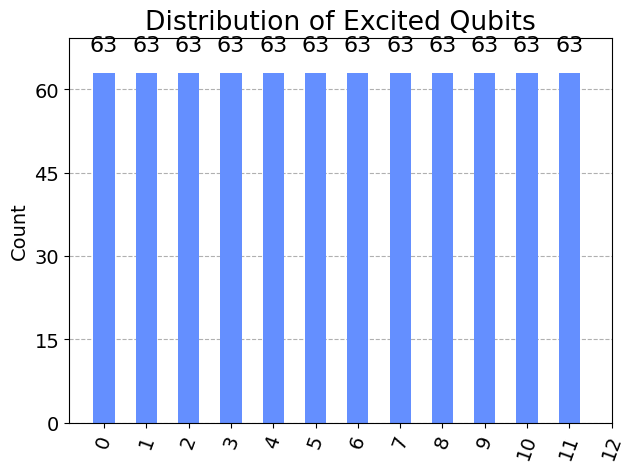

In [56]:
highstates = []

x = x0
y = y0

# Get a distribution for the number of excited qubits
qubit_distribution = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

for i in range(len(x)):
    if y[i] > 0.01:
        highstates.append(x[i])
        binary = bin(x[i])[2:]
        while len(binary) < 12:
            binary = "0"+binary
        # Find all the excited qubits in this binary state
        excitedIndices = findexcitedstate(binary, '1')
        for excitedIdx in excitedIndices:
            qubit_distribution[excitedIdx] += 1
        #print("State: " + binary + "   0s: " + str(binary.count("0")))

        
print("Values Greater than 0.01: " + str(highstates))

middlestates = []

for i in range(len(x)):
    if 0.00002 < y[i] < 0.01:
        middlestates.append(x[i])
        binary = bin(x[i])[2:]
        while len(binary) < 12:
            binary = "0"+binary
        # Find all the excited qubits in this binary state
        excitedIndices = findexcitedstate(binary, '1')
        for excitedIdx in excitedIndices:
            qubit_distribution[excitedIdx] += 1
        #print("State: " + binary + "   0s: " + str(binary.count("0")))

        
print("Values between 0.00002 and 0.01: " + str(middlestates))
print("Number of states: " + str(len(highstates)+len(middlestates)))
plot_histogram(qubit_distribution, title="Distribution of Excited Qubits")

(-18.000000000000114-8.881784197001252e-16j)


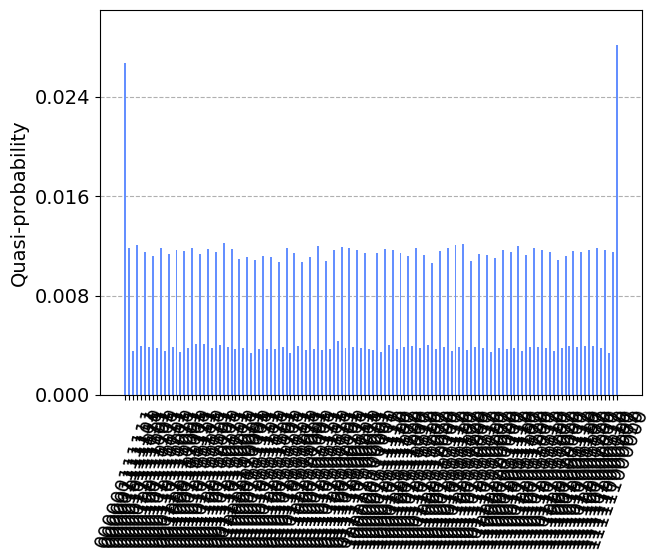

In [57]:
test = (exact_result.eigenstates[0])#.expectation_value(ham))
test2 = Statevector(test.to_matrix())
print(test2.expectation_value(ham))
e0 = exact_result.eigenstates[0].to_matrix()
e0_counts = exact_result.eigenstates[0].sample(100000)

plot_histogram(e0_counts, bar_labels=False)

You'll note that -18 is found twice. This means there are actually two ground states for this system. The -16.96 energy is the first excited state, which is not part of this year's challenge. **For this year's Prize, we will only be judging based off the measured ground state energy. This means it does not matter which of the two ground states, or combination of them, your VQE implementation finds.**

## 2-1 VQE with local runtime primitives

To compute the ground state energy using VQE, we first pick an appropriate device. This year's Prize will use ibmq_guadalupe which has 16 qubits. This is 4 extra qubits than the Hamiltonian, so we will need to "inflate" the Hamiltonian with identity operators so we can measure 12 qubit Hamiltonian's energy expectation value on a 16 qubit device.
After inflating the Hamiltonian, the anstaz and classical optimizer components are built up. Finally, a class is defined to bring everything together for the VQE algorithm, and it's executed on a local simulator.

The code below is largely based off of this example [tutorial](https://github.com/mberna/qce22-qiskit-runtime-tutorial/blob/main/docs/tutorials/Building%20algorithms%20with%20Qiskit%20Runtime.ipynb) of using qiskit runtime primitives from IEEE week. Feel free to read through to learn more about qiskit runtime and VQE.

## 2-2 Qiskit runtime

[Qiskit runtime](https://github.com/Qiskit/qiskit-ibm-runtime) is a paradigm which brings classical and quantum computing resources closer together--speeding up quantum algorithms especially variational ones. We will be using runtime because of its [speed boost](https://research.ibm.com/blog/120x-quantum-speedup) relative to the traditional way quantum circuits are executed using qiskit. In this notebook, we'll demonstrate an example VQE executed with qiskit runtime, but we encourage you to get a deeper understanding of the tool by checking out an overview of qiskit runtime and some tutorials on the [qiskit docs section on runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) as well as the IBM [research blog](https://research.ibm.com/blog/qiskit-runtime-capabilities-integration).

In [58]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

In [59]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account('46aead5c7b98c3015ee89c00fdc3a0b1a909af490abe29443c4880cd57af86021e09f4f03c61702feb2d75fd7c7e76ddf49cb68aef1916f8f91c9d29052b0263', overwrite=True)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
noisy_sim = FakeGuadalupe()


ibmqfactory.load_account:WARNING:2023-04-14 13:46:52,811: Credentials are already in use. The existing account in the session will be replaced.


As mentioned at the beginning of this section, the system Hamiltonian is defined over 12 qubits, but ibmq_guadalupe has 16 qubits. To execute VQE on ibmq_guadalupe, we will "inflate" the Hamilontian from 12 qubits to 16 qubits to match ibmq_guadalupe, but those extra 4 qubits will not participate in the energy expectation value. Here, we've chosen the 4 qubits that won't participate to be 0, 6, 9, 15. You may pick different qubits.

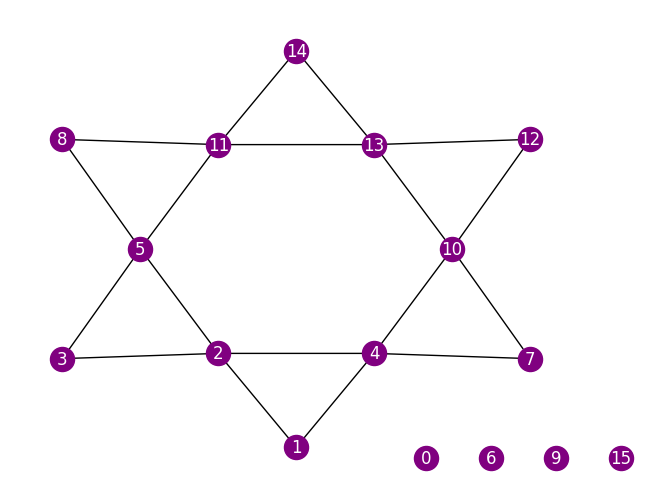

In [60]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()


In [61]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

## 2-3 Define an ansatz
Crafting the ansatz is critical to VQE. You may use a prebuilt ansatz from the [qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits). You may also make your own custom ansatz. Keep in mind that a custom ansatz should have no measurement gates at the end and the circuit parameters are defined by using `Parameter()` [objects](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html). We've demonstrated both options below. The ansatz can be defined over 12 qubits without needed to inflate it to 16 qubits at this point. The transpiler will take care of that later on.

Here's an example using `EfficientSU2()` to generate an ansatz

In [62]:
from qiskit.circuit.library import EfficientSU2

In [63]:
# Construct ansatz from qiskit circuit library functions
# See docs for full details
ansatz = EfficientSU2(12, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
ansatz.draw(fold=300)

┌──────────┐┌───────────┐     ┌───────────┐┌───────────┐                          ┌───────────┐┌───────────┐                                                                                                                                            
 q_0: ─┤ Ry(θ[0]) ├┤ Rz(θ[12]) ├──■──┤ Ry(θ[24]) ├┤ Rz(θ[36]) ├───────────────────■──────┤ Ry(θ[48]) ├┤ Rz(θ[60]) ├───────────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤┌─┴─┐└───────────┘├───────────┤┌───────────┐    ┌─┴─┐    └───────────┘├───────────┤┌───────────┐    ┌─┴─┐                                                                                                                      
 q_1: ─┤ Ry(θ[1]) ├┤ Rz(θ[13]) ├┤ X ├──────■──────┤ Ry(θ[25]) ├┤ Rz(θ[37]) ├────┤ X ├──────────■──────┤ Ry(θ[49]) ├┤ Rz(θ[61]) ├────┤ X ├──────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤└───┘    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                                                                         
 q_2: ─┤ Ry(θ[2]) ├┤ Rz(θ[14]) ├─────────┤ X ├──────────■──────┤ Ry(θ[26]) ├┤ Rz(θ[38]) ├────┤ X ├──────────■──────┤ Ry(θ[50]) ├┤ Rz(θ[62]) ├────┤ X ├──────────■──────────────────────────────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤         └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                                                            
 q_3: ─┤ Ry(θ[3]) ├┤ Rz(θ[15]) ├──────────────────────┤ X ├──────────■──────┤ Ry(θ[27]) ├┤ Rz(θ[39]) ├────┤ X ├──────────■──────┤ Ry(θ[51]) ├┤ Rz(θ[63]) ├────┤ X ├──────────■─────────────────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤                      └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                                               
 q_4: ─┤ Ry(θ[4]) ├┤ Rz(θ[16]) ├───────────────────────────────────┤ X ├──────────■──────┤ Ry(θ[28]) ├┤ Rz(θ[40]) ├────┤ X ├──────────■──────┤ Ry(θ[52]) ├┤ Rz(θ[64]) ├────┤ X ├──────────■────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤                                   └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                                  
 q_5: ─┤ Ry(θ[5]) ├┤ Rz(θ[17]) ├────────────────────────────────────────────────┤ X ├──────────■──────┤ Ry(θ[29]) ├┤ Rz(θ[41]) ├────┤ X ├──────────■──────┤ Ry(θ[53]) ├┤ Rz(θ[65]) ├────┤ X ├──────────■───────────────────────────────────────────────────────
       ├──────────┤├───────────┤                                                └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                     
 q_6: ─┤ Ry(θ[6]) ├┤ Rz(θ[18]) ├─────────────────────────────────────────────────────────────┤ X ├──────────■──────┤ Ry(θ[30]) ├┤ Rz(θ[42]) ├────┤ X ├──────────■──────┤ Ry(θ[54]) ├┤ Rz(θ[66]) ├────┤ X ├──────────■──────────────────────────────────────────
       ├──────────┤├───────────┤                                                             └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                        
 q_7: ─┤ Ry(θ[7]) ├┤ Rz(θ[19]) ├──────────────────────────────────────────────────────────────────────────┤ X ├──────────■──────┤ Ry(θ[31]) ├┤ Rz(θ[43]) ├────┤ X ├────

Here's an example of building a custom ansatz. We'll continue using this one for the rest of the notebook.

In [64]:
# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(12)
# build initial state
ansatz_custom.h(range(0, 12, 1))
#ansatz_custom.cx(range(0, 11, 2), range(1, 12, 2))
# First layer
j = 0
for i in range(12):
    #ansatz_custom.rx(Parameter('θ_' + str(j)), i)
    #j += 1
    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
    j += 1
    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
    j += 1
ansatz_custom.h(range(0, 12, 2))    # <-- Create bell state: 1/root(2)*(|01> + |10>)
ansatz_custom.x(range(1, 13, 2))
ansatz_custom.cx(range(0, 11, 2), range(1, 12, 2))

## Second layer
#for i in range(1,11):
#    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
#    j += 1
#    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
#    j += 1
#ansatz_custom.h(range(1, 11, 2))    # <-- Create bell state: 1/root(2)*(|01> + |10>)
#ansatz_custom.x(range(2, 12, 2))
#ansatz_custom.cx(range(1, 10, 2), range(2, 11, 2))
#ansatz_custom.rx(Parameter('θ_' + str(j)), 0)
#j += 1
#ansatz_custom.rx(Parameter('θ_' + str(j)), 0)
#j += 1

## Third Layer
#for i in range(12):
#    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
#    j += 1
#    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
#    j += 1
#ansatz_custom.h(range(0, 12, 2))    # <-- Create bell state: 1/root(2)*(|01> + |10>)
#ansatz_custom.x(range(1, 13, 2))
#ansatz_custom.cx(range(0, 11, 2), range(1, 12, 2))

## Fourth layer
#for i in range(1,11):
#    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
#    j += 1
#    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
#    j += 1
#ansatz_custom.h(range(1, 11, 2))    # <-- Create bell state: 1/root(2)*(|01> + |10>)
#ansatz_custom.x(range(2, 12, 2))
#ansatz_custom.cx(range(1, 10, 2), range(2, 11, 2))
#ansatz_custom.rx(Parameter('θ_' + str(j)), 11)
#j += 1


ansatz_custom.draw(fold=250)

┌───┐┌─────────┐ ┌─────────┐ ┌───┐     
 q_0: ┤ H ├┤ Rz(θ_0) ├─┤ Ry(θ_1) ├─┤ H ├──■──
      ├───┤├─────────┤ ├─────────┤ ├───┤┌─┴─┐
 q_1: ┤ H ├┤ Rz(θ_2) ├─┤ Ry(θ_3) ├─┤ X ├┤ X ├
      ├───┤├─────────┤ ├─────────┤ ├───┤└───┘
 q_2: ┤ H ├┤ Rz(θ_4) ├─┤ Ry(θ_5) ├─┤ H ├──■──
      ├───┤├─────────┤ ├─────────┤ ├───┤┌─┴─┐
 q_3: ┤ H ├┤ Rz(θ_6) ├─┤ Ry(θ_7) ├─┤ X ├┤ X ├
      ├───┤├─────────┤ ├─────────┤ ├───┤└───┘
 q_4: ┤ H ├┤ Rz(θ_8) ├─┤ Ry(θ_9) ├─┤ H ├──■──
      ├───┤├─────────┴┐├─────────┴┐├───┤┌─┴─┐
 q_5: ┤ H ├┤ Rz(θ_10) ├┤ Ry(θ_11) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
 q_6: ┤ H ├┤ Rz(θ_12) ├┤ Ry(θ_13) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
 q_7: ┤ H ├┤ Rz(θ_14) ├┤ Ry(θ_15) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
 q_8: ┤ H ├┤ Rz(θ_16) ├┤ Ry(θ_17) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
 q_9: ┤ H ├┤ Rz(θ_18) ├┤ Ry(θ_19) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
q_10: ┤ H ├┤ Rz(θ_20) ├┤ Ry(θ_21) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
q_11: ┤ H ├┤ Rz(θ_22) ├┤ Ry(θ_23) ├┤ X ├┤ X ├
      └───┘└──────────┘└──────────┘└───┘└───┘

In [65]:
# Build a custom ansatz from scratch
ansatz_custom_2layer = QuantumCircuit(12)

# Bind to the old circuit

# First layer
j = 0
for i in range(12):
    ansatz_custom_2layer.rz(Parameter('θ_' + str(j)), i)
    j += 1
    ansatz_custom_2layer.ry(Parameter('θ_' + str(j)), i)
    j += 1
ansatz_custom_2layer.h(range(0, 12, 2))    # <-- Create bell state: 1/root(2)*(|01> + |10>)
ansatz_custom_2layer.x(range(1, 13, 2))
ansatz_custom_2layer.cx(range(0, 11, 2), range(1, 12, 2))

## Second layer
#for i in range(1,11):
#    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
#    j += 1
#    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
#    j += 1
#ansatz_custom.h(range(1, 11, 2))    # <-- Create bell state: 1/root(2)*(|01> + |10>)
#ansatz_custom.x(range(2, 12, 2))
#ansatz_custom.cx(range(1, 10, 2), range(2, 11, 2))
#ansatz_custom.rx(Parameter('θ_' + str(j)), 0)
#j += 1

ansatz_custom.draw(fold=250)

┌───┐┌─────────┐ ┌─────────┐ ┌───┐     
 q_0: ┤ H ├┤ Rz(θ_0) ├─┤ Ry(θ_1) ├─┤ H ├──■──
      ├───┤├─────────┤ ├─────────┤ ├───┤┌─┴─┐
 q_1: ┤ H ├┤ Rz(θ_2) ├─┤ Ry(θ_3) ├─┤ X ├┤ X ├
      ├───┤├─────────┤ ├─────────┤ ├───┤└───┘
 q_2: ┤ H ├┤ Rz(θ_4) ├─┤ Ry(θ_5) ├─┤ H ├──■──
      ├───┤├─────────┤ ├─────────┤ ├───┤┌─┴─┐
 q_3: ┤ H ├┤ Rz(θ_6) ├─┤ Ry(θ_7) ├─┤ X ├┤ X ├
      ├───┤├─────────┤ ├─────────┤ ├───┤└───┘
 q_4: ┤ H ├┤ Rz(θ_8) ├─┤ Ry(θ_9) ├─┤ H ├──■──
      ├───┤├─────────┴┐├─────────┴┐├───┤┌─┴─┐
 q_5: ┤ H ├┤ Rz(θ_10) ├┤ Ry(θ_11) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
 q_6: ┤ H ├┤ Rz(θ_12) ├┤ Ry(θ_13) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
 q_7: ┤ H ├┤ Rz(θ_14) ├┤ Ry(θ_15) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
 q_8: ┤ H ├┤ Rz(θ_16) ├┤ Ry(θ_17) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
 q_9: ┤ H ├┤ Rz(θ_18) ├┤ Ry(θ_19) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
q_10: ┤ H ├┤ Rz(θ_20) ├┤ Ry(θ_21) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
q_11: ┤ H ├┤ Rz(θ_22) ├┤ Ry(θ_23) ├┤ X ├┤ X ├
      └───┘└──────────┘└──────────┘└───┘└───┘

### Match qubit layout
The ansatz is currently defined over 12 qubits, but it will be executed on guadalupe which has 16 qubits. To make the ansatz compatible with guadalupe and the inflated Hamiltonian, we can specify the qubit layout on the real device using the transpiler (shown below). We exclude the four qubits with fewest neighbors.

In [66]:
# Select the ansatz to test. 
#test_ansatz = ansatz1         # Single layer of Heis gates
#test_ansatz = ansatz         # Efficient SU2 ansatz
test_ansatz = ansatz_custom  # Open Science default custom ansatz
#test_ansatz = ansatz_connect  # Here we go again... let's give it a try. Not too bad...

In [67]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(test_ansatz, backend=guadalupe, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 60), ('sx', 36), ('cx', 6)])
number of parameters in the circuit: 24


global phase: π
                                                                                                          
 ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────
                ┌─────────┐┌────┐┌─────────┐┌─────────┐ ┌────┐┌─────────────┐ ┌──────────┐┌────┐          
       q_0 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_0) ├─┤ √X ├┤ Rz(θ_1 + π) ├─┤ Rz(-π/2) ├┤ √X ├──■───────
                ├─────────┤├────┤├─────────┤├─────────┤ ├────┤├─────────────┤ └┬────────┬┘├────┤┌─┴─┐     
       q_1 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_2) ├─┤ √X ├┤ Rz(θ_3 + π) ├──┤ Rz(-π) ├─┤ √X ├┤ X ├─────
                ├─────────┤├────┤├─────────┤├─────────┤ ├────┤├─────────────┤ ┌┴────────┴┐├────┤└───┘     
       q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_4) ├─┤ √X ├┤ Rz(θ_5 + π) ├─┤ Rz(-π/2) ├┤ √X ├──■───────
                ├─────────┤├────┤├─────────┤├─────────┴┐├────┤├─────────────┴┐└┬────────┬┘├────┤  │  ┌───┐
      q_11 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_22) ├┤ √X ├┤ Rz(θ_23 + π) ├─┤ Rz(-π) ├─┤ √X ├──┼──┤ X ├
                ├─────────┤├────┤├─────────┤├─────────┬┘├────┤├─────────────┬┘ ├────────┤ ├────┤┌─┴─┐└─┬─┘
       q_3 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_6) ├─┤ √X ├┤ Rz(θ_7 + π) ├──┤ Rz(-π) ├─┤ √X ├┤ X ├──┼──
                └─────────┘└────┘└─────────┘└─────────┘ └────┘└─────────────┘  └────────┘ └────┘└───┘  │  
 ancilla_1 -> 6 ───────────────────────────────────────────────────────────────────────────────────────┼──
                ┌─────────┐┌────┐┌─────────┐┌──────────┐┌────┐┌──────────────┐┌──────────┐┌────┐       │  
      q_10 -> 7 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_20) ├┤ √X ├┤ Rz(θ_21 + π) ├┤ Rz(-π/2) ├┤ √X ├───────■──
                ├─────────┤├────┤├─────────┤├─────────┬┘├────┤├─────────────┬┘├──────────┤├────┤          
       q_4 -> 8 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_8) ├─┤ √X ├┤ Rz(θ_9 + π) ├─┤ Rz(-π/2) ├┤ √X ├──■───────
                └─────────┘└────┘└─────────┘└─────────┘ └────┘└─────────────┘ └──────────┘└────┘  │       
 ancilla_2 -> 9 ──────────────────────────────────────────────────────────────────────────────────┼───────
                ┌─────────┐┌────┐┌─────────┐┌──────────┐┌────┐┌──────────────┐ ┌────────┐ ┌────┐  │  ┌───┐
      q_9 -> 10 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_18) ├┤ √X ├┤ Rz(θ_19 + π) ├─┤ Rz(-π) ├─┤ √X ├──┼──┤ X ├
                ├─────────┤├────┤├─────────┤├──────────┤├────┤├──────────────┤ ├────────┤ ├────┤┌─┴─┐└─┬─┘
      q_5 -> 11 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_10) ├┤ √X ├┤ Rz(θ_11 + π) ├─┤ Rz(-π) ├─┤ √X ├┤ X ├──┼──
                ├─────────┤├────┤├─────────┤├──────────┤├────┤├──────────────┤┌┴────────┴┐├────┤└───┘  │  
      q_8 -> 12 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_16) ├┤ √X ├┤ Rz(θ_17 + π) ├┤ Rz(-π/2) ├┤ √X ├───────■──
                ├─────────┤├────┤├─────────┤├──────────┤├────┤├──────────────┤└┬────────┬┘├────┤┌───┐     
      q_7 -> 13 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_14) ├┤ √X ├┤ Rz(θ_15 + π) ├─┤ Rz(-π) ├─┤ √X ├┤ X ├─────
                ├─────────┤├────┤├─────────┤├──────────┤├────┤├──────────────┤┌┴────────┴┐├────┤└─┬─┘     
      q_6 -> 14 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_12) ├┤ √X ├┤ Rz(θ_13 + π) ├┤ Rz(-π/2) ├┤ √X ├──■───────
                └─────────┘└────┘└─────────┘└──────────┘└────┘└──────────────┘└──────────┘└────┘          
ancilla_3 -> 15 ──────────────────────────────────────────────────────────────────────────────────────────

## 2-4 Choose a classical optimizer
Select a [classical optimizer](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html#local-optimizers). The classical optimizer will encounter errored and stochastic results from the quantum computer due to gate errors, measurement errors, and other noise sources as well as finite sampling affects [8]. Choose a classical optimizer that pairs well with your approach to VQE. Along with choosing a classical optimizer, picking an initial set of parameters plays a significant role in VQE. In this example, a random set of values is picked (shown in the `CustomVQE` class section 2-5).

\[8\] "Using models to improve optimizers for variational quantum algorithms" K. Sung, et al. [arXiv:2005.11011v2](https://arxiv.org/abs/2005.11011v2) [quant-ph] (2020)

In [68]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=750)

## 2-5 Define custom VQE program
The VQE calculation can be efficiently orchestrated between the quantum and classical computer using qiskit's [primitives](https://qiskit.org/documentation/apidoc/primitives.html). Below is a simple example of using the [Estimator primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-estimator) with your computer as a local simulator of a quantum computer. It's convenient to bring the components of VQE together into a custom class which we've called `CustomVQE`.

If you want more control over the measurement results and how the expectation values are computed, use the [Sampler primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-sampler) which will output the probabilities (or quasi-probabilities) of every measured state instead of expectation values.

In [69]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, initial_point=None, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._initialpt = initial_point
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x]) #, shots = 2048)
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Create a penalty if values are drifting away from a multiple of pi/2
            penalty = get_penalty(x)
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value, x, penalty)
            return value
          
        # Get the penalty of the input values. Every value needs to be near a multiple of pi/2
        def get_penalty(x):
            # Value to return
            penalty_val = 0
            # Pi values to iterate over
            all_pi_vals = [0, 0.5*pi, pi, 1.5*pi, 2*pi]
            # Iterate through every parameter
            for i in range(len(x)):
                # Find the distance from the parameter |x[i]| to all the pi values. Remove signs
                penalties = [abs(abs(x[i]) - pi_val) for pi_val in all_pi_vals]
                # Add the minimum penalty to the total
                penalty_val += min(penalties)
            return penalty_val
                
        # Select an initial point for the ansatzs' parameters
        if self._initialpt is None:
            x0 = [0]*self._circuit.num_parameters
        else:
            x0 = self._initialpt
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result, x0


### Callback
It's important to know what's going on between the classical and quantum computer during the optimization. What parameter values is the classical optimizer picking? How does the convergence to the ground state energy behave?

Defining a callback function gives us a chance to peek in. A simple callback method is defined below. See [this tutorial](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html) for more information and be sure to read the classical [optimizers' docs](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) for what specific values can be extracted during optimization. For example [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html#qiskit.algorithms.optimizers.SPSA) returns: (nfev, parameters, value, stepsize, accepted).

In [1666]:
# Define a simple callback function
intermediate_info = []
params_list = [] # Store the parameters that create the best value
penalty_list = [] # Store the penalty info

def callback(value, params, penalty):
    intermediate_info.append(value)
    params_list.append(params)
    penalty_list.append(penalty)

In [1603]:
optimal_params = []
Run_num = 0

## 2-6 Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [70]:
from qiskit.primitives import Estimator, Sampler

In [1605]:
import winsound

In [1667]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_16])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, initial_point=None, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result, initial_points = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
winsound.Beep(325, 325)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1500,
    'eigenstate': None,
    'eigenvalue': -17.956448157074572,
    'optimal_circuit': None,
    'optimal_parameters': array([ 4.01389085e-02,  1.52636531e+00, -3.51363172e-03, -1.58964641e+00,
        7.38205391e-04,  1.49918188e+00, -1.30811753e-01, -1.48827269e+00,
        3.11218303e+00, -1.57121936e+00, -1.68887218e-02, -1.53569935e+00,
        1.33955629e-02, -3.35434681e-02,  1.56477303e+00, -1.03722051e-02,
       -1.58728017e+00, -1.57766954e+00, -3.72712173e-02,  1.58904031e+00,
       -1.74756986e-02, -1.52505336e+00,  1.40385564e-02,  1.52326212e+00]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 260.72


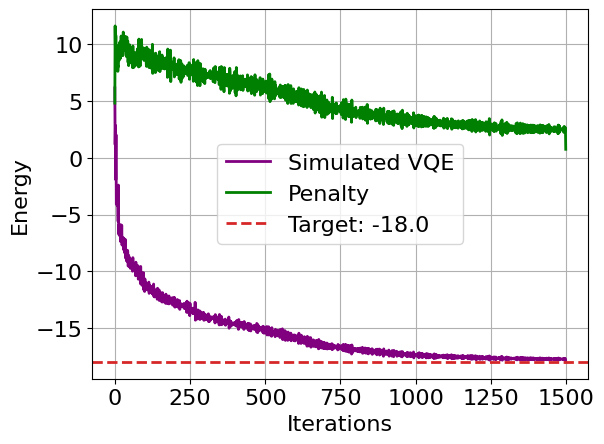

In [1671]:
plt.plot(intermediate_info[-1500:], color='purple', lw=2, label='Simulated VQE')
plt.plot(penalty_list[-1500:], color='green', lw=2, label='Penalty')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [1344]:
def create_parm_list(list_length, parm_num):
    parmlist = parm0 = [0]*list_length
    for i in range(list_length-1,-1,-1):
        parmlist[list_length-i-1]= params_list[-1-i].tolist()[parm_num]
    return parmlist

In [1672]:
parm0 = create_parm_list(1500, 0)
parm1 = create_parm_list(1500, 1)
parm2 = create_parm_list(1500, 2)
parm3 = create_parm_list(1500, 3)
parm4 = create_parm_list(1500, 4)
parm5 = create_parm_list(1500, 5)
parm6 = create_parm_list(1500, 6)
parm7 = create_parm_list(1500, 7)

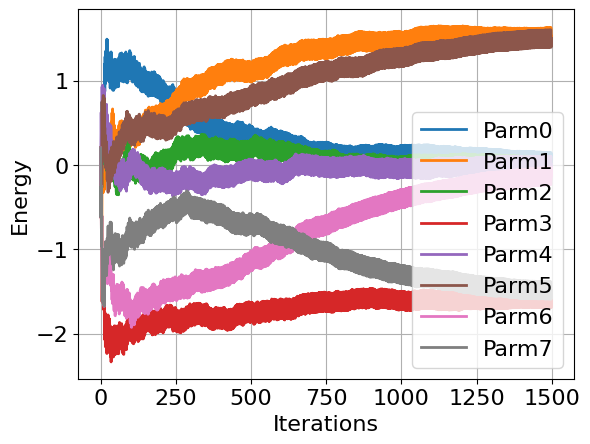

In [1673]:
plt.plot(parm0, lw=2, label='Parm0')
plt.plot(parm1, lw=2, label='Parm1')
plt.plot(parm2, lw=2, label='Parm2')
plt.plot(parm3, lw=2, label='Parm3')
plt.plot(parm4, lw=2, label='Parm4')
plt.plot(parm5, lw=2, label='Parm5')
plt.plot(parm6, lw=2, label='Parm6')
plt.plot(parm7, lw=2, label='Parm7')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
#plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [1675]:
parm8  = create_parm_list(1500, 8)
parm9  = create_parm_list(1500, 9)
parm10 = create_parm_list(1500, 10)
parm11 = create_parm_list(1500, 11)
parm12 = create_parm_list(1500, 12)
parm13 = create_parm_list(1500, 13)
parm14 = create_parm_list(1500, 14)
parm15 = create_parm_list(1500, 15)

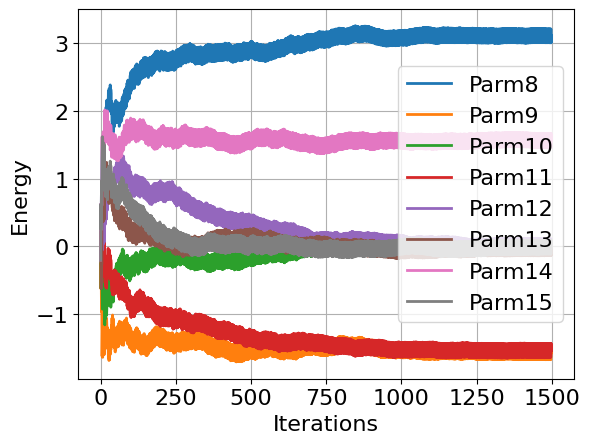

In [1676]:
plt.plot(parm8, lw=2, label='Parm8')
plt.plot(parm9, lw=2, label='Parm9')
plt.plot(parm10, lw=2, label='Parm10')
plt.plot(parm11, lw=2, label='Parm11')
plt.plot(parm12, lw=2, label='Parm12')
plt.plot(parm13, lw=2, label='Parm13')
plt.plot(parm14, lw=2, label='Parm14')
plt.plot(parm15, lw=2, label='Parm15')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
#plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [1677]:
parm16 = create_parm_list(1500, 16)
parm17 = create_parm_list(1500, 17)
parm18 = create_parm_list(1500, 18)
parm19 = create_parm_list(1500, 19)
parm20 = create_parm_list(1500, 20)
parm21 = create_parm_list(1500, 21)
parm22 = create_parm_list(1500, 22)
parm23 = create_parm_list(1500, 23)

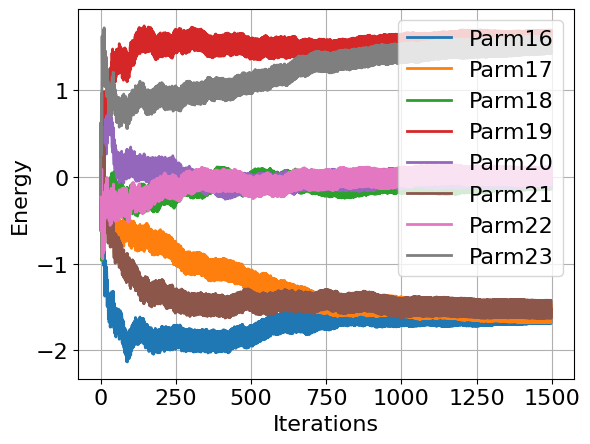

In [1678]:
plt.plot(parm16, lw=2, label='Parm16')
plt.plot(parm17, lw=2, label='Parm17')
plt.plot(parm18, lw=2, label='Parm18')
plt.plot(parm19, lw=2, label='Parm19')
plt.plot(parm20, lw=2, label='Parm20')
plt.plot(parm21, lw=2, label='Parm21')
plt.plot(parm22, lw=2, label='Parm22')
plt.plot(parm23, lw=2, label='Parm23')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
#plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [1614]:
near_optimal_parameters = result.optimal_parameters

## Analyze the Parameter Trend. What multiple of pi/2 are we approaching?

In [1367]:
# Program to calculate exponential
# moving average using formula
  
import numpy as np
 
def exp_moving_average(arr):
    x=0.07  # smoothening factor

    i = 1
    # Initialize an empty list to
    # store exponential moving averages
    moving_averages = []

    # Insert first exponential average in the list
    moving_averages.append(arr[0])

    # Loop through the array elements
    while i < len(arr):

        # Calculate the exponential
        # average by using the formula
        window_average = round((x*arr[i])+
                               (1-x)*moving_averages[-1], 2)

        # Store the cumulative average
        # of current window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1

    return moving_averages

In [1371]:
# Program to calculate moving average using numpy

def simple_moving_average(arr, window_size):

    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array t o
    #consider every window of size 3
    while i < len(arr) - window_size + 1:

        # Calculate the average of current window
        window_average = round(np.sum(arr[
        i:i+window_size]) / window_size, 2)

        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1

    return moving_averages

In [1646]:
# Break the data into buckets and analyze each bucket
def data_buckets(mylist, bucket_size):
    # Break the data into buckets
    total_size = len(mylist)
    remainder = total_size%bucket_size
    num_buckets = total_size//bucket_size
    
    # Evenly split the remainder
    extra_per_bucket = int(np.floor(remainder/num_buckets))
    leftover = remainder - extra_per_bucket*num_buckets
    
    # Adjust the bucket size
    bucket_size += extra_per_bucket
        
    # The bucket size is now set. Store data in buckets
    all_buckets = []
    need_bucket = True
    
    # Go through all the data filling buckets as you go
    for i in range(total_size): # Loop through all data
        
        # If we do not need a bucket yet (accounts for initializing) and this 
        # bucket is full then save the bucket and indicate we need a new bucket
        if not need_bucket and this_bucket_count >= len(this_bucket):
            all_buckets.append(this_bucket)
            need_bucket = True
        
        # Create a bucket and fill it
        if need_bucket:
            if leftover > 0:    # IF there's a leftover add it to the bucket
                this_bucket = [0] * (bucket_size+1)
                leftover = leftover - 1
            else:
                this_bucket = [0] * bucket_size
            need_bucket = False # We don't need a bucket at this point
            this_bucket_count = 0 # No data in bucket yet
                        
        # Fill the bucket
        this_bucket[this_bucket_count] = mylist[i]
        this_bucket_count += 1
        
    # We never appending the last bucket. Do so now
    all_buckets.append(this_bucket)
    
    # We filled all the buckets. Return them
    return all_buckets
    

In [1679]:
from numpy import diff
parm0_exp_avg = exp_moving_average(parm0)
parm0_simp_avg = simple_moving_average(parm0, 20)
parm0_mean_slope = simple_moving_average(diff(parm0), 20)

In [1680]:
my_vqe = intermediate_info
my_vqe_slope = diff(simple_moving_average(my_vqe, 10))

In [1681]:
b_size = 10
my_vqe_buckets = data_buckets(my_vqe, b_size)

In [1682]:
bucket_averages = [0]*len(my_vqe_buckets)
for i in range(len(my_vqe_buckets)):
    # Put scalar average of array in bucket_averages
    bucket_averages[i] = np.mean(my_vqe_buckets[i])
bucket_x_vals = [b_size//2+i*b_size for i in range(len(bucket_averages))]

In [1683]:
bucket_stds = [0]*len(my_vqe_buckets)
for i in range(len(my_vqe_buckets)):
    # Put scalar standard deviate of array in bucket stds
    bucket_stds[i] = np.std(my_vqe_buckets[i])

In [1684]:
#bucket_averages = exp_moving_average(bucket_averages)

In [1685]:
bucket_slope = exp_moving_average(diff(bucket_averages))
bucket_std_slope = exp_moving_average(diff(bucket_stds))

(-0.1, 0.1)

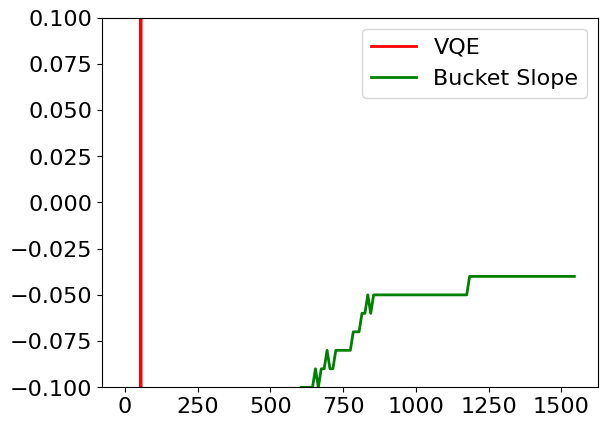

In [1695]:
plt.plot(my_vqe, lw=2, color='red', label='VQE')
plt.plot(bucket_x_vals[1:], bucket_slope, lw=2, color='green', label='Bucket Slope')
plt.scatter(bucket_x_vals, bucket_averages)
plt.legend()
plt.ylim([-0.1, 0.1])

In [1714]:
def parm_distance(val):
    myval = abs(val)
    
    # Divide by pi/2
    whole = myval//(0.5*pi)
    fraction = (myval/(0.5*pi))%1
    
    # Decide what value to return
    if fraction > 0.5:
        whole += 1
        returnval = whole*0.5*pi - myval
    else:
        returnval = myval - whole*0.5*pi
    
    if val < 0:
        whole = -whole
    return [returnval, whole]
        

In [1703]:
.1*pi

0.3141592653589793

In [1727]:
ugh = 0.98*pi
dist_result = parm_distance(ugh)
print(dist_result[0])
print(dist_result[1])

0.06283185307179595
2.0


In [1772]:
tol = 0.2*(0.5*pi)
index = 1330
all_parms0_11 = [parm0, parm1, parm2, parm3, parm4, parm5, parm6, parm7, parm8, parm9, parm10, parm11]
all_parms12_23 = [parm12, parm13, parm14, parm15, parm16, parm17, parm18, parm19, parm20, parm21, parm22, parm23]

all_dist = []
all_mults = []

for myparm in all_parms0_11:
    dist_result = parm_distance(myparm[index])
    all_dist.append(dist_result[0])
    all_mults.append(dist_result[1])
    if dist_result[0] > tol:
        print('No Good!')
    #print(dist_result[0])
    #print(dist_result[1])
for myparm in all_parms0_11:
    dist_result = parm_distance(myparm[index])
    all_dist.append(dist_result[0])
    all_mults.append(dist_result[1])
    if dist_result[0] > tol:
        print('No Good!')
    #print(dist_result[0])
    #print(dist_result[1])
print(all_dist)
print(all_mults)

[0.17977716170353955, 0.05219089005530542, 0.09243659458415375, 0.13031311585059546, 0.11072750892330886, 0.00646191785209016, 0.2899562432558055, 0.01828845734585327, 0.07186855334806674, 0.10745937719179643, 0.09920563418706332, 0.07642511392266282, 0.17977716170353955, 0.05219089005530542, 0.09243659458415375, 0.13031311585059546, 0.11072750892330886, 0.00646191785209016, 0.2899562432558055, 0.01828845734585327, 0.07186855334806674, 0.10745937719179643, 0.09920563418706332, 0.07642511392266282]
[0.0, 1.0, -0.0, -1.0, -0.0, 1.0, -0.0, -1.0, 2.0, -1.0, 0.0, -1.0, 0.0, 1.0, -0.0, -1.0, -0.0, 1.0, -0.0, -1.0, 2.0, -1.0, 0.0, -1.0]


In [1657]:
def plot_bucket(data_list, b_size, plot_it=True):
    p0_buckets = data_buckets(data_list, b_size)
    
    p0_bucket_averages = [0]*len(p0_buckets)
    for i in range(len(p0_buckets)):
        # Put scalar average of array in bucket_averages
        p0_bucket_averages[i] = np.mean(p0_buckets[i])
    p0_bucket_x_vals = [b_size//2+i*b_size for i in range(len(p0_bucket_averages))]
    
    p0_bucket_stds = [0]*len(p0_buckets)
    for i in range(len(p0_buckets)):
        # Put scalar standard deviate of array in bucket stds
        p0_bucket_stds[i] = np.std(p0_buckets[i])
        
    p0_bucket_slope = exp_moving_average(diff(p0_bucket_averages))
    p0_bucket_std_slope = exp_moving_average(diff(p0_bucket_stds))
    
    if plot_it:
        plt.plot(parm0, lw=2, color='red', label='VQE')
        plt.plot(p0_bucket_x_vals[1:], p0_bucket_slope, lw=2, color='green', label='Bucket Slope')
        plt.scatter(p0_bucket_x_vals, p0_bucket_averages)
        plt.legend()
        plt.ylim([-1, 1])
        plt.show()
    
    return p0_bucket_slope

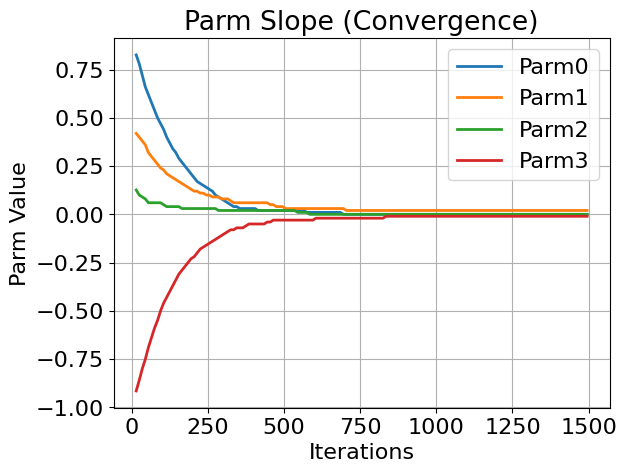

In [1688]:
# Get slopes
p0_slope = plot_bucket(parm0, 10, plot_it=False)
p1_slope = plot_bucket(parm1, 10, plot_it=False)
p2_slope = plot_bucket(parm2, 10, plot_it=False)
p3_slope = plot_bucket(parm3, 10, plot_it=False)
plt.plot(p0_bucket_x_vals[1:], p0_slope, lw=2, label='Parm0')
plt.plot(p0_bucket_x_vals[1:], p1_slope, lw=2, label='Parm1')
plt.plot(p0_bucket_x_vals[1:], p2_slope, lw=2, label='Parm2')
plt.plot(p0_bucket_x_vals[1:], p3_slope, lw=2, label='Parm3')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Parm Slope (Convergence)')
plt.legend()
plt.grid()
plt.show()

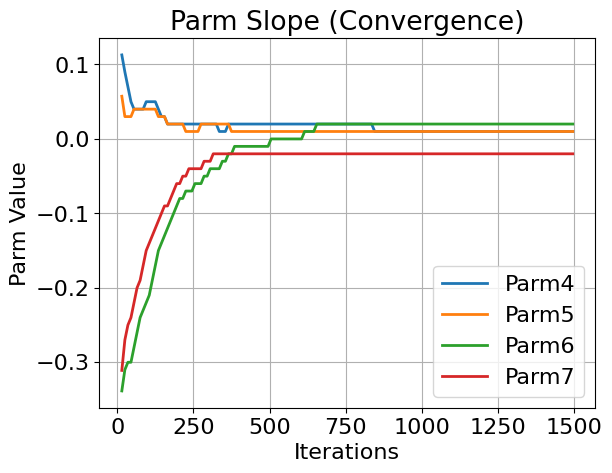

In [1689]:
# Get slopes
p4_slope = plot_bucket(parm4, 10, plot_it=False)
p5_slope = plot_bucket(parm5, 10, plot_it=False)
p6_slope = plot_bucket(parm6, 10, plot_it=False)
p7_slope = plot_bucket(parm7, 10, plot_it=False)
plt.plot(p0_bucket_x_vals[1:], p4_slope, lw=2, label='Parm4')
plt.plot(p0_bucket_x_vals[1:], p5_slope, lw=2, label='Parm5')
plt.plot(p0_bucket_x_vals[1:], p6_slope, lw=2, label='Parm6')
plt.plot(p0_bucket_x_vals[1:], p7_slope, lw=2, label='Parm7')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Parm Slope (Convergence)')
plt.legend()
plt.grid()
plt.show()

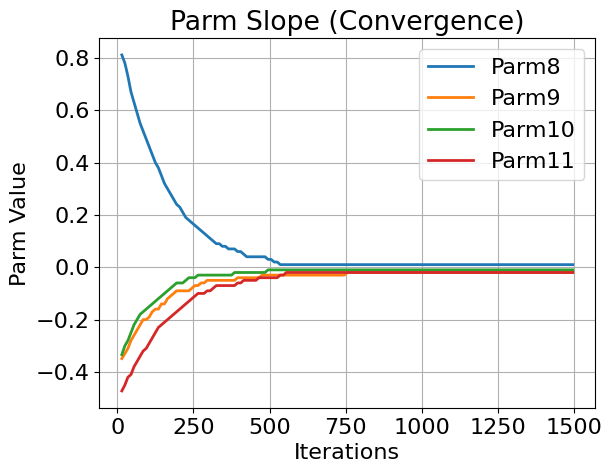

In [1690]:
# Get slopes
p8_slope = plot_bucket(parm8, 10, plot_it=False)
p9_slope = plot_bucket(parm9, 10, plot_it=False)
p10_slope = plot_bucket(parm10, 10, plot_it=False)
p11_slope = plot_bucket(parm11, 10, plot_it=False)
plt.plot(p0_bucket_x_vals[1:], p8_slope, lw=2, label='Parm8')
plt.plot(p0_bucket_x_vals[1:], p9_slope, lw=2, label='Parm9')
plt.plot(p0_bucket_x_vals[1:], p10_slope, lw=2, label='Parm10')
plt.plot(p0_bucket_x_vals[1:], p11_slope, lw=2, label='Parm11')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Parm Slope (Convergence)')
plt.legend()
plt.grid()
plt.show()

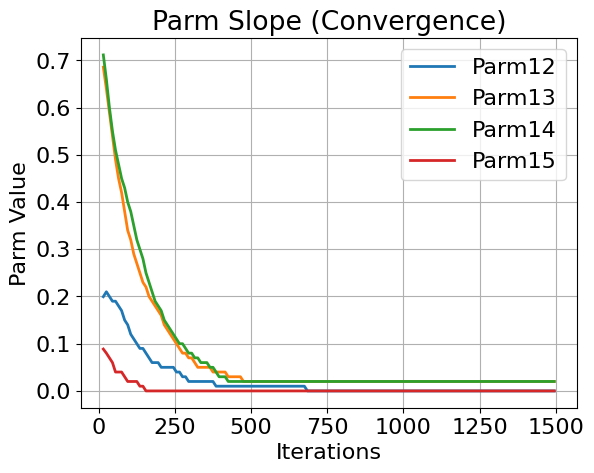

In [1691]:
# Get slopes
p12_slope = plot_bucket(parm12, 10, plot_it=False)
p13_slope = plot_bucket(parm13, 10, plot_it=False)
p14_slope = plot_bucket(parm14, 10, plot_it=False)
p15_slope = plot_bucket(parm15, 10, plot_it=False)
plt.plot(p0_bucket_x_vals[1:], p12_slope, lw=2, label='Parm12')
plt.plot(p0_bucket_x_vals[1:], p13_slope, lw=2, label='Parm13')
plt.plot(p0_bucket_x_vals[1:], p14_slope, lw=2, label='Parm14')
plt.plot(p0_bucket_x_vals[1:], p15_slope, lw=2, label='Parm15')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Parm Slope (Convergence)')
plt.legend()
plt.grid()
plt.show()

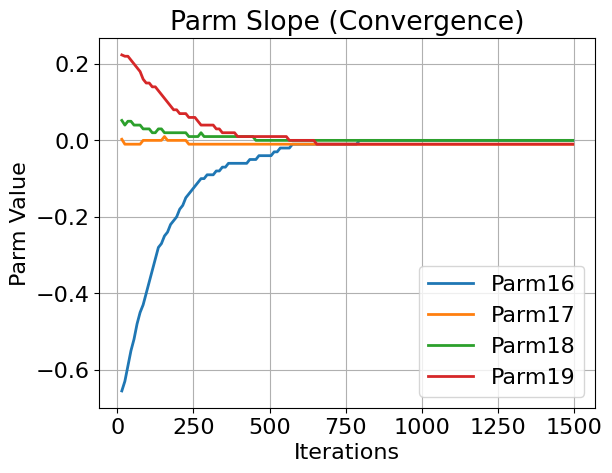

In [1692]:
# Get slopes
p16_slope = plot_bucket(parm16, 10, plot_it=False)
p17_slope = plot_bucket(parm17, 10, plot_it=False)
p18_slope = plot_bucket(parm18, 10, plot_it=False)
p19_slope = plot_bucket(parm19, 10, plot_it=False)
plt.plot(p0_bucket_x_vals[1:], p16_slope, lw=2, label='Parm16')
plt.plot(p0_bucket_x_vals[1:], p17_slope, lw=2, label='Parm17')
plt.plot(p0_bucket_x_vals[1:], p18_slope, lw=2, label='Parm18')
plt.plot(p0_bucket_x_vals[1:], p19_slope, lw=2, label='Parm19')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Parm Slope (Convergence)')
plt.legend()
plt.grid()
plt.show()

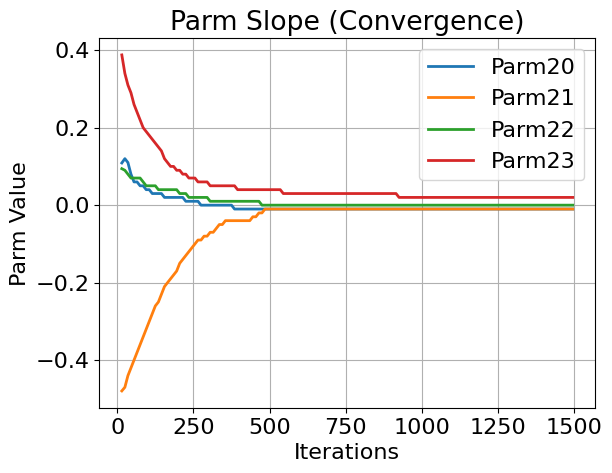

In [1693]:
# Get slopes
p20_slope = plot_bucket(parm20, 10, plot_it=False)
p21_slope = plot_bucket(parm21, 10, plot_it=False)
p22_slope = plot_bucket(parm22, 10, plot_it=False)
p23_slope = plot_bucket(parm23, 10, plot_it=False)
plt.plot(p0_bucket_x_vals[1:], p20_slope, lw=2, label='Parm20')
plt.plot(p0_bucket_x_vals[1:], p21_slope, lw=2, label='Parm21')
plt.plot(p0_bucket_x_vals[1:], p22_slope, lw=2, label='Parm22')
plt.plot(p0_bucket_x_vals[1:], p23_slope, lw=2, label='Parm23')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Parm Slope (Convergence)')
plt.legend()
plt.grid()
plt.show()

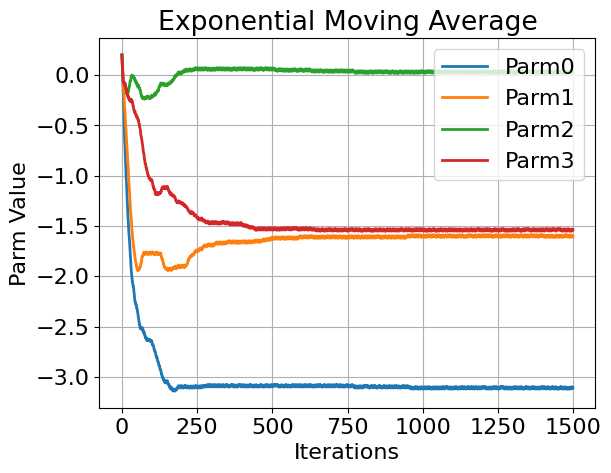

In [1638]:
# Get moving averages
parm0_mov_avg = exp_moving_average(parm0)
parm1_mov_avg = exp_moving_average(parm1)
parm2_mov_avg = exp_moving_average(parm2)
parm3_mov_avg = exp_moving_average(parm3)
plt.plot(parm0_mov_avg, lw=2, label='Parm0')
plt.plot(parm1_mov_avg, lw=2, label='Parm1')
plt.plot(parm2_mov_avg, lw=2, label='Parm2')
plt.plot(parm3_mov_avg, lw=2, label='Parm3')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Exponential Moving Average')
plt.legend()
plt.grid()
plt.show()

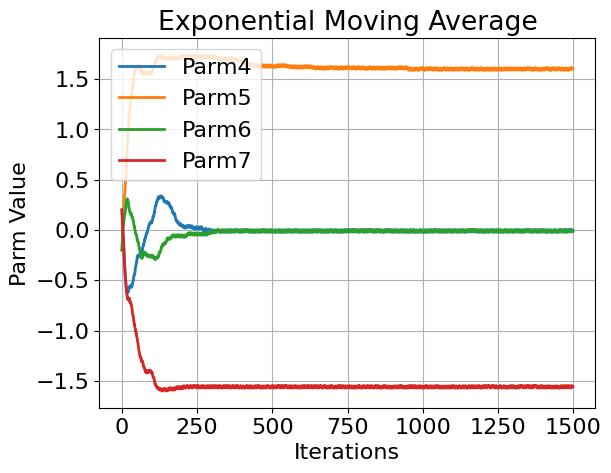

In [1639]:
# Get moving averages
parm4_mov_avg = exp_moving_average(parm4)
parm5_mov_avg = exp_moving_average(parm5)
parm6_mov_avg = exp_moving_average(parm6)
parm7_mov_avg = exp_moving_average(parm7)
plt.plot(parm4_mov_avg, lw=2, label='Parm4')
plt.plot(parm5_mov_avg, lw=2, label='Parm5')
plt.plot(parm6_mov_avg, lw=2, label='Parm6')
plt.plot(parm7_mov_avg, lw=2, label='Parm7')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Exponential Moving Average')
plt.legend()
plt.grid()
plt.show()

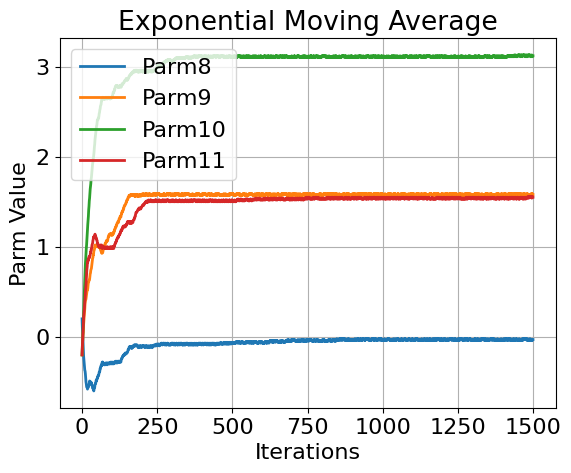

In [1640]:
# Get moving averages
parm8_mov_avg = exp_moving_average(parm8)
parm9_mov_avg = exp_moving_average(parm9)
parm10_mov_avg = exp_moving_average(parm10)
parm11_mov_avg = exp_moving_average(parm11)
plt.plot(parm8_mov_avg, lw=2, label='Parm8')
plt.plot(parm9_mov_avg, lw=2, label='Parm9')
plt.plot(parm10_mov_avg, lw=2, label='Parm10')
plt.plot(parm11_mov_avg, lw=2, label='Parm11')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Exponential Moving Average')
plt.legend()
plt.grid()
plt.show()

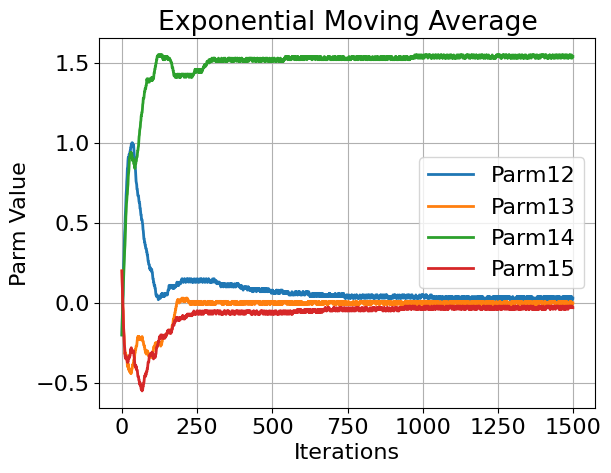

In [1641]:
# Get moving averages
parm12_mov_avg = exp_moving_average(parm12)
parm13_mov_avg = exp_moving_average(parm13)
parm14_mov_avg = exp_moving_average(parm14)
parm15_mov_avg = exp_moving_average(parm15)
plt.plot(parm12_mov_avg, lw=2, label='Parm12')
plt.plot(parm13_mov_avg, lw=2, label='Parm13')
plt.plot(parm14_mov_avg, lw=2, label='Parm14')
plt.plot(parm15_mov_avg, lw=2, label='Parm15')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Exponential Moving Average')
plt.legend()
plt.grid()
plt.show()

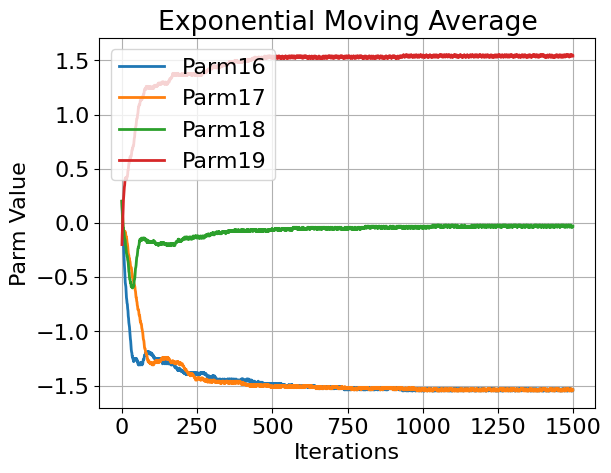

In [1642]:
# Get moving averages
parm16_mov_avg = exp_moving_average(parm16)
parm17_mov_avg = exp_moving_average(parm17)
parm18_mov_avg = exp_moving_average(parm18)
parm19_mov_avg = exp_moving_average(parm19)
plt.plot(parm16_mov_avg, lw=2, label='Parm16')
plt.plot(parm17_mov_avg, lw=2, label='Parm17')
plt.plot(parm18_mov_avg, lw=2, label='Parm18')
plt.plot(parm19_mov_avg, lw=2, label='Parm19')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Exponential Moving Average')
plt.legend()
plt.grid()
plt.show()

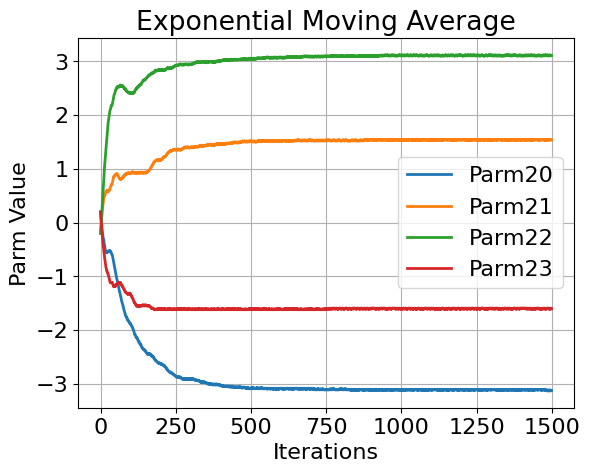

In [1643]:
# Get moving averages
parm20_mov_avg = exp_moving_average(parm20)
parm21_mov_avg = exp_moving_average(parm21)
parm22_mov_avg = exp_moving_average(parm22)
parm23_mov_avg = exp_moving_average(parm23)
plt.plot(parm20_mov_avg, lw=2, label='Parm20')
plt.plot(parm21_mov_avg, lw=2, label='Parm21')
plt.plot(parm22_mov_avg, lw=2, label='Parm22')
plt.plot(parm23_mov_avg, lw=2, label='Parm23')
#plt.plot(penalty_list, color='green', lw=2, label='Penalty')
plt.ylabel('Parm Value')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.title('Exponential Moving Average')
plt.legend()
plt.grid()
plt.show()

The true ground state energy is -18.0. As a metric for how well the VQE found the ground state energy, we will compute the relative difference between -18.0 and what we just achieved with VQE. This will be the metric of performance in the judging criteria, though it's important to note that it's not the only useful metric when working with VQE. Remember that the lower the relative error the higher you will score.

In [45]:
def rel_err(target, measured):
    return abs((target - measured) / target)

## Compute the relative error between the expected ground state energy and the VQE's output
#rel_error = rel_err(gs_energy, result.eigenvalue)

#print(f'Expected ground state energy: {gs_energy:.10f}')
#print(f'Computed ground state energy: {result.eigenvalue:.10f}')
#print(f'Relative error: {rel_error:.8f}')

In [ ]:
# Save the information. Create the latest entry
Run_num = Run_num + 1
Run_time = str(round(end - start, 2))
Run_data = (Run_num, \
            Run_time, \
            result.eigenvalue, \
            rel_error, \
            initial_points, \
            result.optimal_parameters)

# Package the data
optimal_params.append(Run_data)

In [84]:
# If you want to view the final state. Collect and graph the counts
# Sampler runs a job on the parameterized circuits
sampler = Sampler()
ansatz_measure = ansatz_opt.measure_all(inplace=False)
#ansatz_measure.draw()

job_viewcounts = sampler.run(
    circuits=[ansatz_measure],
    parameter_values=[result.optimal_parameters],
    parameters=[ansatz_opt.parameters])
job_result = job_viewcounts.result()
binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]
#print(job_result.quasi_dists)

NameError: name 'RTresult' is not defined

In [1162]:
Dist = job_result.quasi_dists[0]

# Unused Qubits
unused_qubits = [0, 6, 9, 15]

# Get a new
Dist_12 = {}

# Get a dictionary for the number of digits that are 1
numberOnes = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

# Excited Qubit Distribution
exq_dist = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

# Total probability for state
state_prob = [0]*13

# Plotting x and y from the quasi-distribution
x_counts = []
y_counts = []

# Build a 12 qubit equivalent result
for key in Dist:
    # Grab the value from the dictionary
    val = Dist[key]
    
    # Create the binary value 
    binary = bin(key)[2:]
    
    while len(binary) < 16:
        binary = "0"+binary
        
    binary16 = binary
    
    # Count all the 1s
    if val != 0:
        oneCount = binary.count("1")
        if oneCount > 12:
            print(binary)
        else:
            # Sum the total probablity for a state having 0 up, 1 up, ... 12 up
            state_prob[oneCount] += val
            if val > 0.0000000000000001:
                numberOnes[oneCount] = numberOnes[oneCount] + 1
    
    # Check if this has one of the unused qubits
    if (binary16[0] == "1" or binary16[6] == "1" or
        binary16[9] == "1" or binary16[15] == "1"):
        if val != 0:
            print("Value Should Be Zero!!! -- " + str(key)+ " : " +str(val))
    else:
        # Remove the unused bits from the string. Now we have a 12 bit number
        newbinary = binary[1:6]+binary[7:9]+binary[10:15]
        newint = int(newbinary, 2)
        
        # Set up the new quasi-distribution and the plotting values
        x_counts.append(newint)   # x plotting values
        y_counts.append(val)      # y plotting values
        Dist_12[newint] = val     # new distribution
        
        # Find all the excited qubits in this binary state
        excitedIndices = findexcitedstate(newbinary, '1')
        for excitedIdx in excitedIndices:
            exq_dist[excitedIdx] += 1
        
    
# Plot the final results of the count
plt.scatter(x0, np.real(y0))
plt.scatter(x1, np.real(y1))
plt.scatter(x_counts, y_counts)
plt.ylabel('Probability')
plt.xlabel('State (integer)')
plt.show()

# GARRETT: Excited isn't the write term. It is spin up vs spin down.
# Plot the distribution of the count of 1s
plot_histogram(numberOnes, title="Distribution of Excited Qubits in a State") # Should be mostly 6 excited

AttributeError: 'EstimatorResult' object has no attribute 'quasi_dists'

[0, 0, 0, 0.002432039312208041, 0.017557126945206065, 0.0815546138109319, 0.7612505189011122, 0.12457441697030175, 0.012097877416263537, 0.0005334066439765628, 0, 0, 0]


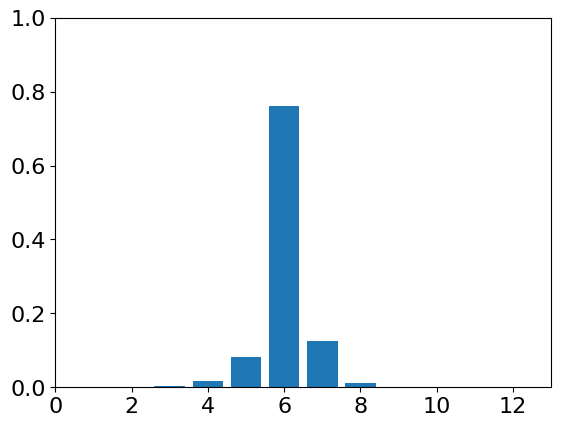

In [1160]:
x_axis_data = [i for i in range(13)]

plt.bar(x_axis_data, state_prob)
ax = plt.gca()
ax.set_xlim([0,13])
ax.set_ylim([0,1.0])
print(state_prob)

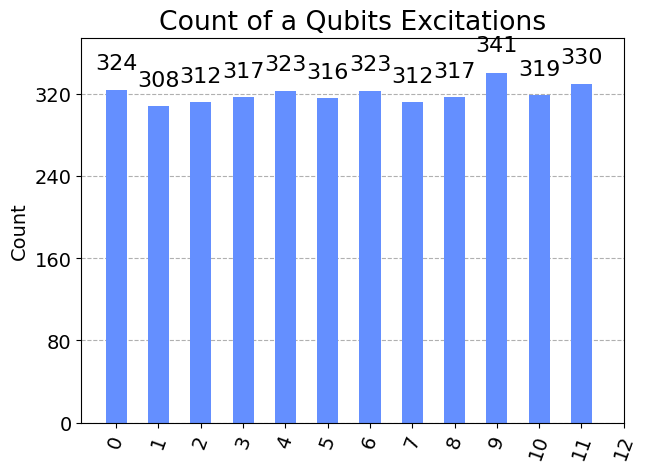

In [1161]:
# Plot distribution of excited qubits
plot_histogram(exq_dist, title="Count of a Qubits Excitations") # Should be uniformly distributed

In [ ]:
# Check out what the initial state is set to
testcircuit = QuantumCircuit(8)
# build initial state
testcircuit.h(range(0, 8, 2))
testcircuit.x(range(1, 9, 2))
testcircuit.cx(range(0, 7, 2), range(1, 8, 2))

testcircuit.measure_all()

testcircuit.draw()

In [ ]:
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

In [ ]:
# Use Aer's qasm_simulator
simulator = QasmSimulator()

# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit = transpile(testcircuit, guadalupe)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=5000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)
print("\nTotal count for 00 and 11 are:",counts)

plot_histogram(counts)

## Loop -- Collect Data Overnight

In [ ]:
# Create a loop and keep running tests overnight... Everything is in this block.

for testloop in range(3):
    # -----------------------------------------------------------------------------
    # Define instance of qiskit-terra's Estimator primitive
    estimator = Estimator([ansatz_opt], [ham_16])

    # Setup VQE algorithm
    custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result, initial_points = custom_vqe.compute_minimum_eigenvalue(ham_16)
    end = time()

    print(result)
    print(f'execution time (s): {end - start:.2f}')

    # -----------------------------------------------------------------------------
    # Plot the result
    plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    plt.show()

    # -----------------------------------------------------------------------------
    # Compute the relative error between the expected ground state energy and the VQE's output
    rel_error = rel_err(gs_energy, result.eigenvalue)

    print(f'Expected ground state energy: {gs_energy:.10f}')
    print(f'Computed ground state energy: {result.eigenvalue:.10f}')
    print(f'Relative error: {rel_error:.8f}')

    # -----------------------------------------------------------------------------
    # Save the information. Create the latest entry
    Run_num = Run_num + 1
    Run_time = str(round(end - start, 2))
    Run_data = (Run_num, \
                Run_time, \
                result.eigenvalue, \
                rel_error, \
                initial_points, \
                result.optimal_parameters)

    # Package the data
    optimal_params.append((initial_points, Run_data))

## Analyze Data Results

### 3-0 Error Mitigation (cloud simulator)
Use the estimator primitive to calculate the expectation value of noisy and not noisy simulations. Start without VQE, instead map out the parameters and the noise levels from there.

In [46]:
from qiskit import ClassicalRegister
cr = ClassicalRegister(2, 'c')

In [127]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator, 
                                Sampler as RuntimeSampler,
                                Options)
from qiskit import Aer

from qiskit_aer.noise import NoiseModel

# GARRETT: Added from above -- START
# IBMQ.save_account('46aead5c7b98c3015ee89c00fdc3a0b1a909af490abe29443c4880cd57af86021e09f4f03c61702feb2d75fd7c7e76ddf49cb68aef1916f8f91c9d29052b0263', overwrite=True)
#provider = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
#guadalupe = provider.get_backend("ibmq_guadalupe")
# GARRETT: Added from above -- END

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
#QiskitRuntimeService.save_account(channel="ibm_quantum", token='46aead5c7b98c3015ee89c00fdc3a0b1a909af490abe29443c4880cd57af86021e09f4f03c61702feb2d75fd7c7e76ddf49cb68aef1916f8f91c9d29052b0263', overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [128]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'ibmq_qasm_simulator'

#noise model based on real machine
guadalupe_noise_model = NoiseModel.from_backend(guadalupe)


Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


#### 3-0A Error Mitigation (cloud simulator). Create correction circuit
Calculate the noisy counts versus non noisy and create the correction matrix. Try integrating the correction matrix into rotation gates to correct for future layers.

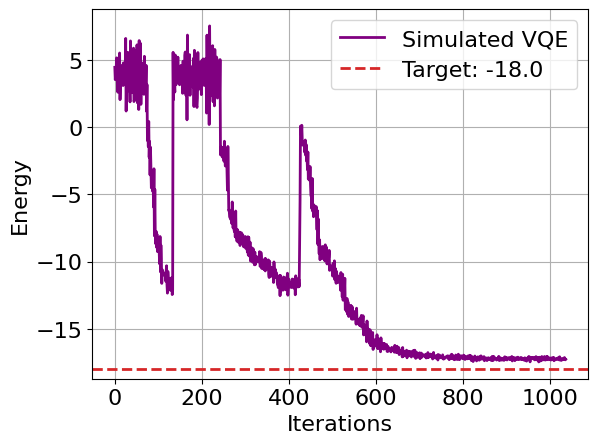

In [1774]:
%store -r intermediate_info_sim_backend
test_stor_info = intermediate_info_sim_backend

#RToptimized_parms.append((RTresult.optimal_parameters))
plt.plot(test_stor_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [31]:
# Analyze the results to determine the correction matirx that is needed.
correction_factors = [   [0, 0, 0, 0], #  0 -  0  1
                         [0, 0, 0, 0], #  1 -  1  2
                         [0, 0, 0, 0], #  2 -  2  3
                         [0, 0, 0, 0], #  3 -  3  4
                         [0, 0, 0, 0], #  4 -  4  5
                         [0, 0, 0, 0], #  5 -  5  6
                         [0, 0, 0, 0], #  6 -  6  7
                         [0, 0, 0, 0], #  7 -  7  8
                         [0, 0, 0, 0], #  8 -  8  9
                         [0, 0, 0, 0], #  9 -  9 10
                         [0, 0, 0, 0]] # 10 - 10 11

In [50]:
# Get the optimal parameters from an ideal sampler run
optimal_parameters = [ [-2.10613900e-03,  1.55408086e+00], \
                       [-9.67207287e-03, -1.53161721e+00], \
                       [-3.92545968e-02,  1.50280052e+00], \
                       [ 3.11831766e+00,  1.53385887e+00], \
                       [ 1.02886602e-02,  1.50171506e+00], \
                       [-4.45586989e-02, -1.53171757e+00], \
                       [ 1.53339082e-02,  4.90169015e-03], \
                       [ 1.56091517e+00, -1.74654711e-02], \
                       [-1.58644219e+00, -1.57206412e+00], \
                       [ 3.13870884e+00, -1.58844770e+00], \
                       [ 1.73282373e-02, -1.58503502e+00], \
                       [-4.73448953e-02,  1.57903999e+00] ]

In [244]:
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
mit_options = Options()
mit_options.resilience_level = 2
mit_options.resilience.extrapolator = 'LinearExtrapolator'
mit_options.optimization_level = 3
mit_options.simulator.noise_model = guadalupe_noise_model
#myshots = 0
#mit_options.execution.shots = myshots

In [ ]:
# Two Qubit Subset

# ----------------------------------------------------- #
# Select the qubits that this circuit will look at
q0 = 10
q1 = 11

# Build a measurement circuit, build an ideal circuit, and build a noisy circuit.
measure_baseline = QuantumCircuit(12)
measure_baseline.add_register(cr)
measure_baseline.measure(q0, 0)
measure_baseline.measure(q1, 1)

# Build the ideal circuit and noisy circuit -- they will be identical
ideal_circuit = QuantumCircuit(12)

# Build initial state
ideal_circuit.h(q0)
ideal_circuit.h(q1)

# Create circuit
j = 0
ideal_circuit.rz(Parameter('θ_' + str(j)), q0)
j += 1
ideal_circuit.ry(Parameter('θ_' + str(j)), q0)
j += 1
ideal_circuit.rz(Parameter('θ_' + str(j)), q1)
j += 1
ideal_circuit.ry(Parameter('θ_' + str(j)), q1)

# Create the bell state
ideal_circuit.h(q0)    # <-- Create bell state: 1/root(2)*(|01> + |10>)
ideal_circuit.x(q1)
ideal_circuit.cx(q0,q1)

# Measure the ideal circuit
ideal_circuit.add_register(cr)
ideal_circuit.measure(q0, 0)
ideal_circuit.measure(q1, 1)

# ----------------------------------------------------- #
# Create a copy for the noisy circuit
noisy_circuit = ideal_circuit.copy()

noisy_circuit.draw(fold=250)

In [ ]:
# Two Qubit Subset

# Now that we have three circuits made up. Transpile them for the guadalupe backend

# Force anstaz to be applied to qubits in the heavy hex. 
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ideal_transpiled = transpile(ideal_circuit, backend=guadalupe, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ideal_transpiled.count_ops())
print('number of parameters in the circuit:', ideal_transpiled.num_parameters)
ideal_transpiled.draw(fold=300)

In [ ]:
# Two Qubit Subset

# Calculate the optimal parameters for this run
initial_optimal = [optimal_parameters[q0], optimal_parameters[q1]]

# Convert the two lists into one for the sampler format
myoptimal = [optimal_parameters[q0][0], optimal_parameters[q0][1], optimal_parameters[q1][0], optimal_parameters[q1][1]]

In [ ]:
# Two Qubit Subset

# Run the circuit through sampler under ideal conditions
sampler = Sampler()

# Run sampler
job_viewcounts = sampler.run(
    circuits=[ideal_transpiled],
    parameter_values=[myoptimal],
    parameters=[ideal_transpiled.parameters])
job_result = job_viewcounts.result()
int_probs = job_result.quasi_dists[0]
binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]
binary_probs = binary_probs[0] # Have it just be the dictionary

In [ ]:
# Two Qubit Subset

# Run the circuit through sampler with noisy conditions
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    sampler = RuntimeSampler(session=session, options=mit_options)
    # Run sampler
    job_viewcounts = sampler.run(
        circuits=[ideal_transpiled],
        parameter_values=[myoptimal],
        parameters=[ideal_transpiled.parameters])
    job_result = job_viewcounts.result()
    int_noise_probs = job_result.quasi_dists[0]
    noise_binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]
    noise_binary_probs = noise_binary_probs[0] # Have it just be the dictionary

In [ ]:
# Two Qubit Subset

# Use the results to create the correction factors for these circuits
for key in int_probs:
    correction_factors[q0][key] = int_probs[key]/int_noise_probs[key]

In [ ]:
print(correction_factors)

In [ ]:
from math import sqrt

def normalize(state_list):
    #normalization = 0
    #for i in range(len(state_list)):
    #    normalization += state_list[i] * state_list[i]
    
    #normalization = 1/sqrt(normalization)
    normalization = sum(state_list) # Since these are counts we've already squared each state
    normalization = 1/normalization
    print(normalization)

    normal_state_list = [0]*len(state_list)
    for i in range(len(state_list)):
        normal_state_list[i] = normalization *state_list[i]
        
    return normal_state_list

In [ ]:
ideal = [0]*4
noisy = [0]*4
corrected = [0]*4

# Create the mitigated solution
for key in int_probs:
    ideal[key] = int_probs[key]
    noisy[key] = int_noise_probs[key]
    corrected[key] = noisy[key] * correction_factors[q0][key]

# Normalize the corrected state
corrected = normalize(corrected)

In [ ]:
# Plot the corrected results versus the ideal
states = [0, 1, 2, 3]
plt.scatter(states, ideal)
plt.scatter(states, noisy, marker='X')
plt.scatter(states, corrected, marker='*')
plt.ylabel('Quasi-probability')
plt.xlabel('Theta')
plt.legend(['Ideal', 'Noisy', 'Mitigated'], loc='upper right')
plt.title('Mitigated Results')

ax = plt.gca()
ax.set_xlim(right = 5.25)
#ax.set_ylim([-0.25, 1.5])
plt.show()

In [ ]:
# ------------------------------------------ #
# ------------------------------------------ #
# ------------------------------------------ #
# ------------------------------------------ #
# ------------------------------------------ #

In [51]:
# Get the optimal parameters for the entire circuit
myoptimal = [item for sublist in optimal_parameters for item in sublist]

In [ ]:
# Create all the keys for the input strings
all_keys = []
# Iterate through all the numbers, make them binary
for num in range(2**12):
    binary = bin(num)[2:]
    binary = binary.zfill(12)
    all_keys.append(binary)
        
# Create all the correction factors
all_correction_factors = [0]*(2**12)
# Iterate through all the numbers, multiple the factors together
for num in range(2**12):
    # Map the index for the C_0 correction factor
    idx0 = num % (4**1)
    # Map the index for the C_2 correction factor
    temp_mod = num % (4**2)
    idx2 = temp_mod // (4**1)
    # Map the index for the C_4 correction factor
    temp_mod = num % (4**3)
    idx4 = temp_mod // (4**2)
    # Map the index for the C_6 correction factor
    temp_mod = num % (4**4)
    idx6 = temp_mod // (4**3)
    # Map the index for the C_8 correction factor
    temp_mod = num % (4**5)
    idx8 = temp_mod // (4**4)
    # Map the index for the C_10 correction factor
    temp_mod = num % (4**6)
    idx10 = temp_mod // (4**5)
    
    # Create the combined correction factor based on the tensor product
    # C10 @ C8 @ C6 @ C4 @ C2 @ C0  -->  where @ is tensor product
    if num == 1242:
        print(correction_factors[0][idx0])
        print(correction_factors[2][idx2])
        print(correction_factors[4][idx4])
        print(correction_factors[6][idx6])
        print(correction_factors[8][idx8])
        print(correction_factors[10][idx10])
    all_correction_factors[num] = correction_factors[0][idx0] * correction_factors[2][idx2] * \
                                  correction_factors[4][idx4] * correction_factors[6][idx6] * \
                                  correction_factors[8][idx8] * correction_factors[10][idx10]
    

In [52]:
# Try the full circuit with all of the optimal points.
# Run the circuit through estimator under ideal conditions
estimator = Estimator()

# Run sampler
job_est = estimator.run(
    circuits=[ansatz_opt],
    parameter_values=[myoptimal],
    parameters=[ansatz_opt.parameters],
    observables=[ham_16])
job_est_result = job_est.result()
myvalue = job_est_result.values[0]
print('Ideal Conditions. Optimal Points = ' + str(myvalue))

Ideal Conditions. Optimal Points = -17.977625425722902


In [55]:
# List of noise amplifiers
noise_amps = ['TwoQubitAmplifier', 'CxAmplifier', 'LocalFoldingAmplifier', 'GlobalFoldingAmplifier']
extrapolators = ['LinearExtrapolator', 'QuadraticExtrapolator', 'CubicExtrapolator', 'QuarticExtrapolator']
noise_factors = [(1, 3, 5), (1, 2, 3), (1, 3, 5, 7), (1, 2, 3, 4), (1, 3, 5, 7, 9), (1, 2, 3, 4, 5)]

# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
mit_options = Options()
mit_options.resilience_level = 2
mit_options.resilience.noise_amplifier='LocalFoldingAmplifier'
                                    #                                Linear | Quad  | Cubic 
                                    # 'TwoQubitAmplifier'[Default] = -15.49  -15.49
                                    #'CxAmplifier' =                 -15.54  -15.60
                                    #'LocalFoldingAmplifier' =       -15.76  -16.01  -16.42 --> factors: (1, 3, 5, 7)
                                    #                                        -16.82  -18.00 --> factors: (1, 2, 3, 4) 
                                    #'GlobalFoldingAmplifier' =      -15.63  -15.97
                                    #                                                -16.79 --> factors: (1, 2, 3, 4)
mit_options.resilience.extrapolator = 'CubicExtrapolator'
mit_options.resilience.noise_factors = (1,2,3,4)
mit_options.optimization_level = 3
mit_options.simulator.noise_model = guadalupe_noise_model

# Create array
myval_array = [0]*3
rel_error_array = [0]*len(myval_array)
beat_cutoff = 0

# Get the start time
start = time()
for i in range(len(rel_error_array)):
    # No corrections other than the built in mitigation options
    with Session(service=service, backend=backend) as session:
        # Prepare primitive
        estimator = RuntimeEstimator(session=session, options=mit_options)
        # Run sampler
        job_est = estimator.run(
            circuits=[ansatz_opt],
            parameter_values=[myoptimal],
            parameters=[ansatz_opt.parameters],
            observables=[ham_16])
        job_est_result = job_est.result()
        myvalue = job_est_result.values[0]
        print('Noisy conditions. Optimal points built in mitigation = ' + str(myvalue))
    
    # Compute the relative error between the expected ground state energy and the measured
    myval_array[i] = myvalue
    rel_error_array[i] = rel_err(gs_energy, myvalue)
    
    if rel_error_array[i] < 0.01:
        beat_cutoff += 1

# Print the final tally
print('Met 1% benchmark '+str(beat_cutoff)+'/'+str(len(rel_error_array))+ ' or '+str(100*beat_cutoff/len(rel_error_array))+'% of the time')

# Print the execution time
end = time()
print(f'execution time (s): {end - start:.2f}')

Noisy conditions. Optimal points built in mitigation = -17.44
Noisy conditions. Optimal points built in mitigation = -17.82200000000003
Noisy conditions. Optimal points built in mitigation = -18.971999999999987
Met 1% benchmark 1/3 or 33.333333333333336% of the time
execution time (s): 488.84


In [ ]:
import numpy as np

# List when no shots are specified for the options
noshot_array = [-17.330,-17.577,-16.740,-17.041,-17.316,-16.640,-17.064,-17.603,-16.510,-17.064,-17.148,-17.604,-16.882,-17.262,-17.303,-18.154,-16.591,-17.467,-17.394,-17.004,-15.865,-17.038,-17.050,-17.441,-16.852]

# Set the list to take stats
stat_list = noshot_array

# Get the mean of the list 
res = np.mean(stat_list)
print("The mean without shots is : " + str(res))

# Variance of List
# using numpy.var()
res = np.var(stat_list)
print("The variance without shots is : " + str(res))

# ---------------------------------- #
# Look at the list with shots

# Set the list to take stats
stat_list = myval_array

# Get the mean of the list 
res = np.mean(stat_list)
print("The mean with shots is : " + str(res))

# Variance of List
# using numpy.var()
res = np.var(stat_list)
print("The variance with shots is : " + str(res))



In [ ]:
import warnings
# Plotting different ZNE extrapolations
x = [1,2,3,4,5]
y = [-13.8, -12.7, -12.15,-11.65, -11.18]
ylog = [13.8, 12.7, 12.15, 11.65, 11.18]

# Create the fitting polynomials
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p1 = np.poly1d(np.polyfit(x, y, 1))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p2 = np.poly1d(np.polyfit(x, y, 2))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p3 = np.poly1d(np.polyfit(x, y, 3))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p4 = np.poly1d(np.polyfit(x, y, 4))

# Get ready to create the graphs
xp = np.linspace(-1, 6, 100)

plt.plot(x, y, 'o', xp, p1(xp), '-', xp, p2(xp), '--', xp, p3(xp), '-.', xp, p4(xp), '-')
ax = plt.gca()
ax.set_xlim([0,6])
ax.set_ylim([-18,-10])
plt.show()

In [ ]:
# Create values for exponential fit
x = [1,2,3,4]#,5]
# Flip the y values for a more traditional looking exponential plot. And remove negative sign
# y = [-13.8, -12.7, -12.15,-11.65, -11.18]  # standard
y = [0.01, 11.65-11.18, 12.15-11.18, 12.7-11.18]#, 13.8-11.18]  # 5 points

## 4 points
#x = [1, 2, 3, 4]
#y = [0.01, 12.15-11.65, 12.7-11.65, 13.8-11.65]

# 3 points
#x = [1, 2, 3]
#y = [0.01, 12.7-12.15, 13.8-12.15]


# Get exponential fit
# Fit a weighted polynomial of degree 1 (a linear function) to the data
pexp = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))

# Convert the polynomial back into an exponential
a = np.exp(pexp[1])
b = pexp[0]
x_fitted_weighted = np.linspace(min(x)-1, max(x)+2, 100)
y_fitted_weighted = a * np.exp(b * x_fitted_weighted)

plt.plot(x, y, '.', x_fitted_weighted, y_fitted_weighted, '-')
ax = plt.gca()
ax.set_xlim([0,6])
ax.set_ylim([0,18])
plt.show()
print(y_fitted_weighted[-1]+11.18)

In [ ]:
,# REAL BACKEND!

# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService(channel='ibm_quantum')
backend = 'ibmq_guadalupe'

mit_options = Options()
mit_options.resilience_level = 2
mit_options.resilience.noise_amplifier='LocalFoldingAmplifier'
                                    #                                Linear | Quad  | Cubic 
                                    # 'TwoQubitAmplifier'[Default] = -15.49  -15.49
                                    #'CxAmplifier' =                 -15.54  -15.60
                                    #'LocalFoldingAmplifier' =       -15.76  -16.01  -16.42 --> factors: (1, 3, 5, 7)
                                    #                                        -16.82  -18.00 --> factors: (1, 2, 3, 4) 
                                    #'GlobalFoldingAmplifier' =      -15.63  -15.97
                                    #                                                -16.79 --> factors: (1, 2, 3, 4)
mit_options.resilience.extrapolator = 'CubicExtrapolator'
mit_options.resilience.noise_factors = (1, 2, 3, 4)
mit_options.optimization_level = 3
#mit_options.simulator.noise_model = guadalupe_noise_model

# Create array
rel_error_array = [0]*3
beat_cutoff = 0

# Get the start time
start = time()
for i in range(len(rel_error_array)):
    # No corrections other than the built in mitigation options
    with Session(service=service, backend=backend) as session:
        # Prepare primitive
        estimator = RuntimeEstimator(session=session, options=mit_options)
        # Run sampler
        job_est = estimator.run(
            circuits=[ansatz_opt],
            parameter_values=[myoptimal],
            parameters=[ansatz_opt.parameters],
            observables=[ham_16])
        job_est_result = job_est.result()
        myvalue = job_est_result.values[0]
        print('Noisy conditions. Optimal points built in mitigation = ' + str(myvalue))
    
    # Compute the relative error between the expected ground state energy and the measured
    rel_error_array[i] = rel_err(gs_energy, myvalue)
    
    if rel_error < 0.01:
        beat_cutoff += 1

# Print the final tally
print('Met 1% benchmark '+str(beat_cutoff)+'/'+str(len(rel_error_array))+ ' or '+str(100*beat_cutoff/len(rel_error_array))+'% of the time')

# Print the execution time
end = time()
print(f'execution time (s): {end - start:.2f}')

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, myvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {myvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

In [ ]:
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #
# ----------------------------------------------- #

## 3-1 Qiskit runtime (cloud simulator)

Next we demonstrate how to run VQE using [qiskit_ibm_runtime](https://github.com/Qiskit/qiskit-ibm-runtime) **which has different syntax from qiskit terra's runtime**. The qiskit_ibm_runtime module includes the same programming model as qiskit terra, but qiskit_ibm_runtime has access to a cloud simulator and more importantly the ibmq_guadalupe device. To learn more about qiskit_ibm_runtime check out these tutorials from the docs: [a tutorial on the estimator](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-estimator.ipynb) and [a tutorial on the sampler](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-sampler.ipynb).

We will use all the same VQE components we've built up so far, but the syntax for executing on the hardware is wrapped in [a session](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/sessions/) as shown in the following cells.

We first demonstrate running VQE with the cloud simulator backend to check everything is working correctly. This may take a few minutes. After running on the cloud simulator, we make a simple switch of backends to the real ibmq_guadalupe device to get the final result. Depending on how your VQE is setup, this may take a couple hours.

In [141]:
print(guadalupe_noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'id', 'x', 'cx', 'measure', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('sx', (7,)), ('sx', (8,)), ('sx', (9,)), ('sx', (10,)), ('sx', (11,)), ('sx', (12,)), ('sx', (13,)), ('sx', (14,)), ('sx', (15,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('x', (7,)), ('x', (8,)), ('x', (9,)), ('x', (10,)), ('x', (11,)), ('x', (12,)), ('x', (13,)), ('x', (14,)), ('x', (15,)), ('cx', (12, 15)), ('cx', (15, 12)), ('cx', (12, 10)), ('cx', (10, 12)), ('cx', (14, 13)

In [192]:
# Define a simple callback function
intermediate_info_sim_backend = []
params_list_sim = []
def callback_sim(value, params):
        intermediate_info_sim_backend.append(value)
        params_list_sim.append(params)
                
# Define list to store optimization results
RToptimized_parms = []
RTrun_num = 0

In [193]:
# Set up the test case

# Select the ansatz to test. 
#test_ansatz = ansatz1         # Single layer of Heis gates
#test_ansatz = ansatz         # Efficient SU2 ansatz
test_ansatz = ansatz_custom  # Open Science default custom ansatz

# Select optimizer and iteration limit
mymaxiter = 600
optimizer = SPSA(maxiter=mymaxiter)

# Select the Qiskit Runtime options
service = QiskitRuntimeService()
options = Options()
#options.resilience_level = 2
#options.resilience.extrapolator = 'LinearExtrapolator'
#options.optimization_level = 3
options.simulator.noise_model = guadalupe_noise_model
#options.execution.shots = 1024

In [184]:
# Select the description information
# ansatz descrition
if test_ansatz == ansatz:
    ansatz_type = 'EfficientSU2'
elif test_ansatz == ansatz_custom:
    ansatz_type = 'IBM_custom'
    
# optimizer info
optimizer_type = 'SPSA_'+str(mymaxiter)

# options info
resilience_type = 'level - ' + str(options.resilience_level) + ' extrapolator - ' + options.resilience.extrapolator

In [194]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session, options=options)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # Run algorithm
    RTresult, RTinitial_points = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')
winsound.Beep(325, 325)

execution time (s): 30180.35


In [195]:
minval = min(intermediate_info_sim_backend)
minidx = intermediate_info_sim_backend.index(minval)
print(str(minval) + ' : ' + str(minidx))
print(params_list_sim[minidx])
print(len(intermediate_info_sim_backend))

-15.283510725766426 : 1224
[-0.08367763  1.4726193  -0.09546887 -1.46191971 -0.14914017  1.39502457
  0.06986602 -1.65539214  0.09808901  1.46375021  0.12835742 -1.65110144
  0.07670867  0.10610745  1.48589594  0.10855675 -1.42598887 -1.6828342
 -0.04696212  1.32390146  0.28538655 -1.07248731  0.10763779  1.64080451]
1251


In [198]:
# Get the optimal parameters from an ideal sampler run
noisy_optimal_parameters =[-0.08367763,  1.4726193,  -0.09546887, -1.46191971, -0.14914017,  1.39502457,\
  0.06986602, -1.65539214,  0.09808901,  1.46375021,  0.12835742, -1.65110144,\
  0.07670867,  0.10610745,  1.48589594,  0.10855675, -1.42598887, -1.6828342,\
 -0.04696212,  1.32390146,  0.28538655, -1.07248731,  0.10763779,  1.64080451]

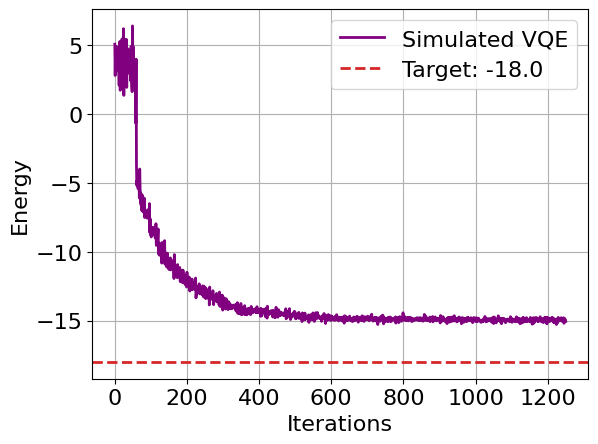

In [197]:
#RToptimized_parms.append((RTresult.optimal_parameters))
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, RTresult.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {RTresult.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

In [ ]:
# Save the information. Create the latest entry
RTrun_num = RTrun_num + 1
RTrun_time = str(round(end - start, 2))
RTdescription = 'ansantz: ' + ansatz_type + ' optimizer: ' + optimizer_type + ' resilience' + resilience_type
RTrun_data = (RTrun_num, \
              RTrun_time, \
              RTresult.eigenvalue, \
              rel_error, \
              RTinitial_points, \
              RTresult.optimal_parameters, \
              RTdescription)

RToptimized_parms.append(RTrun_data)

## 3-2 Qiskit runtime Real backend (ibmq_guadalupe)

If our `qiskit_ibm_runtime` code is working on the cloud simulator backend, we can simply change the backend to the ibmq_guadalupe to run on the real backend. This may take a couple hours. Your performance score will be determined by the calculated relative error between the true ground state energy of -18.0 and the measured energy from the real ibmq_guadalupe backend.

In [870]:
service = QiskitRuntimeService(channel='ibm_quantum')

backend = 'ibmq_guadalupe'

In [ ]:
# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

In [ ]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')

In [ ]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

###

## 3-3 Performance Score
Compute the relative error between the expected ground state energy and the VQE result.

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

## 4-1 Expectation Values from Sampler
Use a calibration matrix and see if it produces better results. Apply it to the Hamiltonian.

In [253]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import array_to_latex

#### Example of M3 -- Calculate Expecation Value from Counts

In [2]:
##########################################################
#      DELETE LATER!!!!                                  #
##########################################################
import numpy as np
from qiskit import *
from qiskit.providers.fake_provider import FakeAthens
import mthree

backend = FakeAthens()

ghz2 = QuantumCircuit(2)
ghz2.h(0)
ghz2.cx(0,1)
ghz2.measure_all()

trans_ghz2 = transpile(ghz2, backend)

ghz3 = QuantumCircuit(3)
ghz3.h(0)
ghz3.cx(0,1)
ghz3.cx(1,2)
ghz3.measure_all()

trans_ghz3 = transpile(ghz3, backend)

raw2 = backend.run(trans_ghz2, shots=4000).result().get_counts()
raw3 = backend.run(trans_ghz3, shots=4000).result().get_counts()

mit = mthree.M3Mitigation(backend)
mit.cals_from_system()

quasi2 = mit.apply_correction(raw2, [0,1], return_mitigation_overhead=True)
quasi3 = mit.apply_correction(raw3, [0,1,2], return_mitigation_overhead=True)

In [3]:
print('GHZ2:', quasi2.expval())
print('GHZ3:', quasi3.expval())

GHZ2: 0.979212241041101
GHZ3: 0.022031303342738562


### Expectation Value from the Estimator Primitive

In [1179]:
# Get the optimal parameters from an ideal sampler run
optimal_parameters = [ [-2.10613900e-03,  1.55408086e+00], \
                       [-9.67207287e-03, -1.53161721e+00], \
                       [-3.92545968e-02,  1.50280052e+00], \
                       [ 3.11831766e+00,  1.53385887e+00], \
                       [ 1.02886602e-02,  1.50171506e+00], \
                       [-4.45586989e-02, -1.53171757e+00], \
                       [ 1.53339082e-02,  4.90169015e-03], \
                       [ 1.56091517e+00, -1.74654711e-02], \
                       [-1.58644219e+00, -1.57206412e+00], \
                       [ 3.13870884e+00, -1.58844770e+00], \
                       [ 1.73282373e-02, -1.58503502e+00], \
                       [-4.73448953e-02,  1.57903999e+00] ]

# Get the optimal parameters for the entire circuit
myoptimal = [item for sublist in optimal_parameters for item in sublist]

manual_optimal = [      0,  0.5*pi,       0, -0.5*pi, \
                        0,  0.5*pi,      pi,  0.5*pi, \
                        0,  0.5*pi,       0, -0.5*pi, \
                        0,       0,  0.5*pi,       0, \
                  -0.5*pi, -0.5*pi,      pi, -0.5*pi, \
                        0, -0.5*pi,       0,  0.5*pi]

guess_optimal  = [      0,  0.5*pi,       0, -0.5*pi, \
                        0,  0.5*pi,      pi,  0.5*pi, \
                        0,  0.5*pi,       0, -0.5*pi, \
                        0,  0.5*pi,      pi,  0.5*pi, \
                        0,  0.5*pi,       0, -0.5*pi, \
                        0,  0.5*pi,      pi,  0.5*pi]

myoptimal = manual_optimal

## From noisy simulator before it crashed. Was at -12.45 and dropping.
#mysuboptimal = [ 0.24231992,  1.68490315,  0.0250384,  -1.60700237,  0.51819623,  1.12778329, \
# -0.31468827, -1.89689436,  0.20639106,  0.78417901, -0.06380105, -1.61617762, \
# -2.70918385, -0.12594397,  0.23921357, -0.32939637,  0.76361234,  1.07420753, \
# -0.39369891,  0.75065284, -0.02027266, -0.65080367, -0.07169551,  1.61398389] 
#myoptimal = mysuboptimal

In [113]:
%store -r myoptimal_noisy_asympt_parms

In [114]:
myoptimal = myoptimal_noisy_asympt_parms

In [ ]:
#GARRETT_HERE

In [201]:
myparms = []
for parms in parm_list:
    myparms.append(parms[-1])
print(myparms)

[3.2792723591334942, 4.936855045814291, -3.050203726884077, 1.6875287742244882, -3.262315457950664, -1.4123431069248984, 0.14146204199132195, -1.6777635095927683, 0.09387842739356997, 1.456499387007743, 3.231405251897651, -4.8308702807247546, -3.286022436784357, 0.06333238090696686, -4.500774747775511, -3.253579243871232, 1.728116613232012, 1.7996686463456093, 0.12345733155936135, 1.6327885440821144, 3.043799921862523, -4.821108042149907, -3.040660788463301, 4.833808635487591]


In [202]:
myoptimal = myparms

In [1848]:
print(myoptimal[0:4])
print(myoptimal[4:8])
print(myoptimal[8:12])
print(myoptimal[12:16])
print(myoptimal[16:20])
print(myoptimal[20:24])

[-0.0, 1.5707963267948966, -0.0, -1.5707963267948966]
[-0.0, 1.5707963267948966, -0.0, -1.5707963267948966]
[-0.0, 1.5707963267948966, -0.0, -1.5707963267948966]
[-0.0, 0.0, 1.5707963267948966, 0.0]
[-1.5707963267948966, -1.5707963267948966, 0.0, 1.5707963267948966]
[-3.141592653589793, 1.5707963267948966, 0.0, 1.5707963267948966]


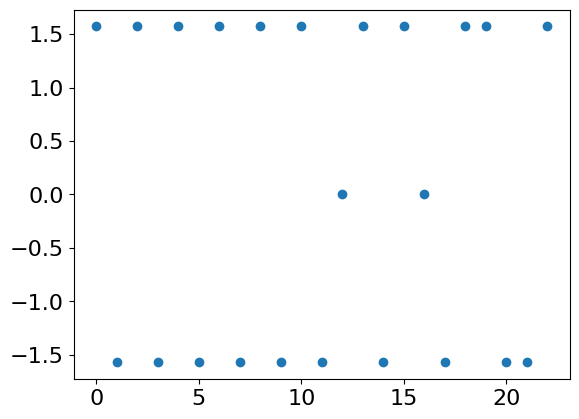

In [1785]:
opt_diff = [abs(myoptimal[i+1])-abs(myoptimal[i]) for i in range(len(myoptimal)-1)]
x_diff = [i for i in range(len(opt_diff))]
plt.scatter(x_diff, opt_diff)

In [115]:
# Build some more operators to run error mitigation on
# Build Z-Symmetry opterator
Z_16 = 4 * log_mapper.map(heis_16.z_symmetry_ops().simplify())

# Build Y-Symmetry opterator
Y_16 = 4 * log_mapper.map(heis_16.y_symmetry_ops().simplify())

# Build X-Symmetry opterator
X_16 = 4 * log_mapper.map(heis_16.x_symmetry_ops().simplify())

In [203]:
# Run a VQE session that tries to rotate correction factors
# so the optimal point under noisy conditions is closer to 
# the optimal point under ideal conditions.

# Get the optimal parameters for the entire circuit
#myoptimal = [item for sublist in optimal_parameters for item in sublist]

# Bind the parameters to the ansatz compiled circuit
myansatz = ansatz_opt.bind_parameters(myoptimal)
#myansatz = ansatz_opt.bind_parameters(noisy_optimal_parameters)

# View the compiled circuit
print('number and type of gates in the cirucit:', myansatz.count_ops())
print('number of parameters in the circuit:', myansatz.num_parameters)
#myansatz.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 60), ('sx', 36), ('cx', 6)])
number of parameters in the circuit: 0


In [204]:
test_ansatz.draw()

┌───┐┌─────────┐ ┌─────────┐ ┌───┐     
 q_0: ┤ H ├┤ Rz(θ_0) ├─┤ Ry(θ_1) ├─┤ H ├──■──
      ├───┤├─────────┤ ├─────────┤ ├───┤┌─┴─┐
 q_1: ┤ H ├┤ Rz(θ_2) ├─┤ Ry(θ_3) ├─┤ X ├┤ X ├
      ├───┤├─────────┤ ├─────────┤ ├───┤└───┘
 q_2: ┤ H ├┤ Rz(θ_4) ├─┤ Ry(θ_5) ├─┤ H ├──■──
      ├───┤├─────────┤ ├─────────┤ ├───┤┌─┴─┐
 q_3: ┤ H ├┤ Rz(θ_6) ├─┤ Ry(θ_7) ├─┤ X ├┤ X ├
      ├───┤├─────────┤ ├─────────┤ ├───┤└───┘
 q_4: ┤ H ├┤ Rz(θ_8) ├─┤ Ry(θ_9) ├─┤ H ├──■──
      ├───┤├─────────┴┐├─────────┴┐├───┤┌─┴─┐
 q_5: ┤ H ├┤ Rz(θ_10) ├┤ Ry(θ_11) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
 q_6: ┤ H ├┤ Rz(θ_12) ├┤ Ry(θ_13) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
 q_7: ┤ H ├┤ Rz(θ_14) ├┤ Ry(θ_15) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
 q_8: ┤ H ├┤ Rz(θ_16) ├┤ Ry(θ_17) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
 q_9: ┤ H ├┤ Rz(θ_18) ├┤ Ry(θ_19) ├┤ X ├┤ X ├
      ├───┤├──────────┤├──────────┤├───┤└───┘
q_10: ┤ H ├┤ Rz(θ_20) ├┤ Ry(θ_21) ├┤ H ├──■──
      ├───┤├──────────┤├──────────┤├───┤┌─┴─┐
q_11: ┤ H ├┤ Rz(θ_22) ├┤ Ry(θ_23) ├┤ X ├┤ X ├
      └───┘└──────────┘└──────────┘└───┘└───┘

In [205]:
ansatz_opt.draw(fold=250)

global phase: π
                                                                                                          
 ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────
                ┌─────────┐┌────┐┌─────────┐┌─────────┐ ┌────┐┌─────────────┐ ┌──────────┐┌────┐          
       q_0 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_0) ├─┤ √X ├┤ Rz(θ_1 + π) ├─┤ Rz(-π/2) ├┤ √X ├──■───────
                ├─────────┤├────┤├─────────┤├─────────┤ ├────┤├─────────────┤ └┬────────┬┘├────┤┌─┴─┐     
       q_1 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_2) ├─┤ √X ├┤ Rz(θ_3 + π) ├──┤ Rz(-π) ├─┤ √X ├┤ X ├─────
                ├─────────┤├────┤├─────────┤├─────────┤ ├────┤├─────────────┤ ┌┴────────┴┐├────┤└───┘     
       q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_4) ├─┤ √X ├┤ Rz(θ_5 + π) ├─┤ Rz(-π/2) ├┤ √X ├──■───────
                ├─────────┤├────┤├─────────┤├─────────┴┐├────┤├─────────────┴┐└┬────────┬┘├────┤  │  ┌───┐
      q_11 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_22) ├┤ √X ├┤ Rz(θ_23 + π) ├─┤ Rz(-π) ├─┤ √X ├──┼──┤ X ├
                ├─────────┤├────┤├─────────┤├─────────┬┘├────┤├─────────────┬┘ ├────────┤ ├────┤┌─┴─┐└─┬─┘
       q_3 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_6) ├─┤ √X ├┤ Rz(θ_7 + π) ├──┤ Rz(-π) ├─┤ √X ├┤ X ├──┼──
                └─────────┘└────┘└─────────┘└─────────┘ └────┘└─────────────┘  └────────┘ └────┘└───┘  │  
 ancilla_1 -> 6 ───────────────────────────────────────────────────────────────────────────────────────┼──
                ┌─────────┐┌────┐┌─────────┐┌──────────┐┌────┐┌──────────────┐┌──────────┐┌────┐       │  
      q_10 -> 7 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_20) ├┤ √X ├┤ Rz(θ_21 + π) ├┤ Rz(-π/2) ├┤ √X ├───────■──
                ├─────────┤├────┤├─────────┤├─────────┬┘├────┤├─────────────┬┘├──────────┤├────┤          
       q_4 -> 8 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_8) ├─┤ √X ├┤ Rz(θ_9 + π) ├─┤ Rz(-π/2) ├┤ √X ├──■───────
                └─────────┘└────┘└─────────┘└─────────┘ └────┘└─────────────┘ └──────────┘└────┘  │       
 ancilla_2 -> 9 ──────────────────────────────────────────────────────────────────────────────────┼───────
                ┌─────────┐┌────┐┌─────────┐┌──────────┐┌────┐┌──────────────┐ ┌────────┐ ┌────┐  │  ┌───┐
      q_9 -> 10 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_18) ├┤ √X ├┤ Rz(θ_19 + π) ├─┤ Rz(-π) ├─┤ √X ├──┼──┤ X ├
                ├─────────┤├────┤├─────────┤├──────────┤├────┤├──────────────┤ ├────────┤ ├────┤┌─┴─┐└─┬─┘
      q_5 -> 11 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_10) ├┤ √X ├┤ Rz(θ_11 + π) ├─┤ Rz(-π) ├─┤ √X ├┤ X ├──┼──
                ├─────────┤├────┤├─────────┤├──────────┤├────┤├──────────────┤┌┴────────┴┐├────┤└───┘  │  
      q_8 -> 12 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_16) ├┤ √X ├┤ Rz(θ_17 + π) ├┤ Rz(-π/2) ├┤ √X ├───────■──
                ├─────────┤├────┤├─────────┤├──────────┤├────┤├──────────────┤└┬────────┬┘├────┤┌───┐     
      q_7 -> 13 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_14) ├┤ √X ├┤ Rz(θ_15 + π) ├─┤ Rz(-π) ├─┤ √X ├┤ X ├─────
                ├─────────┤├────┤├─────────┤├──────────┤├────┤├──────────────┤┌┴────────┴┐├────┤└─┬─┘     
      q_6 -> 14 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(θ_12) ├┤ √X ├┤ Rz(θ_13 + π) ├┤ Rz(-π/2) ├┤ √X ├──■───────
                └─────────┘└────┘└─────────┘└──────────┘└────┘└──────────────┘└──────────┘└────┘          
ancilla_3 -> 15 ──────────────────────────────────────────────────────────────────────────────────────────

In [206]:
myansatz.draw(fold=250)

global phase: π
                                                                                                                                 
 ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                ┌─────────┐┌────┐┌─────────┐ ┌──────────────────────┐ ┌────┐ ┌──────────────────────┐┌──────────┐┌────┐          
       q_0 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(3.27927235913349) ├─┤ √X ├─┤ Rz(8.07844769940408) ├┤ Rz(-π/2) ├┤ √X ├──■───────
                ├─────────┤├────┤├─────────┤┌┴──────────────────────┤ ├────┤ ├─────────────────────┬┘└┬────────┬┘├────┤┌─┴─┐     
       q_1 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-3.28602243678436) ├─┤ √X ├─┤ Rz(4.9412612999354) ├──┤ Rz(-π) ├─┤ √X ├┤ X ├─────
                ├─────────┤├────┤├─────────┤├───────────────────────┤ ├────┤ ├─────────────────────┴┐┌┴────────┴┐├────┤└───┘     
       q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(0.123457331559361) ├─┤ √X ├─┤ Rz(4.77438119767191) ├┤ Rz(-π/2) ├┤ √X ├──■───────
                ├─────────┤├────┤├─────────┤├───────────────────────┤ ├────┤ ├─────────────────────┬┘└┬────────┬┘├────┤  │  ┌───┐
      q_11 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-3.25357924387123) ├─┤ √X ├─┤ Rz(4.8697092668218) ├──┤ Rz(-π) ├─┤ √X ├──┼──┤ X ├
                ├─────────┤├────┤├─────────┤└┬──────────────────────┤ ├────┤┌┴─────────────────────┴┐ ├────────┤ ├────┤┌─┴─┐└─┬─┘
       q_3 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(3.04379992186252) ├─┤ √X ├┤ Rz(-1.67951538856011) ├─┤ Rz(-π) ├─┤ √X ├┤ X ├──┼──
                └─────────┘└────┘└─────────┘ └──────────────────────┘ └────┘└───────────────────────┘ └────────┘ └────┘└───┘  │  
 ancilla_1 -> 6 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──
                ┌─────────┐┌────┐┌─────────┐┌────────────────────────┐┌────┐┌───────────────────────┐┌──────────┐┌────┐       │  
      q_10 -> 7 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(0.0633323809069669) ├┤ √X ├┤ Rz(-1.35918209418572) ├┤ Rz(-π/2) ├┤ √X ├───────■──
                ├─────────┤├────┤├─────────┤└┬──────────────────────┬┘├────┤└┬──────────────────────┤├──────────┤├────┤          
       q_4 -> 8 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(-3.0406607884633) ├─┤ √X ├─┤ Rz(7.97540128907738) ├┤ Rz(-π/2) ├┤ √X ├──■───────
                └─────────┘└────┘└─────────┘ └──────────────────────┘ └────┘ └──────────────────────┘└──────────┘└────┘  │       
 ancilla_2 -> 9 ─────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────
                ┌─────────┐┌────┐┌─────────┐ ┌──────────────────────┐ ┌────┐┌───────────────────────┐ ┌────────┐ ┌────┐  │  ┌───┐
      q_9 -> 10 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(3.23140525189765) ├─┤ √X ├┤ Rz(-1.68927762713496) ├─┤ Rz(-π) ├─┤ √X ├──┼──┤ X ├
                ├─────────┤├────┤├─────────┤┌┴──────────────────────┤ ├────┤└┬──────────────────────┤ ├────────┤ ├────┤┌─┴─┐└─┬─┘
      q_5 -> 11 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-3.05020372688408) ├─┤ √X ├─┤ Rz(4.82912142781428) ├─┤ Rz(-π) ├─┤ √X ├┤ X ├──┼──
                ├─────────┤├────┤├─────────┤└┬──────────────────────┤ ├────┤ ├──────────────────────┤┌┴────────┴┐├────┤└───┘  │  
      q_8 -> 12 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(0.09387842739357) ├─┤ √X ├─┤ Rz(4.59809204059754) ├┤ Rz(-π/2) ├┤ √X ├───────■──
                ├─────────┤├────┤├─────────┤┌┴──────────────────────┤ ├────┤ ├──────────────────────┤└┬────────┬┘├────┤┌───┐     
      q_7 -> 13 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(0.141462041991322) ├─┤ √X ├─┤ Rz(1.46382914399702) ├─┤ Rz(-π) ├─┤ √X ├┤ X ├─────
                ├─────────┤├────┤├─────────┤├───────────────────────┤ ├────┤ ├──────────────────────┤┌┴────────┴┐├────┤└─┬─┘     
      q_6 -> 14 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-3.26231545795066) ├─┤ √X ├─┤ Rz(1.72924954666489) ├┤ Rz(-π/2) ├┤ √X ├──■───────
                └─────────┘└────┘└─────────┘└───────────────────────┘ └────┘ └──────

In [207]:
# Try the full circuit with all of the optimal points.
# Run the circuit through estimator under ideal conditions
estimator = Estimator()

# Run sampler
job_est = estimator.run(
    circuits=[myansatz, myansatz, myansatz, myansatz],
    observables=[ham_16, Z_16, Y_16, X_16])
job_est_result = job_est.result()
myvalue = job_est_result.values[0]
print('Ideal Conditions. Optimal Points = ' + str(myvalue))

# Save off the estimator values as benchmarks for the following tests
val_benchmark = job_est_result.values[0]
Z_val_benchmark = job_est_result.values[1]
Y_val_benchmark = job_est_result.values[2]
X_val_benchmark = job_est_result.values[3]

# Print results
print('Total Expectation Value: ' + str(val_benchmark))
print('Z_16 Expectation Value: ' + str(Z_val_benchmark))
print('Y_16 Expectation Value: ' + str(Y_val_benchmark))
print('X_16 Expectation Value: ' + str(X_val_benchmark))

Ideal Conditions. Optimal Points = -17.573030329831465
Total Expectation Value: -17.573030329831465
Z_16 Expectation Value: -5.898507485273665
Y_16 Expectation Value: -5.785909987931913
X_16 Expectation Value: -5.8886128566258895


### M3 Expectation Value of Ideal Sampler

In [208]:
myansatz_X = myansatz.copy()

In [209]:
# Iterate through the q_layout, adding H gates to circuit
for q in q_layout:
    myansatz_X.h(q)

In [210]:
#myansatz_X.draw()

In [211]:
myansatz_Y = myansatz.copy()

In [212]:
# Iterate through the q_layout, adding S_dagger and H gates to circuit
for q in q_layout:
    myansatz_Y.sdg(q)
    myansatz_Y.h(q)

In [213]:
#myansatz_Y.draw()

#### Get Z Expectation Value

In [214]:
# Run for Z expectation values
# Sampler runs a job on the parameterized circuits
sampler = Sampler()
ansatz_measure_Z = myansatz.measure_all(inplace=False)
#ansatz_measure.draw()

job_viewcounts = sampler.run(circuits=[ansatz_measure_Z])
job_result = job_viewcounts.result()
binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]

In [215]:
#myraw = mynew_counts
myraw_ideal = binary_probs[0]

In [216]:
quasi_ideal = mthree.classes.QuasiDistribution(myraw_ideal)

In [217]:
# Create a function that takes a hamiltonian. Preferably the [type of whatever Z_16 is GARRETT!!!]
# and a mthree quasi dictionary and returns the expectation value.
def expval_from_pauli_sum(hamiltonian, m3_quasi):
    ham = hamiltonian.primitive.paulis.to_labels()
    myval = 0
    mystdev = 0

    # Loop through the labels calculating expectation of each one
    for pauli_str in ham:
        mytempval = m3_quasi.expval(pauli_str)
        #print('<'+pauli_str+'> = ' + str(mytempval))
        myval += mytempval

    return myval

In [218]:
print(mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}


In [219]:
# Create a function that takes a hamiltonian. Preferably the [type of whatever Z_16 is GARRETT!!!]
# and a mthree quasi dictionary and returns the expectation value.
def marginal_expval_from_pauli_sum(hamiltonian, rawcounts, mapping, marg_backend):
    ham = hamiltonian.primitive.paulis.to_labels()
    myval = 0
    mystdev = 0

    # Loop through the labels calculating expectation of each one
    for pauli_str in ham:
        marginal_counts, reduced_map = mthree.utils.marginal_distribution(rawcounts, pauli_str, mapping=mapping)

        mit = mthree.M3Mitigation(marg_backend)
        mit.cals_from_system(reduced_map)

        quasi_marg = mit.apply_correction(marginal_counts, reduced_map)

        mytempval = quasi_marg.expval()
        
        myval += mytempval

    return myval

In [220]:
# Get the expectation value of the ideal counts
ideal_val_Z = expval_from_pauli_sum(Z_16, quasi_ideal)
print('Ideal <Z_16> = ' + str(ideal_val_Z))

Ideal <Z_16> = -5.898507485273671


In [221]:
# Do some graphing ...

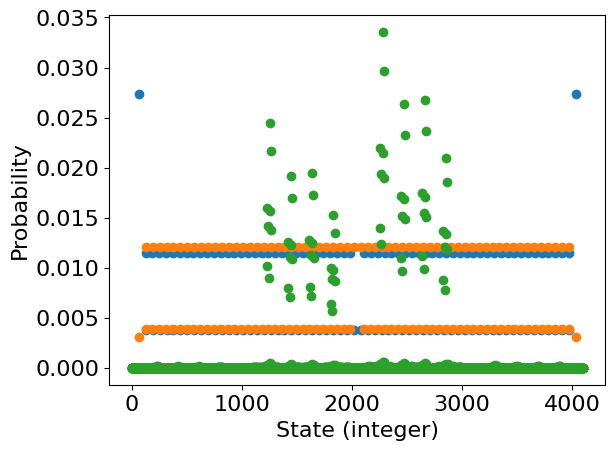

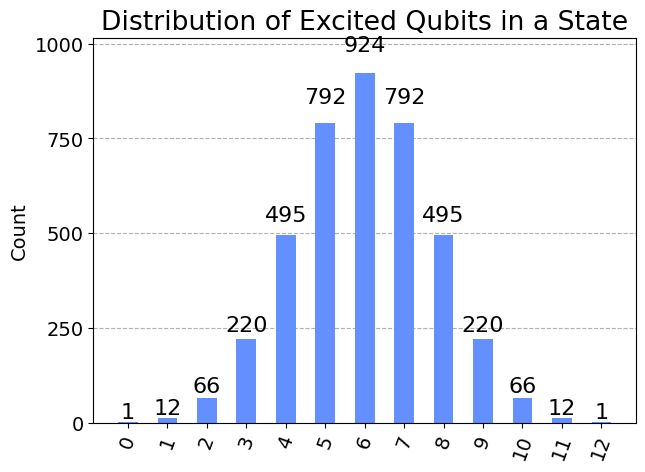

In [222]:
Dist = job_result.quasi_dists[0]

#Dist = quasi_guadalupe_Z

# Unused Qubits
unused_qubits = [0, 6, 9, 15]

# Get a new
Dist_12 = {}

# Get a dictionary for the number of digits that are 1
numberOnes = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

# Excited Qubit Distribution
exq_dist = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

# Total probability for state
state_prob = [0]*13

# Plotting x and y from the quasi-distribution
x_counts = []
y_counts = []

# Build a 12 qubit equivalent result
for key in Dist:
    # Grab the value from the dictionary
    val = Dist[key]
    
    # Create the binary value 
    binary = bin(key)[2:]
    #binary = key
    
    while len(binary) < 16:
        binary = "0"+binary
        
    binary16 = binary
    
    # Count all the 1s
    if val != 0:
        oneCount = binary.count("1")
        if oneCount > 12:
            print(binary)
        else:
            # Sum the total probablity for a state having 0 up, 1 up, ... 12 up
            state_prob[oneCount] += val
            if val > 0.0000000000000001:
                numberOnes[oneCount] = numberOnes[oneCount] + 1
    
    # Check if this has one of the unused qubits
    if (binary16[0] == "1" or binary16[6] == "1" or
        binary16[9] == "1" or binary16[15] == "1"):
        if val != 0:
            print("Value Should Be Zero!!! -- " + str(key)+ " : " +str(val))
    else:
        # Remove the unused bits from the string. Now we have a 12 bit number
        newbinary = binary[1:6]+binary[7:9]+binary[10:15]
        newint = int(newbinary, 2)
        
        # Set up the new quasi-distribution and the plotting values
        x_counts.append(newint)   # x plotting values
        y_counts.append(val)      # y plotting values
        Dist_12[newint] = val     # new distribution
        
        # Find all the excited qubits in this binary state
        excitedIndices = findexcitedstate(newbinary, '1')
        for excitedIdx in excitedIndices:
            exq_dist[excitedIdx] += 1
        
    
# Plot the final results of the count
plt.scatter(x0, np.real(y0))
plt.scatter(x1, np.real(y1))
plt.scatter(x_counts, y_counts)
plt.ylabel('Probability')
plt.xlabel('State (integer)')
plt.show()

# GARRETT: Excited isn't the write term. It is spin up vs spin down.
# Plot the distribution of the count of 1s
plot_histogram(numberOnes, title="Distribution of Excited Qubits in a State") # Should be mostly 6 excited

[1.6e-15, 2.9043e-12, 2.1948676e-09, 8.668600544999997e-07, 0.0001880019693721, 0.021108549822192187, 0.9500230278503787, 0.028350932644011863, 0.00032672084280029983, 1.8919380615999993e-06, 5.8660483e-09, 9.303800000000002e-12, 5.9e-15]


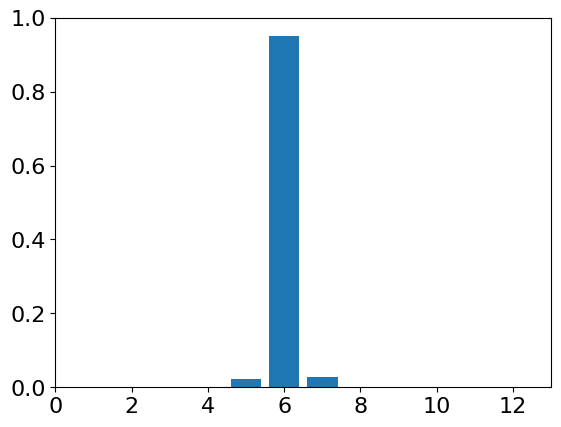

In [223]:
x_axis_data = [i for i in range(13)]

plt.bar(x_axis_data, state_prob)
ax = plt.gca()
ax.set_xlim([0,13])
ax.set_ylim([0,1.0])
print(state_prob)

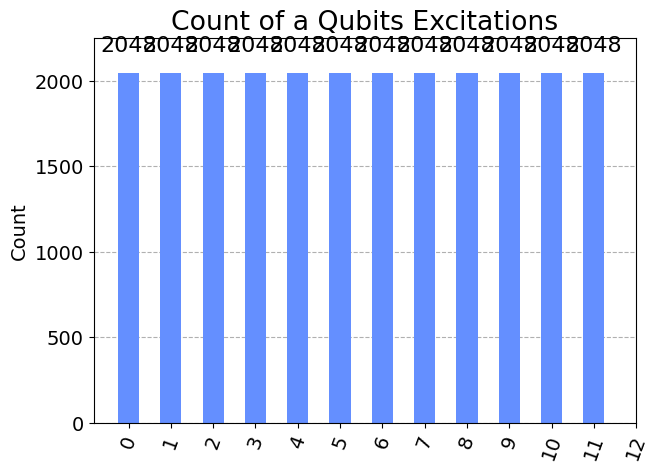

In [224]:
# Plot distribution of excited qubits
plot_histogram(exq_dist, title="Count of a Qubits Excitations") # Should be uniformly distributed

#### Get X Expectation Value

In [225]:
# Run for X expectation values
# Sampler runs a job on the parameterized circuits for the X expectation value
sampler = Sampler()
ansatz_measure_X = myansatz_X.measure_all(inplace=False)
#ansatz_measure_X.draw()

job_viewcounts = sampler.run(circuits=[ansatz_measure_X])
job_result = job_viewcounts.result()
binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]

In [226]:
#myraw = mynew_counts
myraw_ideal = binary_probs[0]

In [227]:
quasi_ideal = mthree.classes.QuasiDistribution(myraw_ideal)

In [228]:
# Get the expectation value of the ideal counts
ideal_val_X = expval_from_pauli_sum(Z_16, quasi_ideal)
print('Ideal <X_16> = ' + str(ideal_val_X))

Ideal <X_16> = -5.888612856625864


#### Get Y Expectation Value

In [229]:
# Run for Y expectation values
# Sampler runs a job on the parameterized circuits for the X expectation value
sampler = Sampler()
ansatz_measure_Y = myansatz_Y.measure_all(inplace=False)
#ansatz_measure_Y.draw()

job_viewcounts = sampler.run(circuits=[ansatz_measure_Y])
job_result = job_viewcounts.result()
binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]

In [230]:
#myraw = mynew_counts
myraw_ideal = binary_probs[0]

In [231]:
quasi_ideal = mthree.classes.QuasiDistribution(myraw_ideal)

In [232]:
# Get the expectation value of the ideal counts
ideal_val_Y = expval_from_pauli_sum(Z_16, quasi_ideal)
print('Ideal <Y_16> = ' + str(ideal_val_Y))

Ideal <Y_16> = -5.785909987931893


### M3 Expectation Value of Noisy Sampler

In [233]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'ibmq_qasm_simulator'

#noise model based on real machine
guadalupe_noise_model = NoiseModel.from_backend(guadalupe)

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


#### Get Z Expectation Value

In [234]:
noisy_backend = FakeGuadalupe()

In [235]:
# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
mit_options = Options()
mit_options.simulator.noise_model = guadalupe_noise_model

# Run the circuit through sampler with noisy conditions
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    sampler = RuntimeSampler(session=session, options=mit_options)
    # Run sampler
    job_viewcounts = sampler.run(circuits=[ansatz_measure_Z])
    job_result = job_viewcounts.result()
    binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]

In [236]:
#myraw = mynew_counts
myraw = binary_probs[0]

In [237]:
mit_q_layout = [0, 1, 2, 3, 5, 8, 6, 11, 14, 9, 13, 12, 10, 7, 4, 15]

In [238]:
# Use the M3 package to calculate the expectation value of from the above counts
mit_guadalupe = mthree.M3Mitigation(noisy_backend)
mit_guadalupe.cals_from_system(mit_q_layout)

quasi_guadalupe_Z = mit_guadalupe.apply_correction(counts=myraw, qubits=mit_q_layout)
quasi_guadalupe_nomit_Z = mthree.classes.QuasiDistribution(myraw)

In [239]:
# Get the expectation value of the mitigated guadalupe counts
guadalupe_mit_val_Z = expval_from_pauli_sum(Z_16, quasi_guadalupe_Z)
print('Mitigated   <Z_16> = ' + str(guadalupe_mit_val_Z))

# Get the expectation value of the unmitigated guadalupe counts
guadalupe_val_Z = expval_from_pauli_sum(Z_16, quasi_guadalupe_nomit_Z)
print('Unmitigated <Z_16> = ' + str(guadalupe_val_Z))

Mitigated   <Z_16> = -6.066858407888421
Unmitigated <Z_16> = -5.593034377481164


In [240]:
marg_Z = marginal_expval_from_pauli_sum(hamiltonian=Z_16, rawcounts=myraw, mapping=mapping, marg_backend=noisy_backend)
print('Mitigated <Z_16> = ' + str(marg_Z))

Mitigated <Z_16> = -6.201391638383729


#### Get X Expectation Value

In [241]:
# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
mit_options = Options()
mit_options.simulator.noise_model = guadalupe_noise_model

# Run the circuit through sampler with noisy conditions
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    sampler = RuntimeSampler(session=session, options=mit_options)
    # Run sampler
    job_viewcounts = sampler.run(circuits=[ansatz_measure_X])
    job_result = job_viewcounts.result()
    binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]

In [242]:
#myraw = mynew_counts
myraw = binary_probs[0]

In [243]:
mit_q_layout = [0, 1, 2, 3, 5, 8, 6, 11, 14, 9, 13, 12, 10, 7, 4, 15]

In [244]:
## Use the M3 package to calculate the expectation value of from the above counts
#mit_guadalupe = mthree.M3Mitigation(noisy_backend)
#mit_guadalupe.cals_from_system(mit_q_layout)

quasi_guadalupe_X = mit_guadalupe.apply_correction(counts=myraw, qubits=mit_q_layout)
quasi_guadalupe_nomit_X = mthree.classes.QuasiDistribution(myraw)

In [245]:
# Get the expectation value of the mitigated guadalupe counts
guadalupe_mit_val_X = expval_from_pauli_sum(Z_16, quasi_guadalupe_X)
print('Mitigated   <X_16> = ' + str(guadalupe_mit_val_X))

# Get the expectation value of the unmitigated guadalupe counts
guadalupe_val_X = expval_from_pauli_sum(Z_16, quasi_guadalupe_nomit_X)
print('Unmitigated <X_16> = ' + str(guadalupe_val_X))

Mitigated   <X_16> = -5.998392151246305
Unmitigated <X_16> = -5.542748775131836


In [246]:
marg_X = marginal_expval_from_pauli_sum(hamiltonian=Z_16, rawcounts=myraw, mapping=mapping, marg_backend=noisy_backend)
print('Marginal    <X_16> = ' + str(marg_X))

Marginal    <X_16> = -6.100005573279319


#### Get Y Expectation Value

In [247]:
# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
mit_options = Options()
mit_options.simulator.noise_model = guadalupe_noise_model

# Run the circuit through sampler with noisy conditions
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    sampler = RuntimeSampler(session=session, options=mit_options)
    # Run sampler
    job_viewcounts = sampler.run(circuits=[ansatz_measure_Y])
    job_result = job_viewcounts.result()
    binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]

In [248]:
#myraw = mynew_counts
myraw = binary_probs[0]

In [249]:
mit_q_layout = [0, 1, 2, 3, 5, 8, 6, 11, 14, 9, 13, 12, 10, 7, 4, 15]

In [250]:
## Use the M3 package to calculate the expectation value of from the above counts
#mit_guadalupe = mthree.M3Mitigation(noisy_backend)
#mit_guadalupe.cals_from_system(mit_q_layout)

quasi_guadalupe_Y = mit_guadalupe.apply_correction(counts=myraw, qubits=mit_q_layout)
quasi_guadalupe_nomit_Y = mthree.classes.QuasiDistribution(myraw)

In [251]:
# Get the expectation value of the mitigated guadalupe counts
guadalupe_mit_val_Y = expval_from_pauli_sum(Z_16, quasi_guadalupe_Y)
print('Mitigated   <Y_16> = ' + str(guadalupe_mit_val_Y))

# Get the expectation value of the unmitigated guadalupe counts
guadalupe_val_Y = expval_from_pauli_sum(Z_16, quasi_guadalupe_nomit_Y)
print('Unmitigated <Y_16> = ' + str(guadalupe_val_Y))

Mitigated   <Y_16> = -5.717363537276961
Unmitigated <Y_16> = -5.333058849186269


In [252]:
marg_Y = marginal_expval_from_pauli_sum(hamiltonian=Z_16, rawcounts=myraw, mapping=mapping, marg_backend=noisy_backend)
print('Marginal    <Y_16> = ' + str(marg_Y))

Marginal    <Y_16> = -5.830422727661052


In [253]:
marg_X+marg_Y+marg_Z

-18.1318199393241

In [254]:
guadalupe_mit_val_X+guadalupe_mit_val_Y+guadalupe_mit_val_Z

-17.782614096411688

In [255]:
print(rel_err(gs_energy, marg_X+marg_Y+marg_Z))
print(rel_err(gs_energy, guadalupe_mit_val_X+guadalupe_mit_val_Y+guadalupe_mit_val_Z))


0.007323329962449974
0.012076994643795105


### Real Hardware -- Guadalupe

In [1858]:
# Start service
service = QiskitRuntimeService(channel='ibm_quantum')

# Select a simulator backend
backend = 'ibmq_guadalupe'

#### Get X, Y, and Z Expectation Values

In [1859]:
# Real backend; needed for transpilation later on
guadalupe = provider.get_backend("ibmq_guadalupe")

noisy_backend = guadalupe # Actual guadalupe backend

In [ ]:
# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
#mit_options = Options()
#mit_options.simulator.noise_model = guadalupe_noise_model

# Run the circuit through sampler with noisy conditions
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    sampler = RuntimeSampler(session=session)#, options=mit_options)
    # Run sampler
    job_viewcounts = sampler.run(circuits=[ansatz_measure_X, ansatz_measure_Y, ansatz_measure_Z])
    job_result = job_viewcounts.result()
    binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]

ERROR - Connection to remote host was lost. - goodbye
ERROR - Connection to remote host was lost. - goodbye


In [ ]:
mit_q_layout = [0, 1, 2, 3, 5, 8, 6, 11, 14, 9, 13, 12, 10, 7, 4, 15]

In [ ]:
# Parse multiple counts from one sampler run

In [ ]:
# Use the M3 package to calculate the expectation value of from the above counts
mit_guadalupe = mthree.M3Mitigation(noisy_backend)
mit_guadalupe.cals_from_system(mit_q_layout)

# Array for printing info
XYZ = ['X', 'Y', 'Z']

# Loop through scaled circuits results calculating expectation values
real_mit_expval = [0]*3
real_expval = [0]*3
real_marg_expval = [0]*3
for index in range(len(binary_probs)):
    # each element of binary probs is a quasi-dist from sampler
    myraw = binary_probs[index]
    
    # Create corrected quasi distributions
    quasi_guadalupe = mit_guadalupe.apply_correction(counts=myraw, qubits=mit_q_layout)
    quasi_guadalupe_nomit = mthree.classes.QuasiDistribution(myraw)
    
    # Calculate expected values
    guadalupe_mit_val = expval_from_pauli_sum(Z_16, quasi_guadalupe)
    guadalupe_val = expval_from_pauli_sum(Z_16, quasi_guadalupe_nomit)
    marg_guadalupe_val = marginal_expval_from_pauli_sum(hamiltonian=Z_16, rawcounts=myraw, mapping=mapping, marg_backend=noisy_backend)
    
    # Place expected values in array
    real_mit_expval[index] = guadalupe_mit_val
    real_expval[index] = guadalupe_val
    real_marg_expval[index] = marg_guadalupe_val
    print('<'+XYZ[index]+'>   |   Mit    ' + str(round(guadalupe_mit_val, 4)) \
             + '           No mit  ' + str(round(guadalupe_val, 4)) \
             + '     Marginal Mit  ' + str(round(marg_guadalupe_val, 4)))

### Comparison of Expectation Values

In [1834]:
print('Relative Error of Z Expectation Value')
print('-----------------------------------------------')
print('Ideal Sampler             : ' + str(round(rel_err(Z_val_benchmark, ideal_val_Z)*100, 4)) + '    %')
print('Unmitigated Noisy Sampler : ' + str(round(rel_err(Z_val_benchmark, guadalupe_val_Z)*100, 4)) + ' %')
print('Mitigated Noisy Sampler   : ' + str(round(rel_err(Z_val_benchmark, guadalupe_mit_val_Z)*100, 4)) + ' %')
print('marg_Z Noisy Sampler      : ' + str(round(rel_err(Z_val_benchmark, marg_Z)*100, 4)) + ' %')

Relative Error of Z Expectation Value
-----------------------------------------------
Ideal Sampler             : 0.0    %
Unmitigated Noisy Sampler : 6.3379 %
Mitigated Noisy Sampler   : 1.3943 %
marg_Z Noisy Sampler      : 3.0669 %


In [1835]:
print('Relative Error of X Expectation Value')
print('-----------------------------------------------')
print('Ideal Sampler             : ' + str(round(rel_err(X_val_benchmark, ideal_val_X)*100, 4)) + '    %')
print('Unmitigated Noisy Sampler : ' + str(round(rel_err(X_val_benchmark, guadalupe_val_X)*100, 4)) + ' %')
print('Mitigated Noisy Sampler   : ' + str(round(rel_err(X_val_benchmark, guadalupe_mit_val_X)*100, 4)) + ' %')
print('marg_X Noisy Sampler      : ' + str(round(rel_err(X_val_benchmark, marg_X)*100, 4)) + ' %')

Relative Error of X Expectation Value
-----------------------------------------------
Ideal Sampler             : 0.0    %
Unmitigated Noisy Sampler : 7.0931 %
Mitigated Noisy Sampler   : 0.5391 %
marg_X Noisy Sampler      : 1.7373 %


In [1836]:
print('Relative Error of Y Expectation Value')
print('-----------------------------------------------')
print('Ideal Sampler             : ' + str(round(rel_err(Y_val_benchmark, ideal_val_Y)*100, 4)) + '    %')
print('Unmitigated Noisy Sampler : ' + str(round(rel_err(Y_val_benchmark, guadalupe_val_Y)*100, 4)) + ' %')
print('Mitigated Noisy Sampler   : ' + str(round(rel_err(Y_val_benchmark, guadalupe_mit_val_Y)*100, 4)) + ' %')
print('marg_Y Noisy Sampler      : ' + str(round(rel_err(Y_val_benchmark, marg_Y)*100, 4)) + ' %')

Relative Error of Y Expectation Value
-----------------------------------------------
Ideal Sampler             : 0.0    %
Unmitigated Noisy Sampler : 10.4368 %
Mitigated Noisy Sampler   : 4.0936 %
marg_Y Noisy Sampler      : 1.7946 %


In [1837]:
tot_ideal_val = ideal_val_Z + ideal_val_X + ideal_val_Y
tot_guad_val = guadalupe_val_Z + guadalupe_val_X + guadalupe_val_Y
tot_guad_mit_val = guadalupe_mit_val_Z + guadalupe_mit_val_X + guadalupe_mit_val_Y
tot_marg = marg_Z + marg_X + marg_Y

print('Relative Error of Total Expectation Value')
print('-----------------------------------------------')
print('Ideal Sampler             : ' + str(round(rel_err(val_benchmark, tot_ideal_val)*100, 4)) + '    %')
print('Unmitigated Noisy Sampler : ' + str(round(rel_err(val_benchmark, tot_guad_val)*100, 4)) + ' %')
print('Mitigated Noisy Sampler   : ' + str(round(rel_err(val_benchmark, tot_guad_mit_val)*100, 4)) + ' %')
print('Marg Noisy Sampler        : ' + str(round(rel_err(val_benchmark, tot_marg)*100, 4)) + ' %')

Relative Error of Total Expectation Value
-----------------------------------------------
Ideal Sampler             : 0.0    %
Unmitigated Noisy Sampler : 7.9559 %
Mitigated Noisy Sampler   : 0.72 %
Marg Noisy Sampler        : 1.0032 %


In [1838]:
print(tot_ideal_val)
print(tot_guad_val)
print(tot_guad_mit_val)
print(tot_marg)

# The Y value is the issue ... maybe the S-dagger is noisy.

-18.00000000000002
-16.567931262578277
-17.87039133266407
-18.180580720226494


In [1841]:
average_mit = 0.5*(tot_marg + tot_guad_mit_val)
print('Average Mitigation Noisy Sampler        : ' + str(round(rel_err(val_benchmark, average_mit)*100, 4)) + ' %')

Average Mitigation Noisy Sampler        : 0.1416 %


In [1842]:
# Store a bunch of values that might be nice to have later.
# Create extra variables to avoid having name conflicts and stepping on results.
tot_ideal_val_stored = tot_ideal_val
tot_guad_val_stored = tot_guad_val
tot_guad_mit_val_stored = tot_guad_mit_val
tot_marg_stored  = tot_marg
average_mit_stored = average_mit

# Store the total values
%store tot_ideal_val_stored
%store tot_guad_val_stored
%store tot_guad_mit_val_stored
%store tot_marg_stored
%store average_mit_stored

Stored 'tot_ideal_val_stored' (float)
Stored 'tot_guad_val_stored' (float)
Stored 'tot_guad_mit_val_stored' (float)
Stored 'tot_marg_stored' (float)
Stored 'average_mit_stored' (float)


In [985]:
x_bar_mit5 = x_bar_mit
y_bar_mit5 = y_bar_mit

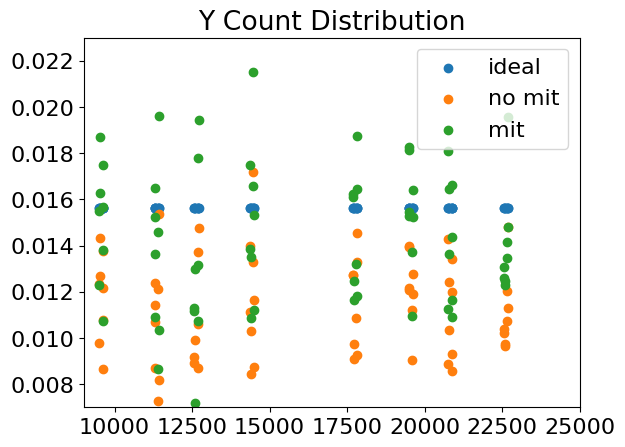

In [1155]:
x_bar_ideal = [int(binkey,2) for binkey in list(quasi_ideal.keys())]
y_bar_ideal = list(quasi_ideal.values())

x_bar_nomit = [int(binkey,2) for binkey in list(quasi_guadalupe_nomit_Y.keys())]
y_bar_nomit = list(quasi_guadalupe_nomit_Y.values())

x_bar_mit = [int(binkey,2) for binkey in list(quasi_guadalupe_Y.keys())]
y_bar_mit = list(quasi_guadalupe_Y.values())

plt.scatter(x_bar_ideal, y_bar_ideal, label='ideal')
plt.scatter(x_bar_nomit, y_bar_nomit, label='no mit')
plt.scatter(x_bar_mit, y_bar_mit, label='mit')
ax = plt.gca()
#ax.set_xlim([0, max(x_bar_ideal)])
ax.set_xlim([9000, 25000])
ax.set_ylim([0.007, 0.023])
ax.set_title('Y Count Distribution')
ax.legend()
plt.show()

In [1008]:
# Get average of the mitigated counts
mean_x_mit_Y = [i for i in range(2**16)]
mean_y_sum = [0]*(2**16)
mean_y_mit_Y = [0]*(2**16)

for i in range(len(x_bar_mit1)):
    mean_y_sum[x_bar_mit1[i]] += y_bar_mit1[i]
for i in range(len(x_bar_mit2)):
    mean_y_sum[x_bar_mit2[i]] += y_bar_mit2[i]
for i in range(len(x_bar_mit3)):
    mean_y_sum[x_bar_mit3[i]] += y_bar_mit3[i]
for i in range(len(x_bar_mit4)):
    mean_y_sum[x_bar_mit4[i]] += y_bar_mit4[i]
for i in range(len(x_bar_mit5)):
    mean_y_sum[x_bar_mit5[i]] += y_bar_mit5[i]

for i in range(len(mean_y_sum)):
    mean_y_mit_Y[i] = mean_y_sum[i]/5

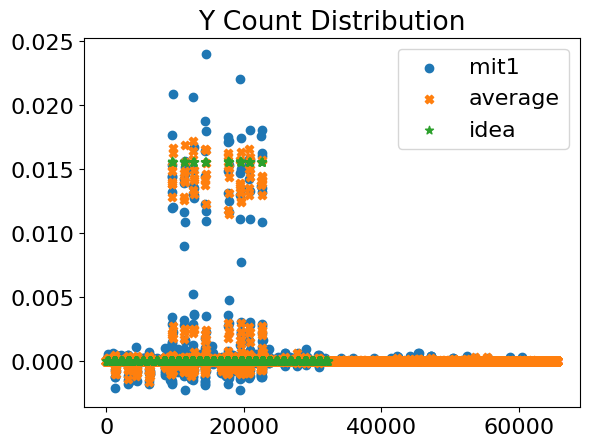

In [1026]:
plt.scatter(x_bar_mit1, y_bar_mit1, label='mit1')
#plt.scatter(x_bar_mit2, y_bar_mit2, label='mit2')
#plt.scatter(x_bar_mit3, y_bar_mit3, label='mit3')
#plt.scatter(x_bar_mit4, y_bar_mit4, label='mit4')
#plt.scatter(x_bar_mit5, y_bar_mit5, label='mit5')
plt.scatter(mean_x_mit_Y, mean_y_mit_Y, marker='X', label='average')
plt.scatter(x_bar_ideal, y_bar_ideal, marker='*', label='idea')
ax = plt.gca()
#ax.set_xlim([0, max(x_bar_ideal)])
#ax.set_xlim([9000, 25000])
#ax.set_ylim([0.007, 0.023])
ax.set_title('Y Count Distribution')
ax.legend()
plt.show()

In [1040]:
my_mean_Y_dict = {}
for i in range(len(mean_x_mit_Y)):
    basicbin = bin(mean_x_mit_Y[i])[2:].zfill(16)
    my_mean_Y_dict[basicbin] = mean_y_mit_Y[i]

In [849]:
def check_correlation(my_dist, q1, q2):
    # Check the conditional probabilities of q1 on q2
    # Calculate P(q1=|0> | q2=|0>), P(q1=|1> | q2=|0>), P(q1=|0> | q2=|1>), and P(q1=|1> | q2=|1>)
    
    # Setup probability array
    denominator = [0, 0]        # Denominator of conditional probability 
    numerator = [0, 0, 0, 0]    # Numerator of conditional probability
    cond_prob = [0, 0, 0, 0]    # [P(|0> | |0>), P(|1> | |0>), P(|0> | |1>), P(|1> | |1>)]
    
    # Loop through every element in the distribution
    for binkey in my_dist:
        # Get q1 and q2 value
        q1_val = binkey[q1]
        q2_val = binkey[q2]
        
        # Check conditionals
        if q2_val == '0':   # q2 is |0>
            denominator[0] += my_dist[binkey]         # q2 was zero 
            numerator[int(q1_val)] += my_dist[binkey] # Place in either position 0 or 1

        else: # q2 is |1>
            denominator[1] += my_dist[binkey]           #q2 was one
            numerator[int(q1_val)+2] += my_dist[binkey] # Place in either position 2 or 3
    
    # Calculate the conditional probabilities
    cond_prob[0] = numerator[0]/denominator[0] # P(0|0)
    cond_prob[1] = numerator[1]/denominator[0] # P(1|0)
    cond_prob[2] = numerator[2]/denominator[1] # P(0|1)
    cond_prob[3] = numerator[3]/denominator[1] # P(1|1)
    
    return cond_prob
    

In [850]:
print(q_layout)

[1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]


In [851]:
my_q1 = 0
my_q2 = 1

# Ideal
cond_01 = check_correlation(quasi_ideal, q_layout[my_q1], q_layout[my_q2])
cond_10 = check_correlation(quasi_ideal, q_layout[my_q2], q_layout[my_q1])

print('Conditional q0 given q1')
print(cond_01)
print('Conditional q1 given q0')
print(cond_10)

# Guadalupe mitigation
cond_01 = check_correlation(quasi_guadalupe_Y, q_layout[my_q1], q_layout[my_q2])
cond_10 = check_correlation(quasi_guadalupe_Y, q_layout[my_q2], q_layout[my_q1])

print('Mitigated Conditional q0 given q1')
print(cond_01)
print('Mitigated Conditional q1 given q0')
print(cond_10)

# Guadalupe no mitigation
cond_01 = check_correlation(quasi_guadalupe_nomit_Y, q_layout[my_q1], q_layout[my_q2])
cond_10 = check_correlation(quasi_guadalupe_nomit_Y, q_layout[my_q2], q_layout[my_q1])

print('No Mitigation Conditional q0 given q1')
print(cond_01)
print('No Mitigation Conditional q1 given q0')
print(cond_10)

Conditional q0 given q1
[3.003336554046113e-06, 0.9999969966634461, 0.9995652543047354, 0.0004347456952610761]
Conditional q1 given q0
[3.0036710414635528e-06, 0.9999969963289584, 0.999565302696916, 0.0004346973030812971]
Mitigated Conditional q0 given q1
[-0.007918504887008525, 1.007918504887008, 0.9798881906240688, 0.020111809375931378]
Mitigated Conditional q1 given q0
[-0.008141850036450637, 1.0081418500364503, 0.9804248434973457, 0.019575156502655934]
No Mitigation Conditional q0 given q1
[0.03967199573954697, 0.9603280042604517, 0.9700743546403074, 0.029925645359692388]
No Mitigation Conditional q1 given q0
[0.040850004503577925, 0.9591499954964221, 0.9709468754879614, 0.029053124512037728]


In [ ]:
def all_correlations():
    

In [644]:
cond_0 = check_correlation(quasi_ideal, q_layout[0], q_layout[2])
cond_1 = check_correlation(quasi_ideal, q_layout[2], q_layout[0])

print('Conditional q0 given q2')
print(cond_0)
print('Conditional q2 given q0')
print(cond_1)

Conditional q0 given q2
[0.24953753791843888, 0.25026168225379536, 0.24973802684223917, 0.25046275298552767]
Conditional q2 given q0
[0.24953753791843888, 0.24973802684223917, 0.25026168225379536, 0.25046275298552767]


## 4-2 Mitiq Error Correction Techniques
Use Mitiq open source software platform to try and improve the noise of the simulation. Start with the some near optimal points found by the ideal simulator and try to approach that expectation value.


In [401]:
# Import mitiq tools
from mitiq import zne

In [115]:
# Get the optimal parameters from an ideal sampler run
optimal_parameters = [ [-2.10613900e-03,  1.55408086e+00], \
                       [-9.67207287e-03, -1.53161721e+00], \
                       [-3.92545968e-02,  1.50280052e+00], \
                       [ 3.11831766e+00,  1.53385887e+00], \
                       [ 1.02886602e-02,  1.50171506e+00], \
                       [-4.45586989e-02, -1.53171757e+00], \
                       [ 1.53339082e-02,  4.90169015e-03], \
                       [ 1.56091517e+00, -1.74654711e-02], \
                       [-1.58644219e+00, -1.57206412e+00], \
                       [ 3.13870884e+00, -1.58844770e+00], \
                       [ 1.73282373e-02, -1.58503502e+00], \
                       [-4.73448953e-02,  1.57903999e+00] ]

# Get the optimal parameters for the entire circuit
myoptimal = [item for sublist in optimal_parameters for item in sublist]

In [27]:
# Build some more operators to run error mitigation on
# Build Z-Symmetry opterator
Z_16 = 4 * log_mapper.map(heis_16.z_symmetry_ops().simplify())

# Build Y-Symmetry opterator
Y_16 = 4 * log_mapper.map(heis_16.y_symmetry_ops().simplify())

# Build X-Symmetry opterator
X_16 = 4 * log_mapper.map(heis_16.x_symmetry_ops().simplify())

In [203]:
# Run a VQE session that tries to rotate correction factors
# so the optimal point under noisy conditions is closer to 
# the optimal point under ideal conditions.

# Get the optimal parameters for the entire circuit
myoptimal = [item for sublist in optimal_parameters for item in sublist]

# Bind the parameters to the ansatz compiled circuit
myansatz = ansatz_opt.bind_parameters(myoptimal)
#myansatz = ansatz_opt.bind_parameters(noisy_optimal_parameters)

# View the compiled circuit
print('number and type of gates in the cirucit:', myansatz.count_ops())
print('number of parameters in the circuit:', myansatz.num_parameters)
#myansatz.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 60), ('sx', 36), ('cx', 6)])
number of parameters in the circuit: 0


In [204]:
# Try the full circuit with all of the optimal points.
# Run the circuit through estimator under ideal conditions
estimator = Estimator()

# Run sampler
job_est = estimator.run(
    circuits=[myansatz, myansatz, myansatz, myansatz],
    observables=[ham_16, Z_16, Y_16, X_16])
job_est_result = job_est.result()
myvalue = job_est_result.values[0]
print('Ideal Conditions. Optimal Points = ' + str(myvalue))
print(job_est_result)

Ideal Conditions. Optimal Points = -17.977625425722902
EstimatorResult(values=array([-17.97762543,  -5.99584089,  -5.98881045,  -5.99297408]), metadata=[{}, {}, {}, {}])


### ZNE of Y Circuit Using M3
Focus on the <Y> for zero noise extrapolation because <Z> and <X> were very close to ideal

In [576]:
def measure_all_x(circuit, q_layout):
    # Create a copy of circuit
    mycirc = circuit.copy()
    
    # Rotate each qubit to x-basis with hadamard gate
    for q in q_layout:
        mycirc.h(q)
        
    # Measure all
    mycirc.measure_all()
    
    return mycirc

In [577]:
def measure_all_y(circuit, q_layout):
    # Create a copy of circuit
    mycirc = circuit.copy()
    
    # Rotate each qubit to y-basis with s_dagger then hadamard gate
    for q in q_layout:
        mycirc.sdg(q)
        mycirc.h(q)
        
    # Measure all
    mycirc.measure_all()
    
    return mycirc

In [603]:
def measure_all_z(circuit, q_layout):
    # Create a copy of circuit
    mycirc = circuit.copy()
    
    # Just measure qubits. Already in z basis
    # Measure all
    mycirc.measure_all()
    
    return mycirc

In [623]:
# Fold Gates
my_scale_factors = [1, 1.2, 1.5, 1.7, 2, 3, 4, 5, 7]
my_scale_circuits = [myansatz]

# Always skip the 1 scale factor
if my_scale_factors[0] != 1:
    print('HEY Leading Factor is always one!')
else:
    for sf in my_scale_factors[1:]:
        my_scale_circuits.append(zne.scaling.fold_global(myansatz, scale_factor = sf))

In [624]:
# Create a list of all the circuit with 
my_scale_circuits_measured = []
for circuit in my_scale_circuits:
    #my_scale_circuits_measured.append(circuit.measure_all(inplace=False))
    measured_circ = measure_all_y(circuit, q_layout)
    my_scale_circuits_measured.append(measured_circ)

In [625]:
# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
noise_options = Options()
noise_options.simulator.noise_model = guadalupe_noise_model
#noise_options.shots = 10000

# Get the start time
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    sampler = RuntimeSampler(session=session, options=noise_options)
    # Run sampler
    job_samp = sampler.run(circuits=my_scale_circuits_measured)
    job_samp_result = job_samp.result()

# Print the execution time
end = time()
print(f'execution time (s): {end - start:.2f}')

WARNING - Retrying (PostForcelistRetry(total=4, connect=3, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /jobs/cgk8k5tno270pfu8a3g0


execution time (s): 661.42


In [626]:
# Analyze the counts dictionaries with mitigation and without
binary_probs = [q.binary_probabilities() for q in job_samp_result.quasi_dists]

In [627]:
mit_q_layout = [0, 1, 2, 3, 5, 8, 6, 11, 14, 9, 13, 12, 10, 7, 4, 15]

In [628]:
# Use the M3 package to calculate the expectation value of from the above counts
mit_guadalupe = mthree.M3Mitigation(noisy_backend)
mit_guadalupe.cals_from_system(mit_q_layout)

# Loop through scaled circuits results calculating expectation values
scaled_mit_expval = [0]*len(my_scale_circuits_measured)
scaled_expval = [0]*len(my_scale_circuits_measured)
for index in range(len(binary_probs)):
    # each element of binary probs is a quasi-dist from sampler
    myraw = binary_probs[index]
    
    # Create corrected quasi distributions
    quasi_guadalupe = mit_guadalupe.apply_correction(counts=myraw, qubits=mit_q_layout)
    quasi_guadalupe_nomit = mthree.classes.QuasiDistribution(myraw)
    
    # Calculate expected values
    guadalupe_mit_val = expval_from_pauli_sum(Z_16, quasi_guadalupe)
    guadalupe_val = expval_from_pauli_sum(Z_16, quasi_guadalupe_nomit)
    
    # Place expected values in array
    scaled_mit_expval[index] = guadalupe_mit_val
    scaled_expval[index] = guadalupe_val
    if len(str(my_scale_factors[index])) == 1: 
        this_sf = str(my_scale_factors[index]) + '.0'
    else:
        this_sf = str(my_scale_factors[index])
    print('Scale: ' + this_sf + ' |  Mit    ' + str(round(guadalupe_mit_val, 4)) \
             + '        No mit  ' + str(round(guadalupe_val, 4)))

Scale: 1.0 |  Mit    -5.7747        No mit  -5.3832
Scale: 1.2 |  Mit    -5.7164        No mit  -5.3401
Scale: 1.5 |  Mit    -5.7221        No mit  -5.3445
Scale: 1.7 |  Mit    -5.7626        No mit  -5.3574
Scale: 2.0 |  Mit    -5.7329        No mit  -5.3498
Scale: 3.0 |  Mit    -5.7115        No mit  -5.3212
Scale: 4.0 |  Mit    -5.6789        No mit  -5.2949
Scale: 5.0 |  Mit    -5.7547        No mit  -5.3557
Scale: 7.0 |  Mit    -5.7616        No mit  -5.3663


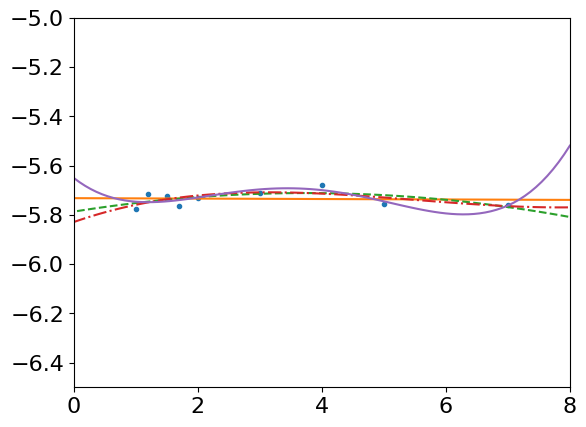

In [629]:
# Do some of my own extrapolation
import warnings
# Plotting different ZNE extrapolations
#x = [1,1,3,5]
x = my_scale_factors
#y = [-15.44421469, -14.90110905, -14.70538572]
#y = [guadalupe_mit_val_Y, guadalupe_mit_val_Y3, guadalupe_mit_val_Y5, guadalupe_mit_val_Y7] # Normal
y = scaled_mit_expval
#ylog = [15.44421469, 14.90110905, 14.70538572]

# Create the fitting polynomials
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p1 = np.poly1d(np.polyfit(x, y, 1))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p2 = np.poly1d(np.polyfit(x, y, 2))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p3 = np.poly1d(np.polyfit(x, y, 3))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p4 = np.poly1d(np.polyfit(x, y, 4))

# Get ready to create the graphs
xp = np.linspace(-1, 8, 100)

plt.plot(x, y, '.', xp, p1(xp), '-', xp, p2(xp), '--', xp, p3(xp), '-.', xp, p4(xp), '-')
ax = plt.gca()
ax.set_xlim([0,8])
ax.set_ylim([-6.5,-5])
plt.show()

In [398]:
#################################################
#################################################
#################################################
# CHECKING SUBMITTING MULTIPLE ITEMS TO SAMPLER #

In [378]:
# If you want to view the final state. Collect and graph the counts
# Sampler runs a job on the parameterized circuits
sampler = Sampler()
ansatz_measure = myansatz.measure_all(inplace=False)
#ansatz_measure.draw()

job_viewcounts = sampler.run(
    circuits=[ansatz_measure_Z, ansatz_measure_Y, ansatz_measure_X])
job_result = job_viewcounts.result()
#binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]
#print(job_result.quasi_dists)

In [388]:
binary_probs = [q.binary_probabilities() for q in job_result.quasi_dists]
binary_probs_Z = binary_probs[0]
binary_probs_Y = binary_probs[1]
binary_probs_X = binary_probs[2]

In [389]:
#myraw = mynew_counts
myraw_ideal = binary_probs_Z

In [390]:
quasi_ideal = mthree.classes.QuasiDistribution(myraw_ideal)

In [391]:
# Get the expectation value of the ideal counts
ideal_val_Z = expval_from_pauli_sum(Z_16, quasi_ideal)
print('Ideal <Z_16> = ' + str(ideal_val_Z))

Ideal <Z_16> = -5.995840894178908


In [392]:
#myraw = mynew_counts
myraw_ideal = binary_probs_Y

In [393]:
quasi_ideal = mthree.classes.QuasiDistribution(myraw_ideal)

In [394]:
# Get the expectation value of the ideal counts
ideal_val_Y = expval_from_pauli_sum(Z_16, quasi_ideal)
print('Ideal <Y_16> = ' + str(ideal_val_Y))

Ideal <Y_16> = -5.988810449509398


In [395]:
#myraw = mynew_counts
myraw_ideal = binary_probs_X

In [396]:
quasi_ideal = mthree.classes.QuasiDistribution(myraw_ideal)

In [397]:
# Get the expectation value of the ideal counts
ideal_val_X = expval_from_pauli_sum(Z_16, quasi_ideal)
print('Ideal <X_16> = ' + str(ideal_val_X))

Ideal <X_16> = -5.99297408203456


In [357]:
#myraw = mynew_counts
myraw = binary_probs_Z

In [358]:
mit_q_layout = [0, 1, 2, 3, 5, 8, 6, 11, 14, 9, 13, 12, 10, 7, 4, 15]

In [359]:
## Use the M3 package to calculate the expectation value of from the above counts
mit_guadalupe = mthree.M3Mitigation(noisy_backend)
mit_guadalupe.cals_from_system(mit_q_layout)

quasi_guadalupe = mit_guadalupe.apply_correction(counts=myraw, qubits=mit_q_layout)
quasi_guadalupe_nomit = mthree.classes.QuasiDistribution(myraw)

In [360]:
# Get the expectation value of the mitigated guadalupe counts
guadalupe_mit_val_Y = expval_from_pauli_sum(Z_16, quasi_guadalupe)
print('Mitigated   <Y_16> = ' + str(guadalupe_mit_val_Y))

# Get the expectation value of the unmitigated guadalupe counts
guadalupe_val_Y = expval_from_pauli_sum(Z_16, quasi_guadaluple_nomit)
print('Unmitigated <Y_16> = ' + str(guadalupe_val_Y))

Mitigated   <Y_16> = -5.709401785070727
Unmitigated <Y_16> = -5.51700813836913


In [ ]:
############################################################
############################################################
############################################################
############################################################
############################################################
############################################################
#                    END OF M3 WORK                        #

In [205]:
# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
noise_options = Options()
noise_options.simulator.noise_model = guadalupe_noise_model

# Get the start time
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    estimator = RuntimeEstimator(session=session, options=noise_options)
    # Run sampler
    job_est = estimator.run(
        circuits=[myansatz, myansatz, myansatz],
        observables=[Z_16, Y_16, X_16])
    job_est_result = job_est.result()
    myvalue = job_est_result.values[0]
    print('Noisy conditions. No ZNE mitigation, just TREX = ' + str(myvalue))

# Print the execution time
end = time()
print(f'execution time (s): {end - start:.2f}')


Noisy conditions. No ZNE mitigation, just TREX = -5.112537226096513
execution time (s): 39.19


In [206]:
job_est_result

EstimatorResult(values=array([-5.11253723, -5.00811508, -5.34138681]), metadata=[{'variance': 19.83704122733552, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 19.909864051102794, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 19.665149130326245, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}])

In [207]:
import mitiq
#zne.scaling.fold_gates_at_random
@mitiq.zne.zne_decorator()
def executor(circuit_to_run):#, obs_to_measure):
    # Create the service with the guadalupe noise model. 
    # Do not include qiskit mitigation. Other than defualt (TREX I think?)
    service = QiskitRuntimeService()
    noise_options = Options()
    noise_options.simulator.noise_model = guadalupe_noise_model

    obs_to_measure = Z_16
    
    # Get the start time
    start = time()
    with Session(service=service, backend=backend) as session:
        # Prepare primitive
        estimator = RuntimeEstimator(session=session, options=noise_options)
        # Run sampler
        job_est = estimator.run(
            circuits=[circuit_to_run],
            observables=[obs_to_measure])
        job_est_result = job_est.result()
        myvalue = job_est_result.values[0]
        #print('Noisy conditions. No built in mitigation except TREX = ' + str(myvalue))
        
    # Print the execution time
    end = time()
    #print(f'execution time (s): {end - start:.2f}')
    
    # Return the expectation value
    return myvalue

In [208]:
# Local fold gates at random
my_scale_factors = [1, 1.2, 1.5, 1.7, 2, 3, 4, 5,]
locFold1_2 = zne.scaling.fold_gates_at_random(myansatz, scale_factor=1.2)
locFold1_5 = zne.scaling.fold_gates_at_random(myansatz, scale_factor=1.5)
locFold1_7 = zne.scaling.fold_gates_at_random(myansatz, scale_factor=1.7)
locFold2 = zne.scaling.fold_gates_at_random(myansatz, scale_factor=2)
locFold3 = zne.scaling.fold_gates_at_random(myansatz, scale_factor=3)
locFold4 = zne.scaling.fold_gates_at_random(myansatz, scale_factor=4)
locFold5 = zne.scaling.fold_gates_at_random(myansatz, scale_factor=5)

# Infinite approx
locFold25 = zne.scaling.fold_gates_at_random(myansatz, scale_factor=25)

In [135]:
# Global fold gates
globFold3 = zne.scaling.fold_global(myansatz, scale_factor=3)
globFold5 = zne.scaling.fold_global(myansatz, scale_factor=5)
globFold7 = zne.scaling.fold_global(myansatz, scale_factor=7)
print('number and type of gates in the global fold x 3:', globFold3.count_ops())
print('number and type of gates in the cirucit:', myansatz.count_ops())

number and type of gates in the global fold x 3: OrderedDict([('rz', 180), ('sx', 72), ('sxdg', 36), ('cx', 18)])
number and type of gates in the cirucit: OrderedDict([('rz', 60), ('sx', 36), ('cx', 6)])


In [213]:
# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
noise_options = Options()
noise_options.simulator.noise_model = guadalupe_noise_model
#noise_options.shots = 10000

# Get the start time
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    estimator = RuntimeEstimator(session=session, options=noise_options)
    # Run sampler
    job_est = estimator.run(
        circuits=[myansatz, locFold1_2, locFold1_5, locFold1_7, locFold2, locFold3, locFold4, locFold5],
        observables=[Z_16, Z_16, Z_16, Z_16, Z_16, Z_16, Z_16, Z_16])
    job_est_result = job_est.result()
    myvalue = job_est_result.values[0]
    print('Noisy conditions. No ZNE mitigation, just TREX = ' + str(myvalue))

# Print the execution time
end = time()
print(f'execution time (s): {end - start:.2f}')


Noisy conditions. No ZNE mitigation, just TREX = -5.117896922657346
execution time (s): 113.08


In [214]:
job_est_result

EstimatorResult(values=array([-5.11789692, -4.94705329, -5.13322999, -4.91027468, -4.96516625,
       -4.92330015, -4.8397969 , -4.90706944]), metadata=[{'variance': 19.93983040203575, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 19.942138000265697, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 19.90384445934972, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 19.958237171673336, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 19.99196362603598, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 19.94684504756102, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192},

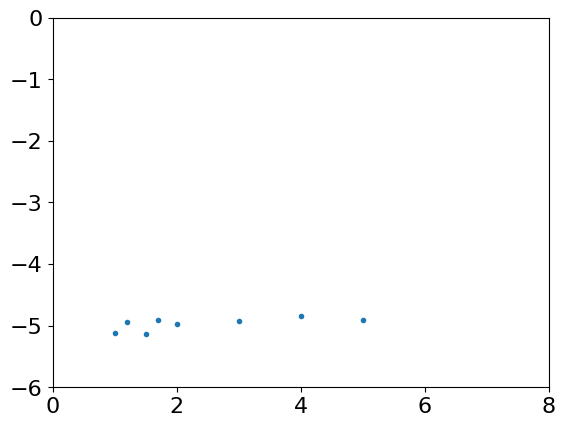

In [216]:
# Do some of my own extrapolation
import warnings
# Plotting different ZNE extrapolations
#x = [1,3,5,7]
x = my_scale_factors
#y = [-15.44421469, -14.90110905, -14.70538572]
y = job_est_result.values.tolist()
#ylog = [15.44421469, 14.90110905, 14.70538572]

# Create the fitting polynomials
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p1 = np.poly1d(np.polyfit(x, y, 1))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p2 = np.poly1d(np.polyfit(x, y, 2))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p3 = np.poly1d(np.polyfit(x, y, 3))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p4 = np.poly1d(np.polyfit(x, y, 4))

# Get ready to create the graphs
xp = np.linspace(-1, 6, 100)

plt.plot(x, y, '.')#, xp, p1(xp), '-', xp, p2(xp), '--', xp, p3(xp), '-.', xp, p4(xp), '-')
ax = plt.gca()
ax.set_xlim([0,8])
ax.set_ylim([-6,-0])
plt.show()

In [133]:
# Try some of mitiq's zne features --> See online example for original source
from functools import partial

# Random local folding applied to two-qubit gates
random_state = np.random.RandomState(0)
noise_scaling_function = partial(zne.scaling.fold_gates_at_random, 
                                 #fidelities= {"single": 1.0}, # Avoid folding single qubit gates
                                 random_state=random_state    # Useful to get reproducible results
                                )

# Exponential fit with scale factors [1,2,3]
factory = zne.inference.ExpFactory(scale_factors=[1,1.2,1.4,1.6,1.8,3], asymptote=-13.5)

# Run mitiq zero noise extrapolation
zne_value = zne.execute_with_zne(
    circuit=myansatz,
    executor=executor,
    observable=None,
    factory=factory,
    scale_noise=noise_scaling_function,
    #num_to_average=1,
)

print(zne_value)
winsound.Beep(325, 325)

-16.42804389943764


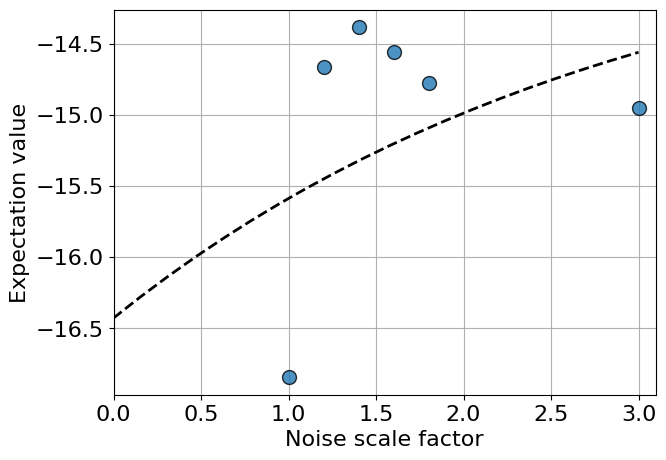

In [134]:
_ = factory.plot_fit()

In [ ]:
noise_val = executor(myansatz)
print(noise_val)

In [ ]:
noise_val_list = [0]*30
for i in range(len(noise_val_list)):
    noise_val_list[i] = executor(myansatz)
    print(noise_val_list[i])
    
# Mean of list
print(np.mean(noise_val_list))

In [ ]:
noise_val_list3 = [item for item in noise_val_list2]
for item in noise_val_list:
    noise_val_list3.append(item)
print(len(noise_val_list3))
print(np.mean(noise_val_list3))
print(rel_err(gs_energy, np.mean(noise_val_list3))*100)

In [ ]:
# noise_val_list2 is a copy of the 1st iteration of the noise_val_list data
# Mean of list
move_average = [0]*(len(noise_val_list3)-1)
total = 0
for i in range(len(move_average)):
    total += noise_val_list3[i]
    move_average[i] = total/(i+1)
    
# Plot the moving average
x = [i for i in range(len(move_average))]
x2 = [i for i in range(len(noise_val_list3))]
plt.plot(x, move_average, 'x', x2, noise_val_list3, 'o')
plt.show()


In [ ]:
zne_value = zne.execute_with_zne(myansatz, executor)

In [ ]:
# Benchmark Cell: Use for getting multiple samples of a mitigation option setting.

# Run the circuit through the estimator under noisy conditions.
# Select the Qiskit Runtime options
service = QiskitRuntimeService()
mit_options = Options()
#mit_options.resilience_level = 2
#mit_options.resilience.noise_amplifier='LocalFoldingAmplifier'
                                    #                                Linear | Quad  | Cubic 
                                    # 'TwoQubitAmplifier'[Default] = -15.49  -15.49
                                    #'CxAmplifier' =                 -15.54  -15.60
                                    #'LocalFoldingAmplifier' =       -15.76  -16.01  -16.42 --> factors: (1, 3, 5, 7)
                                    #                                        -16.82  -18.00 --> factors: (1, 2, 3, 4) 
                                    #'GlobalFoldingAmplifier' =      -15.63  -15.97
                                    #                                                -16.79 --> factors: (1, 2, 3, 4)
#mit_options.resilience.extrapolator = 'LinearExtrapolator'
#mit_options.resilience.noise_factors = (1,1)
#mit_options.optimization_level = 3
mit_options.simulator.noise_model = guadalupe_noise_model

# Create array
myval_array = [0]*3
rel_error_array = [0]*len(myval_array)
beat_cutoff = 0

# Get the start time
start = time()
for i in range(len(rel_error_array)):
    # No corrections other than the built in mitigation options
    with Session(service=service, backend=backend) as session:
        # Prepare primitive
        estimator = RuntimeEstimator(session=session, options=mit_options)
        # Run sampler
        job_est = estimator.run(
            circuits=[ansatz_opt],
            parameter_values=[myoptimal],
            parameters=[ansatz_opt.parameters],
            observables=[ham_16])
        job_est_result = job_est.result()
        myvalue = job_est_result.values[0]
        print('Noisy conditions. Optimal points built in mitigation = ' + str(myvalue))
    
    # Compute the relative error between the expected ground state energy and the measured
    myval_array[i] = myvalue
    rel_error_array[i] = rel_err(gs_energy, myvalue)
    
    if rel_error_array[i] < 0.01:
        beat_cutoff += 1

# Print the final tally
print('Met 1% benchmark '+str(beat_cutoff)+'/'+str(len(rel_error_array))+ ' or '+str(100*beat_cutoff/len(rel_error_array))+'% of the time')

# Print the execution time
end = time()
print(f'execution time (s): {end - start:.2f}')

# Considerations
Feeling stuck? Below are a list of questions and considerations to help spark new ideas for your VQE implementation.

**Ansatz.** Carefully consult research literature for the best approach of ansatz selection. How might errors affect your ansatz? How many parameters are needed to reach the ground state? What properties of the Hamiltonian could help simplify the ansatz?

**Classical optimizer.** What optimizer will pair well with for your choice of ansatz and measurement parameters? What noise do you expect from the quantum computer, and what noise sensitivity can the classical optimizer withstand? How many iterations will be needed?

**Initial state/point.** Is there an initial quantum state that really helps things get going? What about a starting point for the circuit parameters? Does the VQE give the same results for different initial parameter values?

**Number of measurements.** How does the number of shots affect the VQE's convergence to the ground state energy? The expectation value of the Hamiltonian is a sum of the expectation values of each of the 54 terms. What is the least number of circuit executions necessary to compute the expectation value of the Hamiltonian? What is the optimal number of circuit executions for stable convergence?

**Many qubits.** Working with larger numbers of qubits is its own challenge. For example, what's a concise way of writing down or even visualizing the 4096 digit ground state? What methods and techniques will not scale well? What techniques would scale well if this VQE were to be done on a larger system? How can you reduce your execution time of the real device?

**Error mitigation.** What errors are most prevalent, and how can you reduce them efficiently? What error mitigation techniques will scale well?

In [ ]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table